# PART 2. Soil Temperature Predictions based on IMT Stations Dataset
### 1. Problem definition
> Soil temperature is one of the important parameters of a soil characteristics that contributes information in understanding the nitrate levels of a soil at different depths. This is because the soil temperature affects the soil's microbial activity, plant uptake, volatilization of Nitrogen compounds and leaching.  NMBU measures soil temperature at different depths (2cm, 5cm, 10cm, 20cm, 50cm, 100cm) using platinum resistance thermometers called PT100. Machine learning based predication may help reducing the effort and installation cost required to measure temperature at deeper soil levels such 100cm. This machine learning algorithm will first try to predict the soil temperature at 100cm from the different data features. 
### 2. Data Source
> To start the analysis process, the data source (2018-2022) is downloaded from the Meteorological data for Ås - BIOKLIM website (https://www.nmbu.no/forskning/grupper/meteorologiske-data) and organized into one big dataset which contains nearly 1800 samples. The improvements will be: first, the dataset will be improved to have bigger number of samples (2000-2024); second, multi-sites will be considererd to make the prediction more generic for different types of soils in Norway.
> #### There is one dataset inside the data folder
### 3. Evaluation metrics
> The evaluation metrics such as R-squared (R²) Score, Mean Absolute Error (MAE), Mean Square Error (MSE) and Root Mean Square Log Error (RMSLE) will be considered as common regression metrics.
> > The goal of this machine learning model is to build a machine leanrning model that minimizes the erros: MAE, MSE, RMSLE and increase the R-squared (R²) Score.
### 4. Data Features
> The original features of the dataset are:  month,	date, mean_air_temperature_2m, min_air_temperature_2m,	max_air_temperature_2m	soil_temperature_2cm,	soil_temperature_5cm,	soil_temperature_10cm,	soil_temperature_20cm,	soil_temperature_50cm,	relative_humudity_%,	air_pressure_2m_mbar,	global_radiation_w_m2,	albedo_RR_GR,	earth_heat_flux_MJ_m2,	evaporation_mm,	rainfall_mm,	snowfall_cm. But through feature importance analysis less number of features will be used for consideration.
>> The original dataset is inside the data folder in this project with a file name 'NMBUBigDatasetFinal.csv'.



In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
# Import the train_test_split module from sklearn
from sklearn.model_selection import train_test_split
# For z-score calculations
from scipy import stats
# Import the GridSearchCV and RandomizeSearchCV
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import mplcursors
import pickle
from joblib import dump, load
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import random
import joblib

In [2]:
dataset = pd.read_csv("data/IMT_stations_nonempty.csv", low_memory=False)
random.seed(42)
np.random.seed(42)

In [3]:
# Check for duplicate values of date and station in the dataset
duplicates = dataset.duplicated(subset=['date', 'Station'], keep=False)
# Filter the DataFrame to show only the rows that are duplicates
duplicate_rows = dataset[duplicates]
if duplicate_rows.empty:
    print("No duplicate values found.")
else:
    print("Duplicate values found:")
    print(duplicate_rows)

No duplicate values found.


# 1. Data Preprocessing Stage
### Excel manipulation to clean the original dataset
#### 1. Duplicate values were removed where one date is repeated.
#### 2. Some of the snow_depth_cm data read from sensor are replaced by the manually recorded snow_depth_manual_cm data if manual recording data exists
#### 3. Unnecessary columns are removed from the original dataset


In [4]:
# dataset['snow_depth_cm'] = dataset['snow_depth_cm'].fillna(dataset['snow_depth_manual_cm'])
# dataset.drop('snow_depth_manual_cm', axis=1, inplace=True)

In [5]:
# Add a year, month and day columns by feature engineering to make manipulation of these easy
dataset['date'] = pd.to_datetime(dataset['date'])
dataset_copied = dataset.copy()
dataset_copied['year'] = dataset_copied['date'].dt.year
dataset_copied['month'] = dataset_copied['date'].dt.month
dataset_copied['day'] = dataset_copied['date'].dt.day

In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41229 entries, 0 to 41228
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   ID                       41229 non-null  int64         
 1   date                     41229 non-null  datetime64[ns]
 2   Station                  41229 non-null  object        
 3   mean_air_temperature_2m  41229 non-null  float64       
 4   min_air_temperature_2m   41229 non-null  float64       
 5   max_air_temperature_2m   41229 non-null  float64       
 6   relative_humidity        41229 non-null  float64       
 7   precipitation_mm         41229 non-null  float64       
 8   global_radiation_w_m2    41229 non-null  float64       
 9   JT10                     41229 non-null  float64       
 10  JT20                     41229 non-null  float64       
 11  evaporation_mm           41229 non-null  float64       
dtypes: datetime64[ns](1), float64(9)

In [7]:
dataset.isna().sum()

ID                         0
date                       0
Station                    0
mean_air_temperature_2m    0
min_air_temperature_2m     0
max_air_temperature_2m     0
relative_humidity          0
precipitation_mm           0
global_radiation_w_m2      0
JT10                       0
JT20                       0
evaporation_mm             0
dtype: int64

#### Draw Evaporation(mm) vs Time to see the trend and missing values

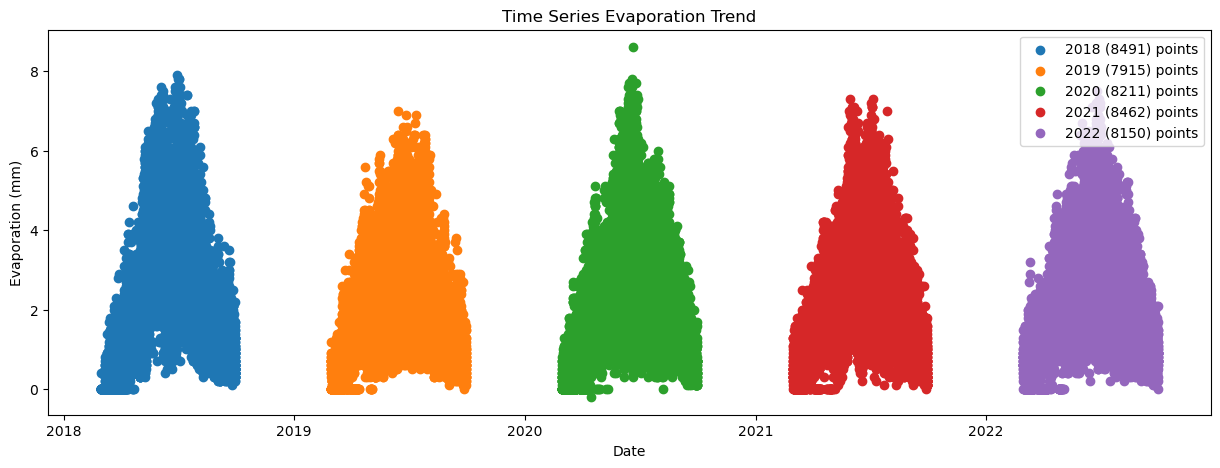

In [8]:
# Draw the scatter plot of the evaporation witht respect to time
# Filter out rows where evaporation is not missing
valid_evap_data = dataset_copied.dropna(subset=['evaporation_mm'])

# Group the valid data by year
# valid_evap_data['Year'] = valid_evap_data['year']
grouped_evap_data = valid_evap_data.groupby('year')

# Draw the scatter plot of snow_depth_cm vs date
def scatter_evaporation_timeseries(dataset_name, file='images/evaporation_mm_trend.png'):
    fig, ax = plt.subplots(figsize=(15, 5))
    for year, group in dataset_name:
        ax.scatter(group['date'], group['evaporation_mm'], label=f'{year} ({len(group)}) points')    
    # Set plot title and labels
    ax.set(title="Time Series Evaporation Trend", xlabel="Date", ylabel="Evaporation (mm)")    
    # Add legend
    ax.legend()    
    plt.savefig(file)
    plt.show()
    
scatter_evaporation_timeseries(grouped_evap_data, 'images/evaporation_mm_missing_values')

### The above evaporation scatter plot shows there is missing data from 2004 - 2010 and 2019 which are in total 8 years. So, we can see at least 8 years data is fully missing. The majority of the evaporation value range from 0 to 10mm but there are three values which tend to be outliers and can be removed from the dataset. Two of them are in 2018 (12.5mm and 15.8mm) and one is in 2023 (20.6mm).

#### Remove the evaporation outliers (>10mm) from the dataset and redraw the scatter plot of evaporation timeseries

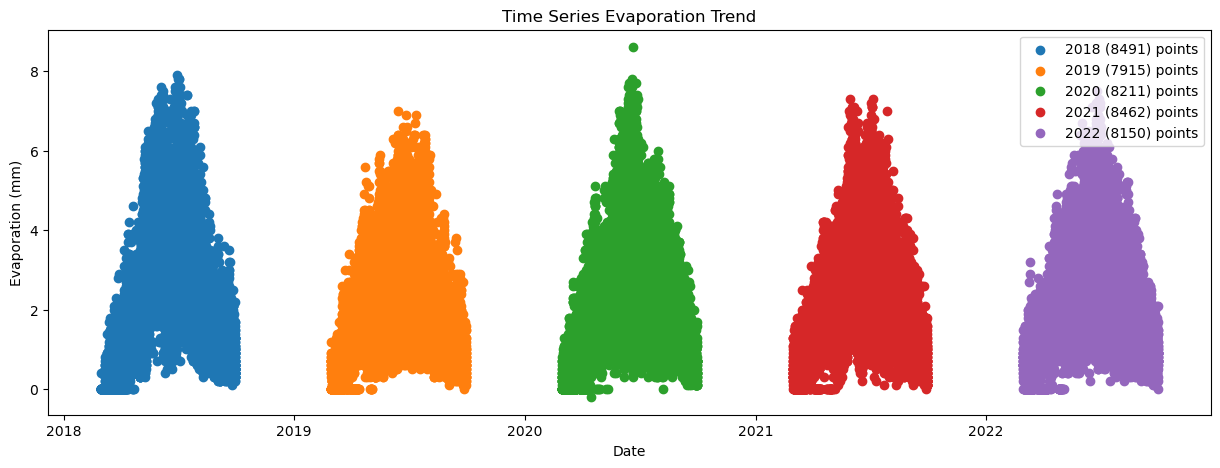

In [9]:
# Filter rows where 'evaporation_mm' is less than or equal to 10 and re-draw
dataset_copied = dataset_copied[(dataset_copied['evaporation_mm'] <= 10) | (pd.isna(dataset_copied['evaporation_mm']))]

# Filter out rows where evaporation is not missing
valid_evap_data = dataset_copied.dropna(subset=['evaporation_mm'])

# Group the valid data by year
grouped_evap_data = valid_evap_data.groupby('year')
# Redraw the evaporation_mm with time for outliers removed
scatter_evaporation_timeseries(grouped_evap_data, 'images/evaporation_mm_outliers_removed.png')

#### Fill the missing values of evaporation by the average of each same day throughout the years for non-empty values.

In [10]:
dataset_copied.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41229 entries, 0 to 41228
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   ID                       41229 non-null  int64         
 1   date                     41229 non-null  datetime64[ns]
 2   Station                  41229 non-null  object        
 3   mean_air_temperature_2m  41229 non-null  float64       
 4   min_air_temperature_2m   41229 non-null  float64       
 5   max_air_temperature_2m   41229 non-null  float64       
 6   relative_humidity        41229 non-null  float64       
 7   precipitation_mm         41229 non-null  float64       
 8   global_radiation_w_m2    41229 non-null  float64       
 9   JT10                     41229 non-null  float64       
 10  JT20                     41229 non-null  float64       
 11  evaporation_mm           41229 non-null  float64       
 12  year                     41229 n

In [11]:
dataset_copied.isna().sum()

ID                         0
date                       0
Station                    0
mean_air_temperature_2m    0
min_air_temperature_2m     0
max_air_temperature_2m     0
relative_humidity          0
precipitation_mm           0
global_radiation_w_m2      0
JT10                       0
JT20                       0
evaporation_mm             0
year                       0
month                      0
day                        0
dtype: int64

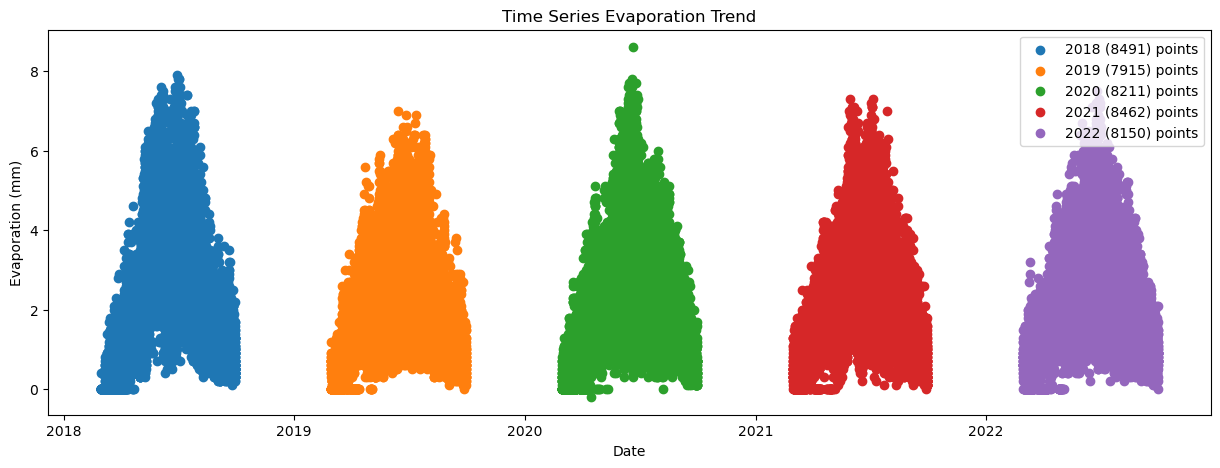

In [12]:
# Calculate the mean for evaporation_mm considering only non-NaN values for each day and month
mean_values = dataset_copied.groupby(['day', 'month'])['evaporation_mm'].apply(lambda x: x.dropna().mean()).reset_index(name='evaporation_mm_mean')

# Merge mean_values with the original DataFrame to fill missing values
dataset_copied = pd.merge(dataset_copied, mean_values, on=['day', 'month'], how='left')

# Fill missing values for evaporation_mm with the mean values calculated for the specific range of years
def fill_missing_evaporation(row):
    if pd.isna(row['evaporation_mm']):
        # Calculate the mean value for the specific range of years
        filtered_means = mean_values[(mean_values['day'] == row['day']) & (mean_values['month'] == row['month'])]
        mean_value = filtered_means['evaporation_mm_mean'].mean() if not filtered_means.empty else None
        return mean_value
    else:
        return row['evaporation_mm']

# Fill missing values for evaporation_mm with the mean values calculated for the specific range of years
dataset_copied['evaporation_mm'] = dataset_copied.apply(fill_missing_evaporation, axis=1)
# Drop auxiliary columns
dataset_copied.drop('evaporation_mm_mean', axis=1, inplace=True)
# Drop duplicates in case there are overlapping values from the merge
dataset_copied.drop_duplicates(inplace=True)

# Redraw the scatter plot for evaporation timeseries
# Filter out rows where evaporation is not missing
valid_evap_data = dataset_copied.dropna(subset=['evaporation_mm'])

# Group the valid data by year
grouped_evap_data = valid_evap_data.groupby('year')

# Draw the scatter plot of snow_depth_cm vs date
scatter_evaporation_timeseries(grouped_evap_data, 'images/evaporation_mm_missing_values_filled.png')

#### Let's count and draw the missing values based on monthes to see if the evaporation is missing for winter seasons

In [13]:
# # Filter the dataframe to select rows where evaporation_mm is NaN
# nan_evaporation = dataset_copied[dataset_copied['evaporation_mm'].isna()]

# # Group by month and count NaN occurrenc
# nan_evaporation_counts = nan_evaporation.groupby('month').size()

# # Define the plot
# fig, ax = plt.subplots(figsize=(10,5))
# # Plotting the bar graph
# nan_evaporation_counts.plot(kind='bar', ax=ax)

# # Annotating each bar with its count value
# for i, count in enumerate(nan_evaporation_counts):
#     ax.text(i, count, str(count), ha='center', va='bottom')

# # Setting labels and title
# ax.set_xlabel('Month')
# ax.set_ylabel('Count of NaN Evaporation')
# ax.set_title('Count of Missing Evaporation_mm by Month')
# # Save the figure to a file (e.g., PNG, PDF, etc.)
# plt.savefig('images/snow_depth_missing_count_by_month.png')  # Save as PNG format
# # Displaying the plot
# plt.show()

#### The above bargraph shows the missing evaporation measurements are mostly from January - April except few in May. This could be due to the winter season that evaporation is less likely. So, we can fill them all by zero value.

In [14]:
# Fill the missing evaporation_mm values by zero
dataset_copied['evaporation_mm'] = dataset_copied['evaporation_mm'].fillna(0.0)
dataset_copied.isna().sum()

ID                         0
date                       0
Station                    0
mean_air_temperature_2m    0
min_air_temperature_2m     0
max_air_temperature_2m     0
relative_humidity          0
precipitation_mm           0
global_radiation_w_m2      0
JT10                       0
JT20                       0
evaporation_mm             0
year                       0
month                      0
day                        0
dtype: int64

#### Draw Snow Depth(cm) vs Time to see the trend and missing values with time

In [15]:
# def scatter_snow_depth_timeseries(dataset_name, file='images/snow_depth_time_series.png'):
#     # Draw the scatter plot of the evaporation witht respect to time
#     # Filter out rows where snow_depth_cm is not missing
#     valid_snow_data = dataset_name.dropna(subset=['snow_depth_cm'])
    
#     # Group the valid data by year
#     # valid_snow_data['Year'] = valid_snow_data['date'].dt.year
#     grouped_snow_data = valid_snow_data.groupby('year')
    
#     # Draw the scatter plot of snow_depth_cm vs date
#     fig, ax = plt.subplots(figsize=(15, 5))
#     for year, group in grouped_snow_data:
#         ax.scatter(group['date'], group['snow_depth_cm'], label=f'{year} ({len(group)}) points')
    
#     # Set plot title and labels
#     ax.set(title="Time Series Snow Depth Trend", xlabel="Date", ylabel="Snow Depth (cm)")
    
#     # Add legend
#     ax.legend()
#     # Save the figure to a file (e.g., PNG, PDF, etc.)
#     plt.savefig(file)
    
#     plt.show()
    
# scatter_snow_depth_timeseries(dataset_copied, 'images/snow_depth_time_series_missing_values.png')

### The above snow depth scatter plot shows that snow data is completely missing from 2000-2015 and 2019. The daily snow depth ranges from 0 to about 50 cm.

### Some of the surface snow thickness values missing from the dataset are filled from the data gathered from MET Norway Frost API from 10/01/2026 - 29/03/2024

In [16]:
# # Merge the two dataframes based on the 'date' column
# snow_thickness = pd.read_csv('data/surface_snow_daily_2016_2024.csv')
# snow_thickness['date'] = pd.to_datetime(snow_thickness['date'])
# # Merge the two dataframes based on the 'date' column
# merged_df = pd.merge(dataset_copied, snow_thickness, on='date', suffixes=('_copied', '_thickness'), how='left')

# # Copy values from 'snow_depth_cm_thickness' to 'snow_depth_cm_copied' where 'snow_depth_cm_copied' is NaN
# merged_df['snow_depth_cm_copied'] = merged_df['snow_depth_cm_copied'].fillna(merged_df['snow_depth_cm_thickness'])

# # Drop the 'snow_depth_cm_thickness' column
# merged_df.drop(['snow_depth_cm_thickness','index','elementId','sourceId'], axis=1, inplace=True)

# # If needed, you can rename the 'snow_depth_cm_copied' column back to 'snow_depth_cm'
# merged_df.rename(columns={'snow_depth_cm_copied': 'snow_depth_cm'}, inplace=True)

# # Now, merged_df contains the updated snow depth values in the dataset_copied dataframe

# # To overwrite the original dataset_copied with the updated values:
# dataset_copied = merged_df.copy()

In [17]:
# # Filter rows for April 01 - November 30
# mask = (dataset_copied['date'].dt.month >= 4) & (dataset_copied['date'].dt.month <= 11)  # Filter months April to November
# dataset_copied.loc[mask, 'snow_depth_mm'] = 0  # Set snow depth to zero for the filtered rows


In [18]:
dataset_copied.isna().sum()

ID                         0
date                       0
Station                    0
mean_air_temperature_2m    0
min_air_temperature_2m     0
max_air_temperature_2m     0
relative_humidity          0
precipitation_mm           0
global_radiation_w_m2      0
JT10                       0
JT20                       0
evaporation_mm             0
year                       0
month                      0
day                        0
dtype: int64

In [19]:
# # Redraw the snow depth after some fillna
# scatter_snow_depth_timeseries(dataset_copied, 'images/snow_depth_missing_values_filled_from_MET.png')

### Define a helper function that is used to do the following:
##### 1. Fill missing values for each month of the year with the mean value of that month for the same year.
##### 2. For months where the mean value is NaN (i.e., all values for that month in the same year are NaN), fill missing values with the mean value of that month across all other years. 

In [20]:
# # Define a generic function that is used for filling missing values different columns
# def fill_missing_values(row_data, dataset_passed, column_name):
#     """
#     Fill missing values for a specified column based on conditions.
    
#     Parameters:
#         row_data (pandas.Series): A single row_data of the DataFrame.
#         dataset (pandas.DataFrame): The DataFrame containing the dataset.
#         column_name (str): The name of the column to fill missing values for.
    
#     Returns:
#         float: The filled value for the specified column.
#     """
#     if pd.isna(row_data[column_name]):
#         # Extract year and month from the current row_data
#         year = row_data['year']
#         month = row_data['month']
        
#         # Check if there are any non-NaN values for the same month and year
#         same_month_year = dataset_passed[(dataset_passed['year'] == year) & (dataset_passed['month'] == month)]
#         valid_values = same_month_year.dropna(subset=[column_name])
        
#         if not valid_values.empty:
#             # Calculate the mean of non-NaN values for the same month and year
#             mean_value = valid_values[column_name].mean()
#         else:
#             # Calculate the mean of non-NaN values for the same month in other years
#             other_years = dataset_passed[(dataset_passed['month'] == month) & (dataset_passed['year'] != year)]
#             other_years_valid_value = other_years.dropna(subset=[column_name])
#             mean_value = other_years_valid_value[column_name].mean()
        
#         return mean_value
#     else:
#         # If the value is not NaN, return the original value
#         return row_data[column_name]

# def fill_missing_by_monthly_mean(column_name, dataset_passed):
#     dataset_passed[column_name] = dataset_passed.apply(lambda row_data: fill_missing_values(row_data, dataset_passed, column_name), axis=1)
    

### Fill missing values of all features using the helper function

In [21]:
# %%time
# # Fill the missing values for all features by the monthly mean of that specific year or mean value of that month across all other years if the month of that specific year is NaN
# fill_missing_by_monthly_mean("evaporation_mm", dataset_copied)
# fill_missing_by_monthly_mean("JT2", dataset_copied)
# fill_missing_by_monthly_mean("JT5", dataset_copied)
# fill_missing_by_monthly_mean("JT10", dataset_copied)
# fill_missing_by_monthly_mean("JT20", dataset_copied)
# fill_missing_by_monthly_mean("JT50", dataset_copied)
# fill_missing_by_monthly_mean("JT100", dataset_copied)
# fill_missing_by_monthly_mean("relative_humidity", dataset_copied)
# fill_missing_by_monthly_mean("air_pressure_2m_mbar", dataset_copied)
# fill_missing_by_monthly_mean("global_radiation_w_m2", dataset_copied)
# fill_missing_by_monthly_mean("albedo_RR_GR", dataset_copied)
# fill_missing_by_monthly_mean("earth_heat_flux_MJ_m2", dataset_copied)
# fill_missing_by_monthly_mean("precipitation_mm", dataset_copied)
# fill_missing_by_monthly_mean("snow_depth_cm", dataset_copied)
# fill_missing_by_monthly_mean("phosynthetic_active_radiation_mE_m2", dataset_copied)

In [22]:
dataset_copied.isna().sum()

ID                         0
date                       0
Station                    0
mean_air_temperature_2m    0
min_air_temperature_2m     0
max_air_temperature_2m     0
relative_humidity          0
precipitation_mm           0
global_radiation_w_m2      0
JT10                       0
JT20                       0
evaporation_mm             0
year                       0
month                      0
day                        0
dtype: int64

### Soil temperature at 100cm with respect to time

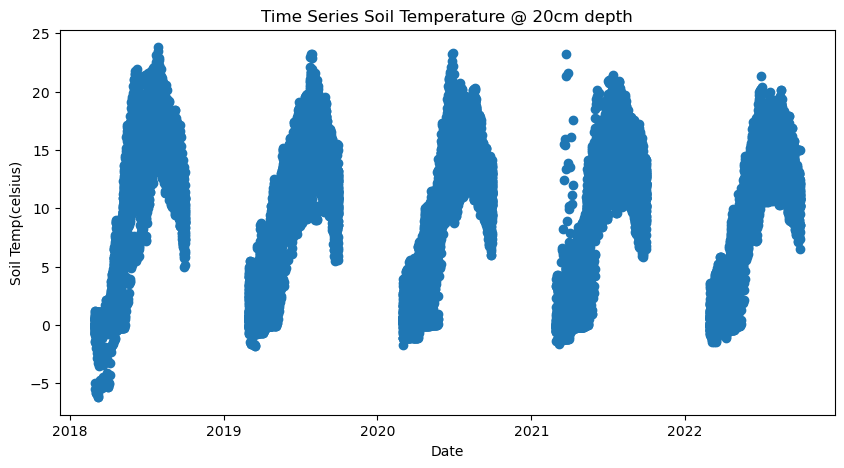

In [23]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.scatter(dataset["date"], dataset["JT20"]);
# ax.scatter(dataset["date"][1000:], dataset["JT100"][1000:]);
# Save the figure to a file (e.g., PNG, PDF, etc.)
ax.set(title="Time Series Soil Temperature @ 20cm depth", xlabel="Date", ylabel="Soil Temp(celsius)");
plt.savefig('images/soil_temperature_20cm_time_trend.png')  # Save as PNG format

#### The time series scatter chart shows that there is similar trend of increase and decrease every year except few times like at around 2016, it showed discontinuous nature  which is due to missing measurement errors. Overall, the dataset shows us that our data is a real timeseries data.

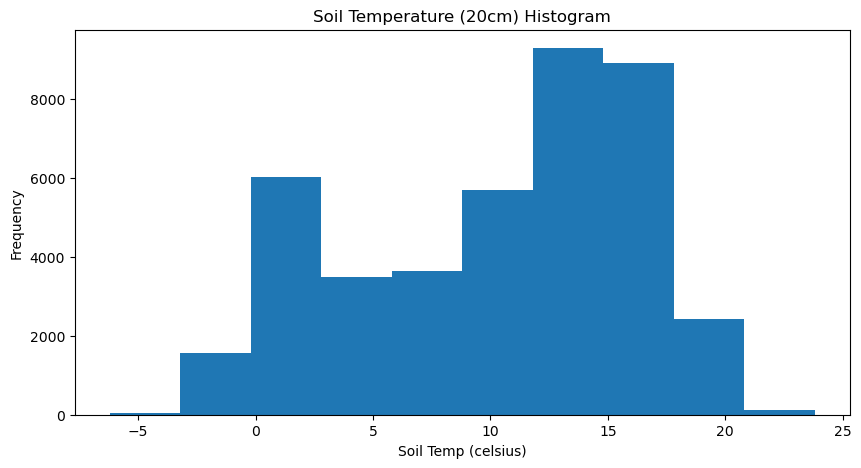

In [24]:
fig, ax = plt.subplots(figsize =(10,5))
ax.hist(dataset["JT20"]);
ax.set(title="Soil Temperature (20cm) Histogram", xlabel='Soil Temp (celsius)', ylabel="Frequency");

### Let's see the scatter plots of the the original values of the important features

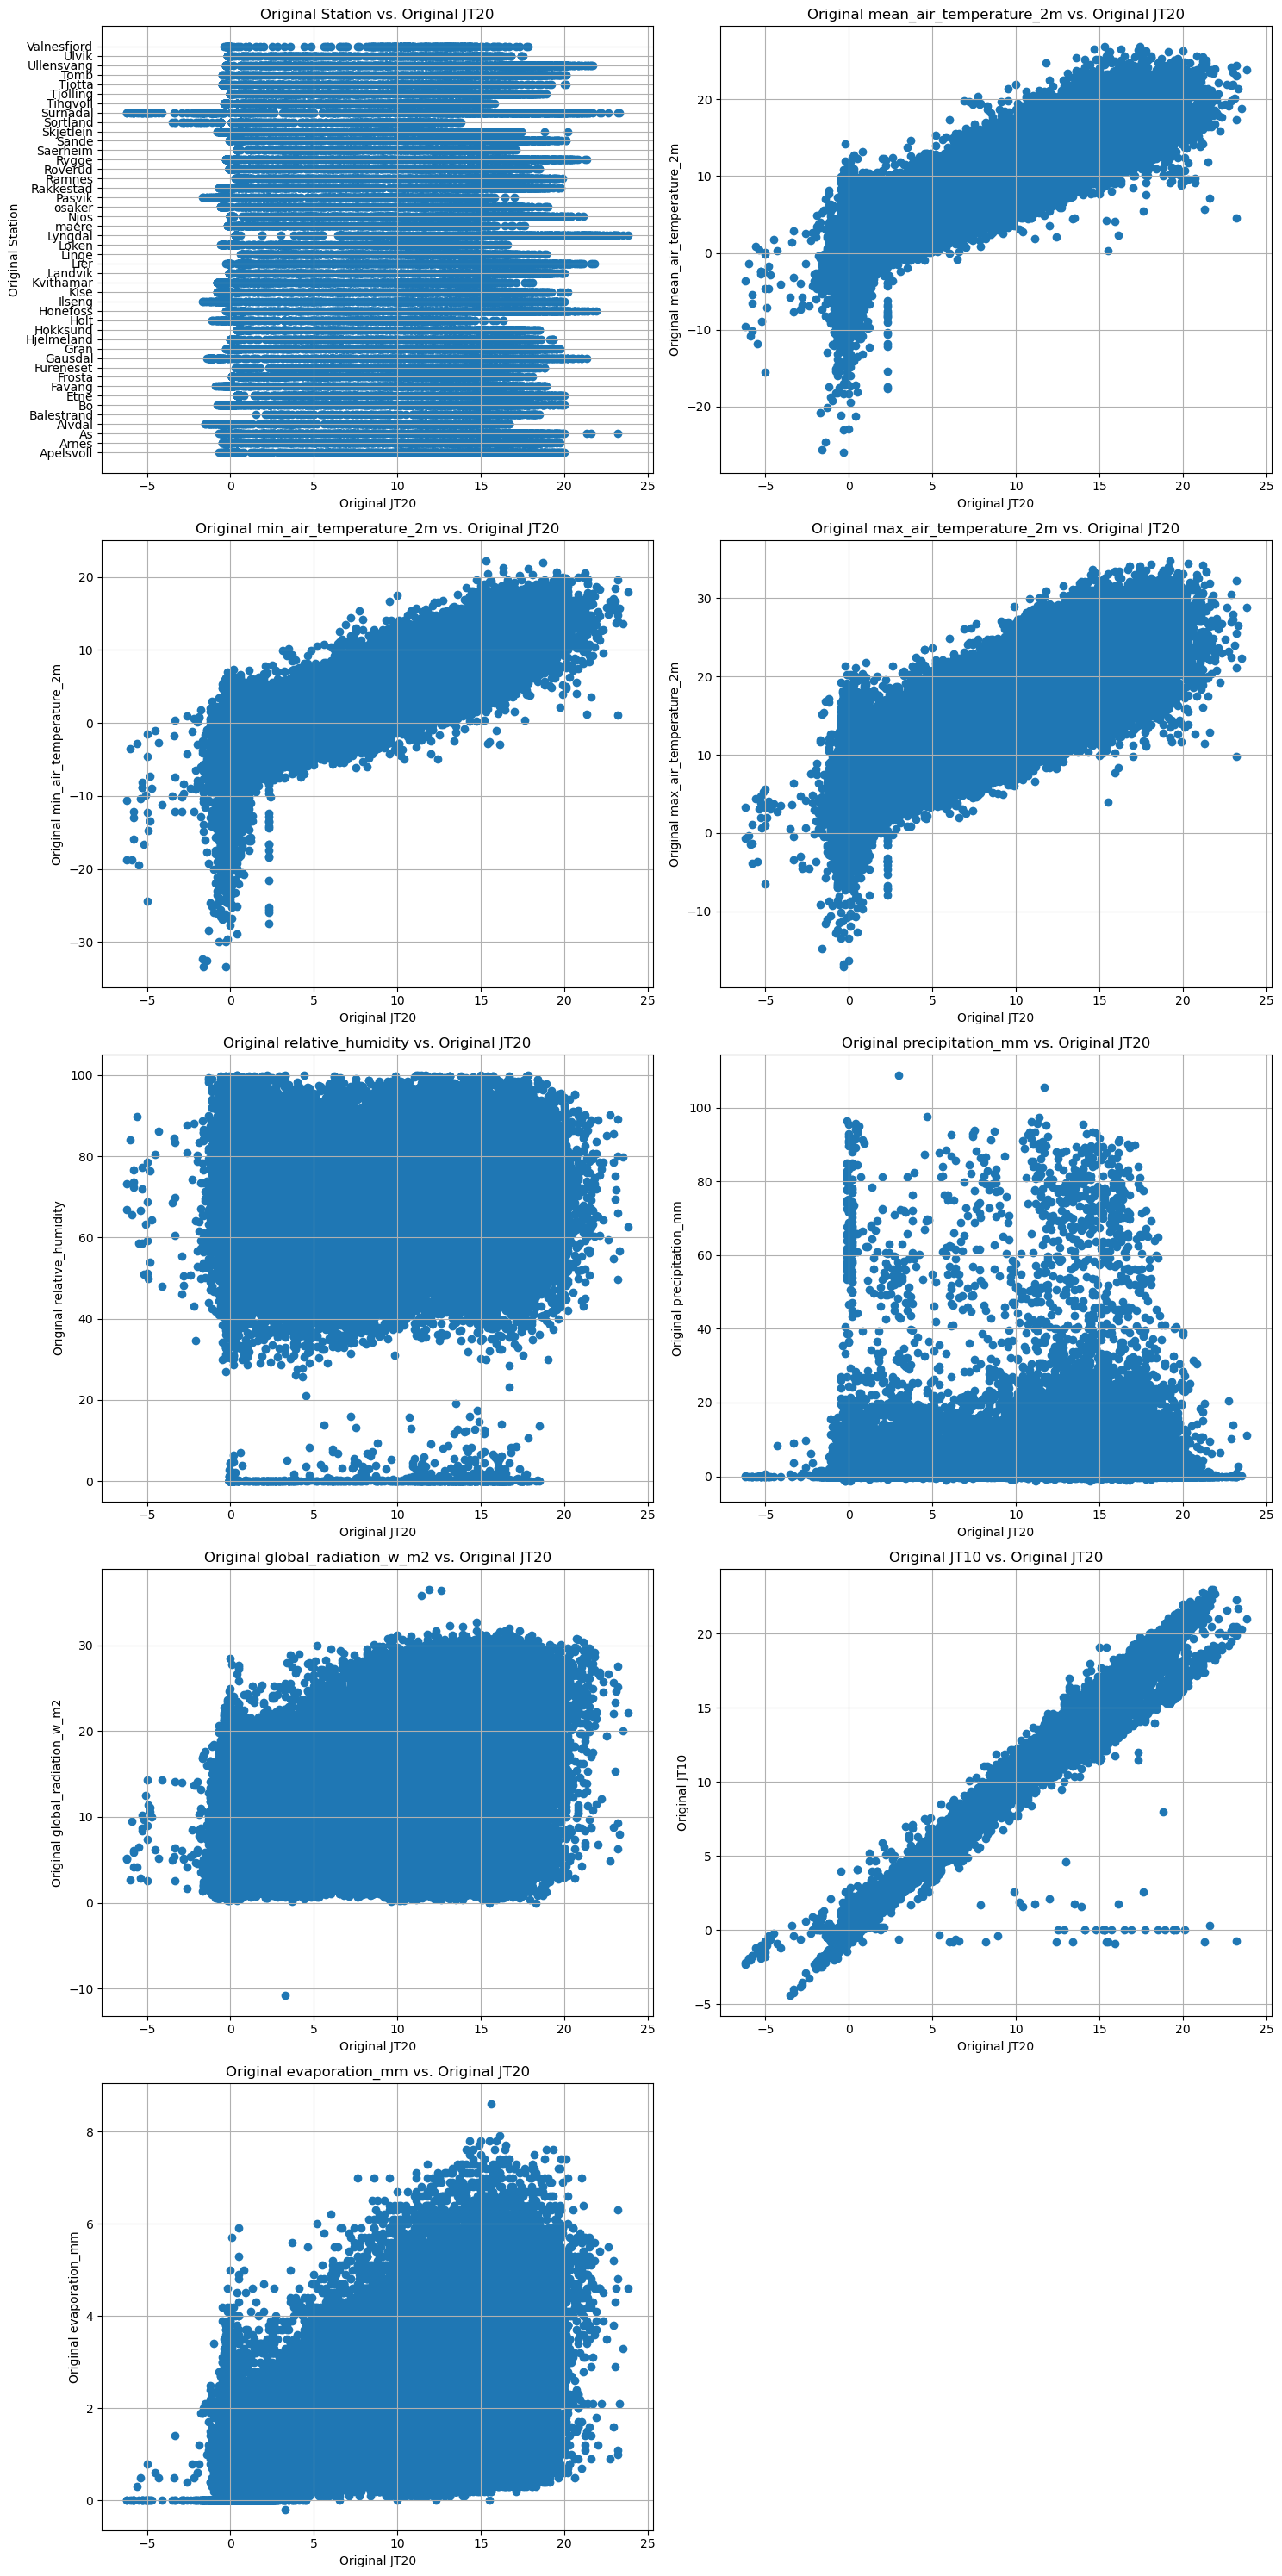

In [25]:
# Extract the features list from the dataset columns
features = dataset_copied.columns.tolist()
# remove the JT100 feature from the features list
features.remove('JT20')
# reomve the date feature from the features list
features.remove('date')
# reomve the year feature from the features list
features.remove('year')
# remove the month feature from the features list
features.remove('month')
# reomve the day feature from the features list
features.remove('day')
# reomve the ID from the features list
features.remove('ID')

# Extract the 'JT100' series
original_JT100 = dataset_copied['JT20']

# Extract the important features
original_df = dataset_copied[features]

# Calculate the number of rows needed for the subplot grid
num_features = len(features)
num_cols = 2  # Number of columns for subplots
num_rows = (num_features + num_cols - 1) // num_cols

# Create subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 6 * num_rows))

# Plot z-score normalized features against z-score normalized 'JT100' individually
for i, feature in enumerate(features):
    row = i // num_cols
    col = i % num_cols
    ax = axs[row, col]
        
    ax.scatter(original_JT100, original_df[feature])
    ax.set_title(f'Original {feature} vs. Original JT20')
    ax.set_xlabel('Original JT20')
    ax.set_ylabel(f'Original {feature}')
    ax.grid(True)

# Hide any empty subplots
for i in range(num_features, num_rows * num_cols):
    axs.flatten()[i].axis('off')

plt.tight_layout()
plt.show()

### Let's check the outliers by normalizing our features using the z-score method seeing the trend on the scatter plots

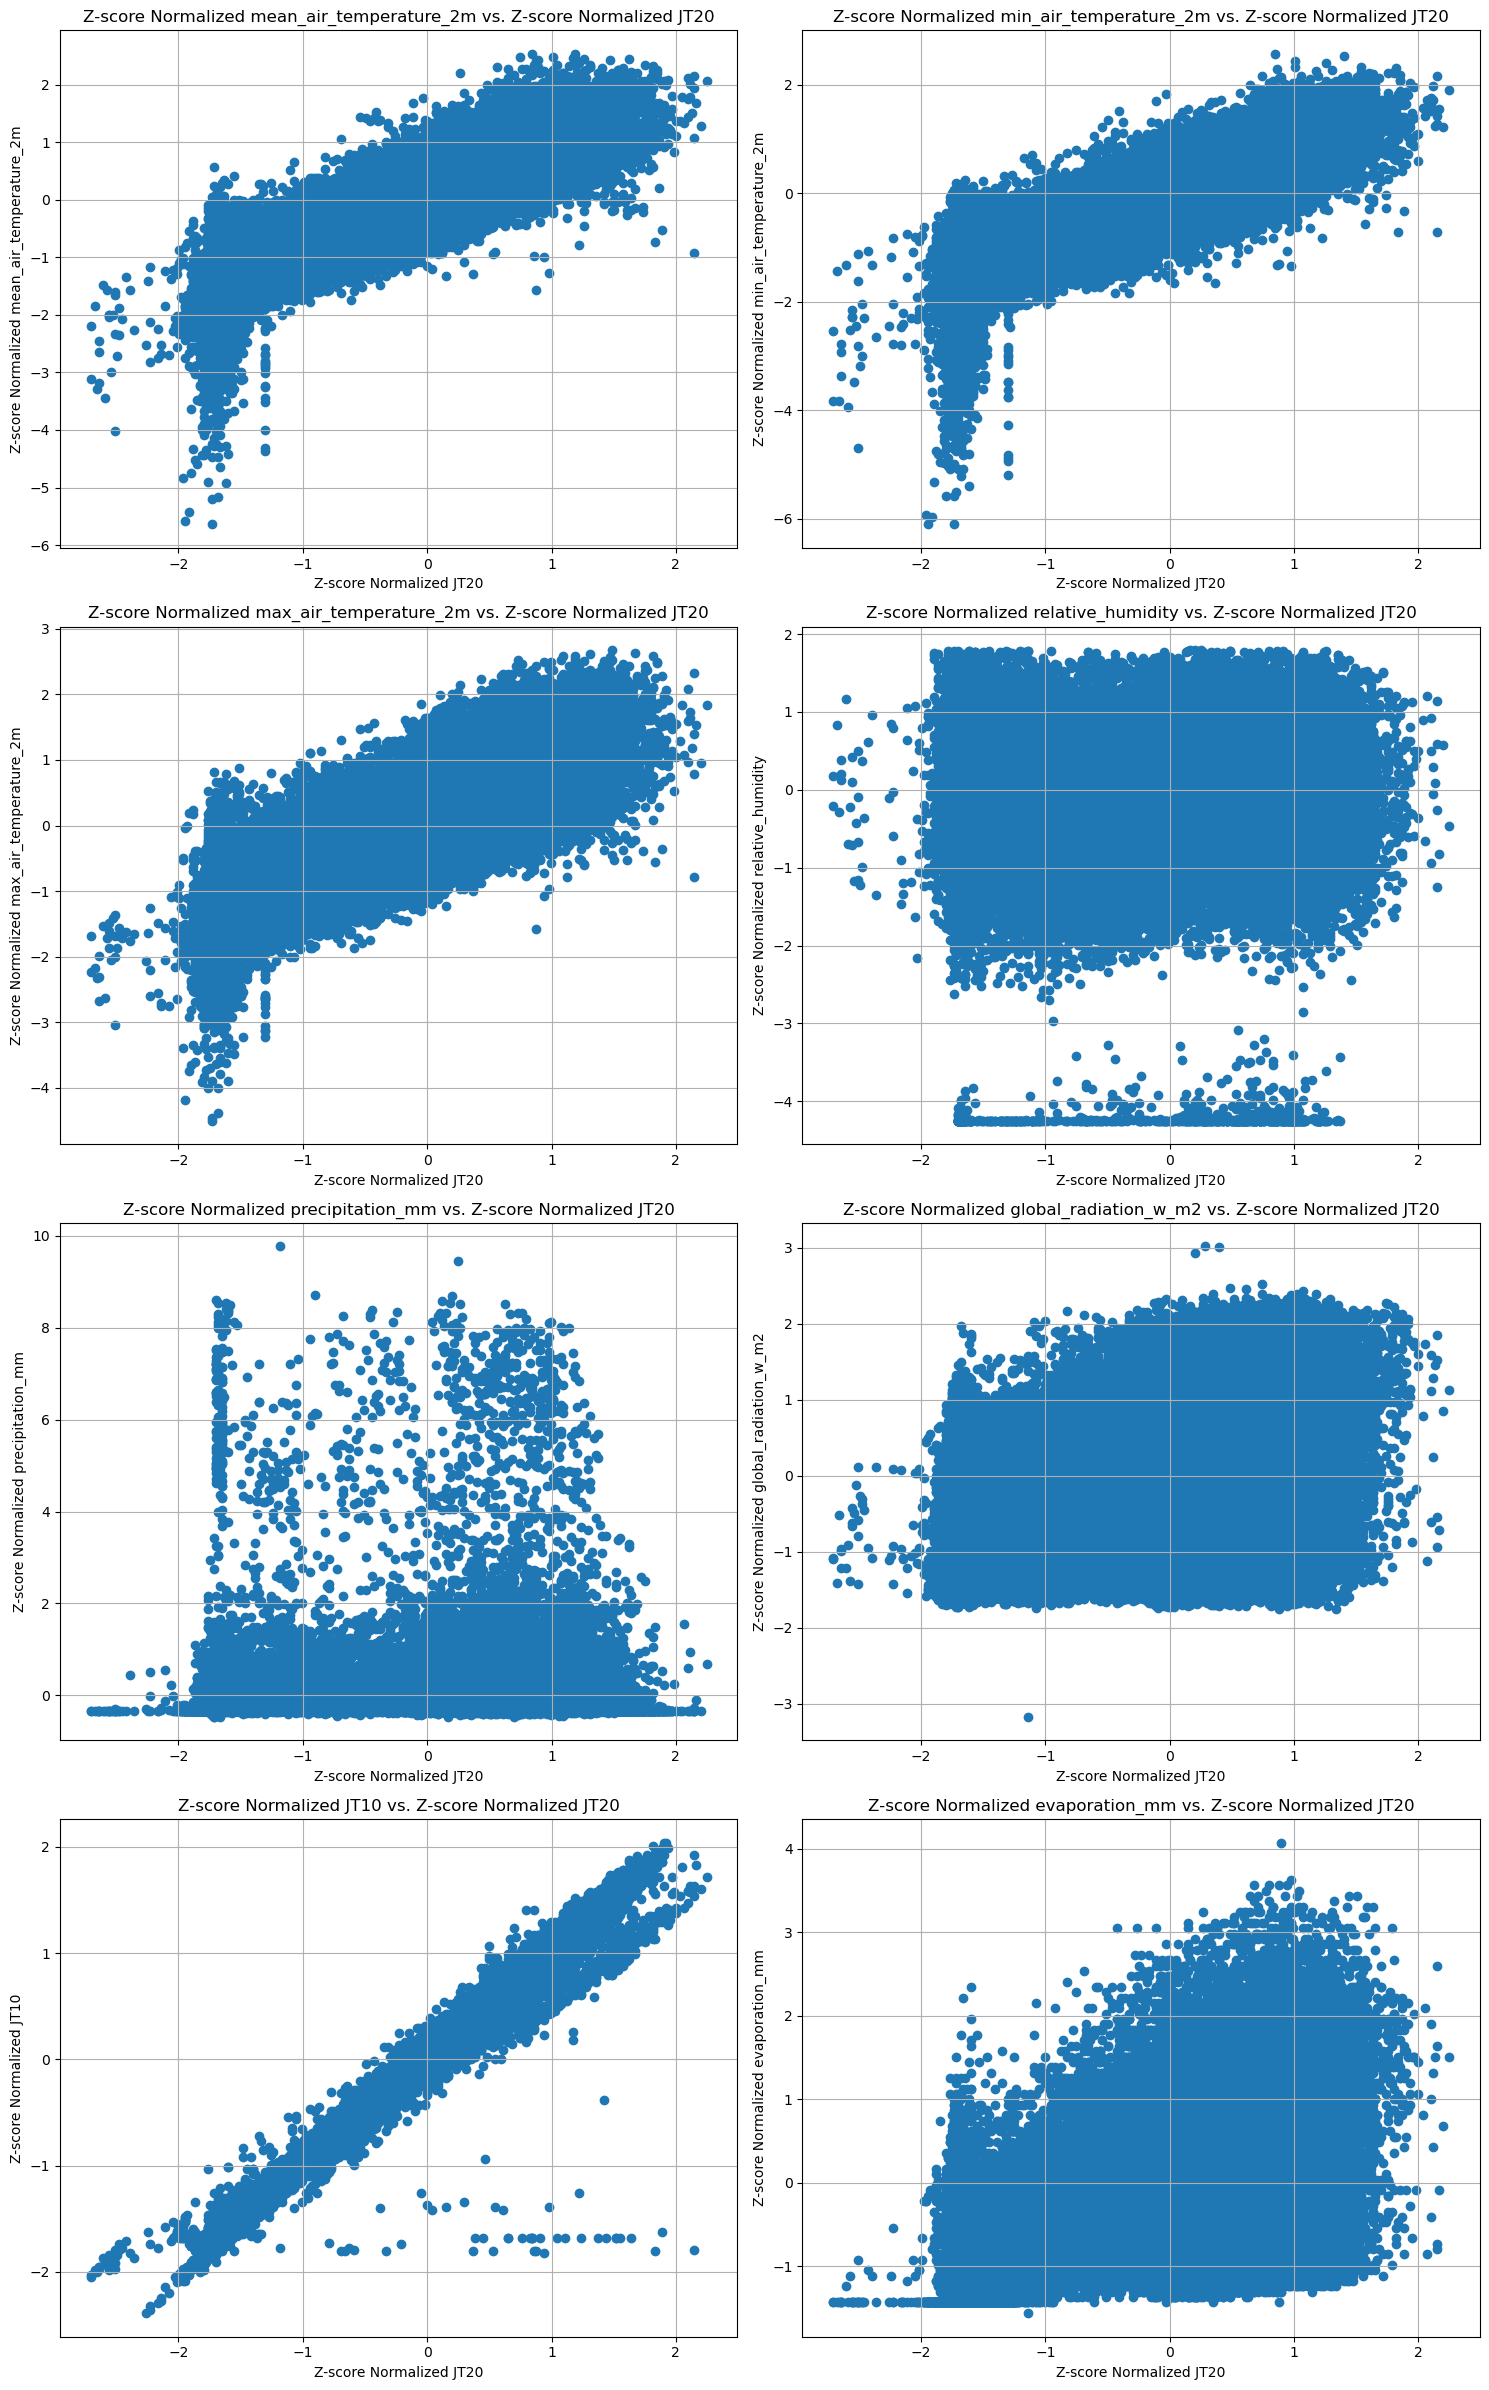

In [26]:
# Extract the features list from the dataset columns
features = dataset_copied.columns.tolist()
# remove the JT100 feature from the features list
features.remove('JT20')
# Remove station features
features.remove('Station')
# reomve the date feature from the features list
features.remove('date')
# reomve the year feature from the features list
features.remove('year')
# remove the month feature from the features list
features.remove('month')
# reomve the day feature from the features list
features.remove('day')
# reomve the ID from the features list
features.remove('ID')

# Calculate Z-score for the target variable 'JT100'
zscore_JT20 = (dataset_copied['JT20'] - dataset_copied['JT20'].mean()) / dataset_copied['JT20'].std()

# Calculate Z-score for all features
zscore_df = (dataset_copied[features] - dataset_copied[features].mean()) / dataset_copied[features].std()

# Calculate the number of rows needed for the subplot grid
num_features = len(features)
num_cols = 2  # Number of columns for subplots
num_rows = (num_features + num_cols - 1) // num_cols

# Create subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 6 * num_rows))

# Plot z-score normalized features against z-score normalized 'JT100' individually
for i, feature in enumerate(features):
    row = i // num_cols
    col = i % num_cols
    ax = axs[row, col]
        
    ax.scatter(zscore_JT20, zscore_df[feature])
    ax.set_title(f'Z-score Normalized {feature} vs. Z-score Normalized JT20')
    ax.set_xlabel('Z-score Normalized JT20')
    ax.set_ylabel(f'Z-score Normalized {feature}')
    ax.grid(True)

# Hide any empty subplots
for i in range(num_features, num_rows * num_cols):
    axs.flatten()[i].axis('off')

plt.tight_layout()
plt.show()

### The scatter plots above show that there are outliers for some of the features. To remove the outliers, let's first normalize our dataset values to create new normalized dataset

### Define a custom scatter_plot function that takes the features and dataset and plots one feature against the other

In [27]:
def scatter_plot(features, df):
    # Calculate the number of rows needed for the subplot grid
    num_features = len(features)
    num_cols = 2  # Number of columns for subplots
    num_rows = (num_features + num_cols - 1) // num_cols
    
    # Create subplots
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 6 * num_rows))
    
    # Plot z-score normalized features against z-score normalized 'JT100' individually
    for i, feature in enumerate(features):
        row = i // num_cols
        col = i % num_cols
        ax = axs[row, col]
        
        ax.scatter(df['JT20'], df[feature])
        ax.set_title(f'Z-score Normalized {feature} vs. Z-score Normalized JT20')
        ax.set_xlabel('Z-score Normalized JT20')
        ax.set_ylabel(f'Z-score Normalized {feature}')
        ax.grid(True)
    
    # Hide any empty subplots
    for i in range(num_features, num_rows * num_cols):
        axs.flatten()[i].axis('off')
    
    plt.tight_layout()
    plt.show()

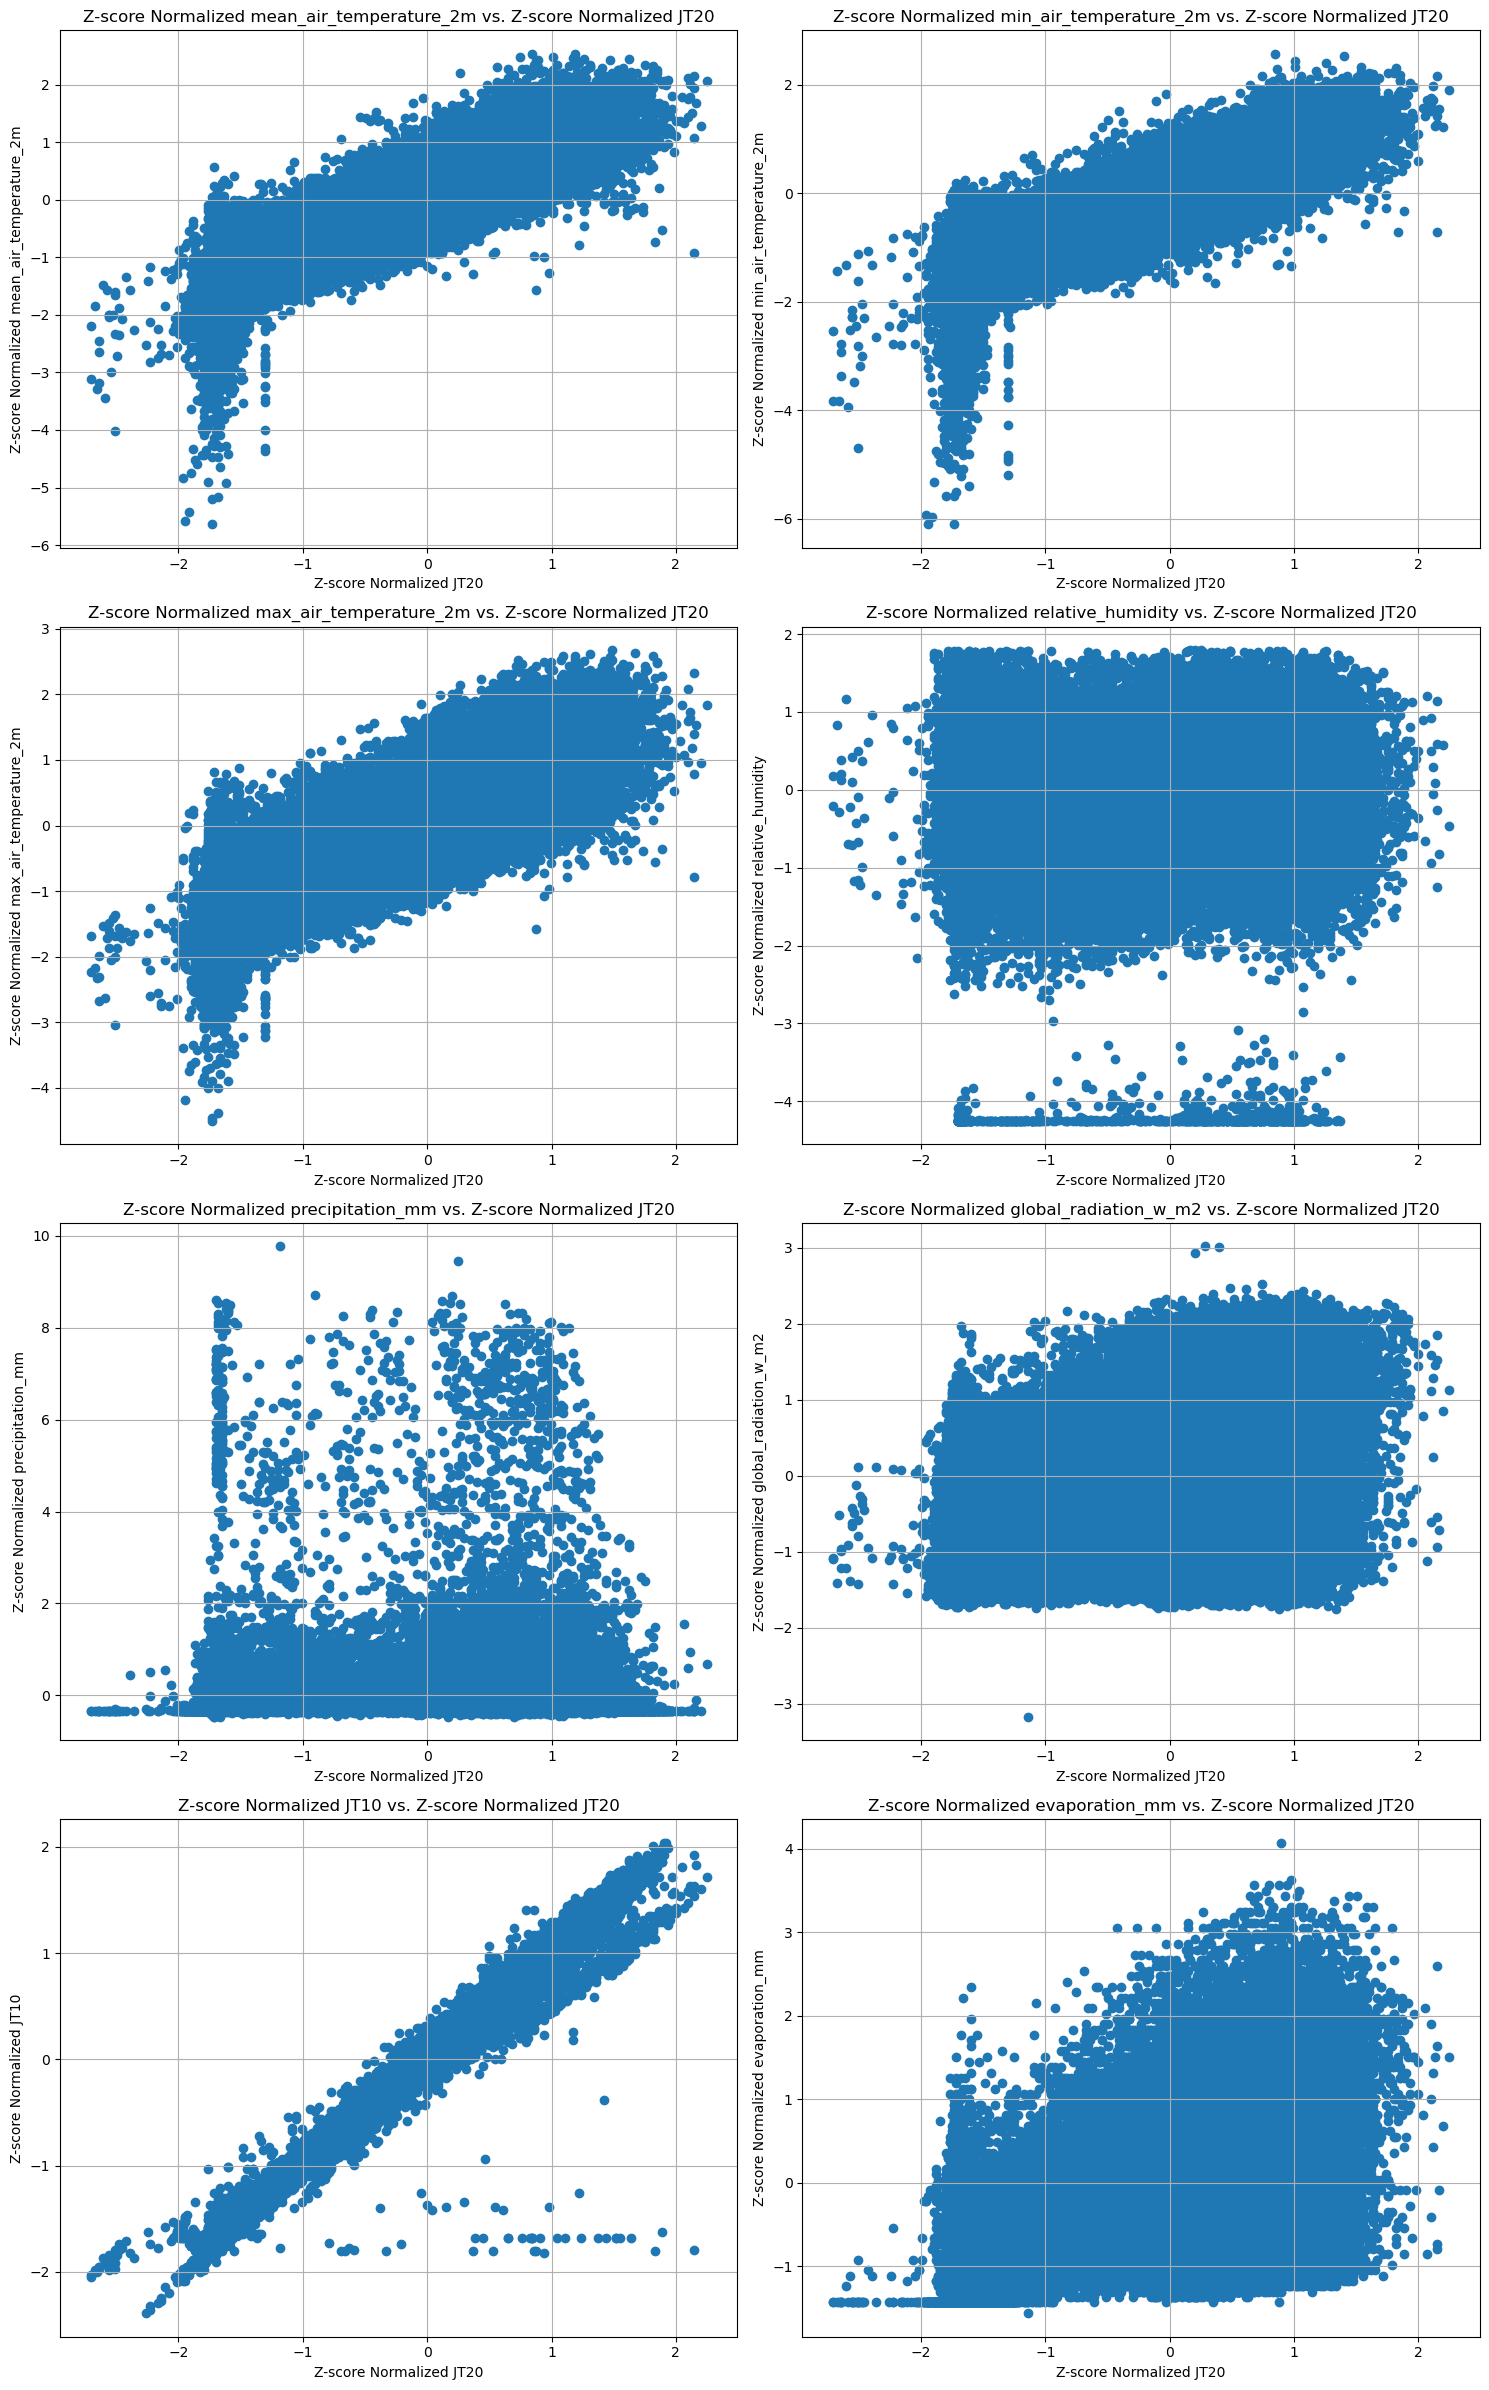

In [28]:
# Extract the features list from the dataset columns
features = dataset_copied.columns.tolist()

# Create a local copy of the dataset and drop the date and year features
score_local_dataset = dataset_copied.drop(['ID','date', 'year', 'Station'], axis=1)

# Temporary reomve the ID from the features list
features.remove('ID')
# reomve the date feature from the features list
features.remove('date')
# reomve the year feature from the features list
features.remove('year')
# reomve the station feature from the features list
features.remove('Station')

# Keep the original dataset's means of each feature for later use in denormalization
mean_original = score_local_dataset[features].mean()
# Keep the original dataset's standard deviationa of each feature for later use in denormalization
std_original = score_local_dataset[features].std()
# Calculate Z-score for all features
zscore_df = (score_local_dataset[features] - mean_original) / std_original

# Create a new DataFrame to store the normalized values
dataset_normalized = zscore_df.copy()
# copy the ID column from the original dataset to the dataset_normalized
dataset_normalized['ID'] = dataset_copied['ID']
dataset_normalized['Station'] = dataset_copied['Station']
dataset_normalized.to_csv('data/IMT_dataset_normalized.csv', index=False)

# # Normalize each feature by its corresponding z-score value
# for feature in features:
#     zscore_feature = zscore_df[feature]
#     dataset_normalized[feature] = dataset_copied[feature] / zscore_feature


# remove the month feature from the features list
features.remove('month')
# reomve the day feature from the features list
features.remove('day')
# reomve the JT100 feature from the features list
features.remove('JT20')
# Call the custom built scatter plot for multiple features
scatter_plot(features, dataset_normalized)

### Let's check any outliers on our dataset using statistical Z-score and Interquartile Range (IQR) techniques for all the features
#### 1. Z-score: Calculate the z-score for each data point, which represents how many standard deviations it is away from the mean. Data points with a z-score beyond a certain threshold can be considered outliers.
#### 2. IQR: IQR is the range between the first quartile (Q1) and the third quartile (Q3). Data points outside the range (Q1 - 1.5 * IQR, Q3 + 1.5 * IQR) are typically considered outliers.

In [29]:
dataset_normalized

,mean_air_temperature_2m,min_air_temperature_2m,max_air_temperature_2m,relative_humidity,precipitation_mm,global_radiation_w_m2,JT10,JT20,evaporation_mm,month,day,ID,Station
0,-4.420780,-4.342358,-3.893006,-0.176504,-0.352424,-0.517694,-1.645751,-1.599584,-1.430946,-1.50711,-1.675206,1,Apelsvoll
1,-3.709757,-4.108257,-3.464326,-0.273184,-0.352424,-1.119936,-1.645751,-1.599584,-1.430946,-1.50711,-1.561878,2,Apelsvoll
2,-2.983277,-2.610010,-2.717593,0.149793,-0.352424,-1.198490,-1.645751,-1.599584,-1.430946,-1.50711,-1.448549,3,Apelsvoll
3,-2.859621,-2.516369,-2.496338,0.536514,-0.315195,-0.962830,-1.661912,-1.599584,-1.430946,-1.50711,-1.335221,4,Apelsvoll
4,-2.797793,-2.344695,-2.842048,1.116597,-0.166282,-1.407965,-1.661912,-1.599584,-1.430946,-1.50711,-1.221893,5,Apelsvoll
...,...,...,...,...,...,...,...,...,...,...,...,...,...
41224,0.185413,0.589372,-0.283795,-0.514885,-0.305888,-1.172305,-0.110374,-0.030927,-0.534841,1.50889,1.157998,41225,Valnesfjord
41225,-0.046442,0.199204,-0.352937,-0.375907,-0.371038,-0.818815,-0.239669,-0.113488,-0.598849,1.50889,1.271327,41226,Valnesfjord
41226,-0.139184,-0.144145,-0.256138,-0.097951,-0.361731,-0.779538,-0.304316,-0.196049,-0.790871,1.50889,1.384655,41227,Valnesfjord
41227,-0.046442,0.355271,-0.339108,-0.279227,-0.352424,-1.159213,-0.271993,-0.196049,-0.918886,1.50889,1.497983,41228,Valnesfjord


### OneHotEncoder: Let's encode the station feature values to numeric using OneHotEncoder

In [30]:
# # Import Pipeline from sklearn's pipeline module
# from sklearn.pipeline import Pipeline
# # Import ColumnTransformer from sklearn's compose module
# from sklearn.compose import ColumnTransformer
# # Import OneHotEncoder from sklearn's preprocessing module
# from sklearn.preprocessing import OneHotEncoder

# # Initialize OneHotEncoder
# one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# # Perform one-hot encoding on 'Station' column
# station_encoded = one_hot_encoder.fit_transform(dataset_normalized[['Station']])

# # Convert the encoded array into a DataFrame
# station_encoded_df = pd.DataFrame(station_encoded, columns=one_hot_encoder.get_feature_names_out(['Station']))

# # Concatenate the encoded 'Station' DataFrame with the original DataFrame
# dataset_normalized = pd.concat([dataset_normalized.drop(columns=['Station']), station_encoded_df], axis=1)


# # Define different categorical features 
# categorical_features = ["Station"]

# # Create categorical transformer Pipeline
# categorical_transformer = Pipeline(steps=[
#     # Set OneHotEncoder to ignore the unknowns
#     ("onehot", OneHotEncoder(handle_unknown="ignore"))])

# # Setup preprocessing steps (fill missing values, then convert to numbers)
# preprocessor = ColumnTransformer(transformers=[("cat", categorical_transformer, categorical_features)])

# # Fit the ColumnTransformer to your dataset_normalized DataFrame
# preprocessor.fit(dataset_normalized)

# # Now you can safely use the transform method
# encoded_station = preprocessor.transform(dataset_normalized[categorical_features])

# # Create a DataFrame from the encoded 'Station' feature
# encoded_station_df = pd.DataFrame(encoded_station, columns=preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))

# # Combine the encoded 'Station' feature with the other features in the dataset_normalized DataFrame
# encoded_dataset_normalized = pd.concat([dataset_normalized.drop(columns=categorical_features), encoded_station_df], axis=1)

# # Assign the encoded dataset_normalized DataFrame back to dataset_normalized
# dataset_normalized = encoded_dataset_normalized

# # Display the updated dataset_normalized DataFrame
# dataset_normalized

In [31]:
dataset_normalized

,mean_air_temperature_2m,min_air_temperature_2m,max_air_temperature_2m,relative_humidity,precipitation_mm,global_radiation_w_m2,JT10,JT20,evaporation_mm,month,day,ID,Station
0,-4.420780,-4.342358,-3.893006,-0.176504,-0.352424,-0.517694,-1.645751,-1.599584,-1.430946,-1.50711,-1.675206,1,Apelsvoll
1,-3.709757,-4.108257,-3.464326,-0.273184,-0.352424,-1.119936,-1.645751,-1.599584,-1.430946,-1.50711,-1.561878,2,Apelsvoll
2,-2.983277,-2.610010,-2.717593,0.149793,-0.352424,-1.198490,-1.645751,-1.599584,-1.430946,-1.50711,-1.448549,3,Apelsvoll
3,-2.859621,-2.516369,-2.496338,0.536514,-0.315195,-0.962830,-1.661912,-1.599584,-1.430946,-1.50711,-1.335221,4,Apelsvoll
4,-2.797793,-2.344695,-2.842048,1.116597,-0.166282,-1.407965,-1.661912,-1.599584,-1.430946,-1.50711,-1.221893,5,Apelsvoll
...,...,...,...,...,...,...,...,...,...,...,...,...,...
41224,0.185413,0.589372,-0.283795,-0.514885,-0.305888,-1.172305,-0.110374,-0.030927,-0.534841,1.50889,1.157998,41225,Valnesfjord
41225,-0.046442,0.199204,-0.352937,-0.375907,-0.371038,-0.818815,-0.239669,-0.113488,-0.598849,1.50889,1.271327,41226,Valnesfjord
41226,-0.139184,-0.144145,-0.256138,-0.097951,-0.361731,-0.779538,-0.304316,-0.196049,-0.790871,1.50889,1.384655,41227,Valnesfjord
41227,-0.046442,0.355271,-0.339108,-0.279227,-0.352424,-1.159213,-0.271993,-0.196049,-0.918886,1.50889,1.497983,41228,Valnesfjord


#### Extract the outliers and histplot of each feature in the dataset_normalized
##### 1. Descriptive outlier detection is used to determine if there is a problem with the data, for example, if the data is not normally distributed.
##### 2. Prescriptive outlier detection is used to determine if a specific action needs to be taken
#### Z-Score is a measure of how many standard deviations a data point is away from the mean. Typically, data points with a Z-Score greater than a threshold are considered outliers

In [32]:
# # Get the list of features from our dataset columns
# features = dataset_normalized.columns.tolist()

# # remove the month feature from the features list
# features.remove('month')
# # remove the day feature from the features list
# features.remove('day')
# # remove the ID from the features list
# features.remove('ID')

# # Define different Z-score thresholds for each feature
# zscore_thresholds = {
#     'mean_air_temperature_2m': (-4, 3),
#     'min_air_temperature_2m': (-4, 3),
#     'max_air_temperature_2m': (-4, 3),
#     'relative_humidity': (-4, 2),
#     'air_pressure_2m_mbar': (-5, 5),
#     'precipitation_mm': (-1, 8),
#     'evaporation_mm': (-1, 4),
#     'earth_heat_flux_MJ_m2': (-5, 5),
#     'JT2': (-2, 2.5),
#     'JT5': (-2, 2.5),
#     'JT10': (-2, 2.5),
#     'JT20': (-2, 2.5),
#     'JT50': (-2, 2.5),
#     'global_radiation_w_m2': (-2, 3),
#     'phosynthetic_active_radiation_mE_m2': (-1.5, 3),
#     'albedo_RR_GR': (-15, 5),
#     'snow_depth_cm': (-1, 12),
#     'JT100': (-2, 2.5)
# }

# # Plot histograms of Z-scores for all features
# num_features = len(features)
# num_cols = 2
# num_rows = (num_features + num_cols - 1) // num_cols
# plt.figure(figsize=(15, 5 * num_rows))
# for i, feature in enumerate(features, start=1):
#     plt.subplot(num_rows, num_cols, i)
#     sns.histplot(zscore_df[feature], kde=True)
#     plt.title('Z-score distribution')
#     plt.xlabel(f'Z-score of {feature}')
#     plt.ylabel('Frequency')
# plt.tight_layout()
# plt.show()

# # Identify outliers based on Z-score for all features using different thresholds
# outliers_zscore_dict = {}
# for feature in features:
#     lower_threshold, upper_threshold = zscore_thresholds.get(feature)  
#     if upper_threshold is None or lower_threshold is None:
#         continue
#     outliers_zscore = dataset_normalized[(dataset_normalized[feature]> upper_threshold) | (dataset_normalized[feature] < lower_threshold)]
#     if not outliers_zscore.empty:
#         outliers_zscore_dict[feature] = outliers_zscore[feature].tolist()

# # Calculate IQR for all features
# Q1 = dataset_normalized[features].quantile(0.25)
# Q3 = dataset_normalized[features].quantile(0.75)
# IQR = Q3 - Q1

# # Identify outliers based on IQR for all features
# outliers_iqr_dict = {}
# for feature in features:
#     outliers_iqr = dataset_normalized[(dataset_normalized[feature] < Q1[feature] - 1.5 * IQR[feature]) | 
#                                                (dataset_normalized[feature] > Q3[feature] + 1.5 * IQR[feature])]
#     if not outliers_iqr.empty:
#         outliers_iqr_dict[feature] = outliers_iqr[feature].tolist()


#### Remove the outliers for each feature and generate the filtered new dataset

In [33]:
# outliers_zscore_dict

In [34]:
# outliers_iqr_dict

### Generate and save the Normalized Outlier Filtered dataset

In [35]:
# # Deifne the function to remove the outliers from the dataset
# def remove_outliers(df, thresholds):
#     """
#     Removes outliers from a DataFrame based on z-score thresholds.
    
#     Parameters:
#         df (pd.DataFrame): The input DataFrame (already z-score normalized).
#         thresholds (dict): A dictionary containing feature names as keys and (lower, upper) z-score thresholds as values.
    
#     Returns:
#         pd.DataFrame: DataFrame with outliers removed.
#     """
#     for feature, (lower, upper) in thresholds.items():
#         df = df[(df[feature] >= lower) & (df[feature] <= upper)]
    
#     return df

# # The thresholds of the DataFrame normalized 'dataset_normalized' (already z-score normalized)
# zscore_thresholds = {
#     'mean_air_temperature_2m': (-4, 3),
#     'min_air_temperature_2m': (-4, 3),
#     'max_air_temperature_2m': (-4, 3),
#     'relative_humidity': (-4, 2),
#     'air_pressure_2m_mbar': (-5, 5),
#     'precipitation_mm': (-1, 8),
#     'evaporation_mm': (-1, 4),
#     'earth_heat_flux_MJ_m2': (-5, 5),
#     'JT2': (-2, 2.5),
#     'JT5': (-2, 2.5),
#     'JT10': (-2, 2.5),
#     'JT20': (-2, 2.5),
#     'JT50': (-2, 2.5),
#     'global_radiation_w_m2': (-2, 3),
#     'phosynthetic_active_radiation_mE_m2': (-1.5, 3),
#     'albedo_RR_GR': (-15, 5),
#     'snow_depth_cm': (-1, 12),
#     'JT100': (-2, 2.5)
# }
# # Remove the outliers and generate a new filtered dataset without outliers
# dataset_normalized_outlier_filtered = remove_outliers(dataset_normalized, zscore_thresholds)
# dataset_normalized_outlier_filtered.to_csv('data/dataset_normalized_outlier_filtered.csv', index=False)
# #Show the new dataset
# dataset_normalized_outlier_filtered

In [36]:
dataset_normalized

,mean_air_temperature_2m,min_air_temperature_2m,max_air_temperature_2m,relative_humidity,precipitation_mm,global_radiation_w_m2,JT10,JT20,evaporation_mm,month,day,ID,Station
0,-4.420780,-4.342358,-3.893006,-0.176504,-0.352424,-0.517694,-1.645751,-1.599584,-1.430946,-1.50711,-1.675206,1,Apelsvoll
1,-3.709757,-4.108257,-3.464326,-0.273184,-0.352424,-1.119936,-1.645751,-1.599584,-1.430946,-1.50711,-1.561878,2,Apelsvoll
2,-2.983277,-2.610010,-2.717593,0.149793,-0.352424,-1.198490,-1.645751,-1.599584,-1.430946,-1.50711,-1.448549,3,Apelsvoll
3,-2.859621,-2.516369,-2.496338,0.536514,-0.315195,-0.962830,-1.661912,-1.599584,-1.430946,-1.50711,-1.335221,4,Apelsvoll
4,-2.797793,-2.344695,-2.842048,1.116597,-0.166282,-1.407965,-1.661912,-1.599584,-1.430946,-1.50711,-1.221893,5,Apelsvoll
...,...,...,...,...,...,...,...,...,...,...,...,...,...
41224,0.185413,0.589372,-0.283795,-0.514885,-0.305888,-1.172305,-0.110374,-0.030927,-0.534841,1.50889,1.157998,41225,Valnesfjord
41225,-0.046442,0.199204,-0.352937,-0.375907,-0.371038,-0.818815,-0.239669,-0.113488,-0.598849,1.50889,1.271327,41226,Valnesfjord
41226,-0.139184,-0.144145,-0.256138,-0.097951,-0.361731,-0.779538,-0.304316,-0.196049,-0.790871,1.50889,1.384655,41227,Valnesfjord
41227,-0.046442,0.355271,-0.339108,-0.279227,-0.352424,-1.159213,-0.271993,-0.196049,-0.918886,1.50889,1.497983,41228,Valnesfjord


In [37]:
dataset_copied

,ID,date,Station,mean_air_temperature_2m,min_air_temperature_2m,max_air_temperature_2m,relative_humidity,precipitation_mm,global_radiation_w_m2,JT10,JT20,evaporation_mm,year,month,day
0,1,2018-03-01,Apelsvoll,-18.1,-22.1,-12.7,67.4,0.0,9.5,0.2,0.5,0.0,2018,3,1
1,2,2018-03-02,Apelsvoll,-13.5,-20.6,-9.6,65.8,0.0,4.9,0.2,0.5,0.0,2018,3,2
2,3,2018-03-03,Apelsvoll,-8.8,-11.0,-4.2,72.8,0.0,4.3,0.2,0.5,0.0,2018,3,3
3,4,2018-03-04,Apelsvoll,-8.0,-10.4,-2.6,79.2,0.4,6.1,0.1,0.5,0.0,2018,3,4
4,5,2018-03-05,Apelsvoll,-7.6,-9.3,-5.1,88.8,2.0,2.7,0.1,0.5,0.0,2018,3,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41224,41225,2022-09-26,Valnesfjord,11.7,9.5,13.4,61.8,0.5,4.5,9.7,10.0,1.4,2022,9,26
41225,41226,2022-09-27,Valnesfjord,10.2,7.0,12.9,64.1,-0.2,7.2,8.9,9.5,1.3,2022,9,27
41226,41227,2022-09-28,Valnesfjord,9.6,4.8,13.6,68.7,-0.1,7.5,8.5,9.0,1.0,2022,9,28
41227,41228,2022-09-29,Valnesfjord,10.2,8.0,13.0,65.7,0.0,4.6,8.7,9.0,0.8,2022,9,29


#### Redraw the scatter plot of the dataset filtered from outliers to see if the outliers are properly removed.

In [38]:
# # Create the features list
# features = dataset_normalized_outlier_filtered.columns.tolist()
# # Remove the unncessary features day, month and JT100 from the plot
# features.remove('day')
# features.remove('month')
# features.remove('JT100')
# features.remove('ID')
# # Call the scatter custom function created previously
# scatter_plot(features, dataset_normalized_outlier_filtered)

### Now the data is filled for missing values and we have all numeric values, so we can start to design my model. We don't need any further data conversion as all my datatypes are numric but we don't need to have the time information in my final dataset so we should remove the date, year, month, day columns from my dataset.

In [39]:
# dataset_normalized_outlier_filtered

In [40]:
# dataset_normalized_outlier_filtered.info()

In [41]:
# #### Let us check if our dataset is all numeric in addition to the info() method
# for label, content in dataset_normalized_outlier_filtered.items():
#     if not pd.api.types.is_numeric_dtype(content):
#         print('Non-numeric column: ', label)

# 2. Modelling and Prediction Stage
## 2.1. Shuffling and Spliting the dataset into Train, Validation and Test sets
### The soil temperature at 100 cm is the target variable to be predicted

In [42]:

# Let us shuffle the entire dataset so that it is randomly arranged
np.random.seed(42)
dataset_shuffled = dataset_normalized.sample(frac=1)
# Split the dataset in to features (independent variables) and labels(dependent variable = target_soil_temperature_20cm ). Drop the ID as it is not a feature
X = dataset_shuffled.drop(['ID','JT20'], axis=1)
Y = dataset_shuffled["JT20"]
# Then split into train, validation and test sets
train_split = round(0.7*len(dataset_shuffled)) # 70% for train set
valid_split = round(train_split + 0.15*len(dataset_shuffled))
JT20_X_train, JT20_Y_train = X[:train_split], Y[:train_split]
JT20_X_valid, JT20_Y_valid =X[train_split:valid_split], Y[train_split:valid_split]
JT20_X_test, JT20_Y_test = X[valid_split:], Y[valid_split:]


# Identify categorical features
categorical_features = ["Station"]

# Identify numeric features (assuming the rest are numeric)
numeric_features = [col for col in dataset_normalized.columns if col not in categorical_features + ['JT20', 'ID']]

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),  # scale numeric features
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)  # one-hot encode categorical features
    ])

# Concatenate numeric and one-hot encoded features for training and validation sets
X_processed = preprocessor.fit_transform(X)
JT20_X_train_processed = preprocessor.fit_transform(JT20_X_train)
JT20_X_valid_processed = preprocessor.transform(JT20_X_valid)
JT20_X_test_processed = preprocessor.transform(JT20_X_test)


# Get the OneHotEncoder transformer object for categorical features
categorical_encoder = preprocessor.named_transformers_['cat']  
# Get the column names for categorical features after one-hot encoding
categorical_column_names = categorical_encoder.get_feature_names_out(input_features=categorical_features)
# Concatenate column names for numeric and categorical features
all_column_names = numeric_features + list(categorical_column_names)

# Save the JT20_X_test data to csv for future use
# JT20_X_test_encoded.to_csv("data/IMT_JT20_X_test_encoded_data.csv", index=False)
# # Split the feature and label datasets in to 80/20 training and test datasets respectively
# JT20_X_train, JT20_X_test, JT20_Y_train, JT20_Y_test = train_test_split(X,Y, test_size=0.2)

In [43]:
all_column_names

['mean_air_temperature_2m',
 'min_air_temperature_2m',
 'max_air_temperature_2m',
 'relative_humidity',
 'precipitation_mm',
 'global_radiation_w_m2',
 'JT10',
 'evaporation_mm',
 'month',
 'day',
 'Station_Alvdal',
 'Station_Apelsvoll',
 'Station_Arnes',
 'Station_As',
 'Station_Balestrand',
 'Station_Bo',
 'Station_Etne',
 'Station_Favang',
 'Station_Frosta',
 'Station_Fureneset',
 'Station_Gausdal',
 'Station_Gran',
 'Station_Hjelmeland',
 'Station_Hokksund',
 'Station_Holt',
 'Station_Honefoss',
 'Station_Ilseng',
 'Station_Kise',
 'Station_Kvithamar',
 'Station_Landvik',
 'Station_Lier',
 'Station_Linge',
 'Station_Loken',
 'Station_Lyngdal',
 'Station_Njos',
 'Station_Pasvik',
 'Station_Rakkestad',
 'Station_Ramnes',
 'Station_Roverud',
 'Station_Rygge',
 'Station_Saerheim',
 'Station_Sande',
 'Station_Skjetlein',
 'Station_Sortland',
 'Station_Surnadal',
 'Station_Tingvoll',
 'Station_Tjolling',
 'Station_Tjotta',
 'Station_Tomb',
 'Station_Ullensvang',
 'Station_Ulvik',
 'Stati

#### Let's build the evaluation metrics function

In [44]:
# Create evaluation metrics function that shows the metrics result of different metrics for a model
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, median_absolute_error, mean_absolute_percentage_error, max_error, explained_variance_score
def rmsle(Y_test, Y_preds):
    """
    Calculates the root mean squared log error between predictions and true labels
        
    Parameters:
        Y_test: A test dataset of the target label.
        Y_preds: The predicted values of the target label.
            
    Returns:
        float: the root mean squared log error of the model.
    """
    return np.sqrt(mean_squared_log_error(Y_test, Y_preds))

# Create function to evaluate model on few different levels
def show_scores(model, X_train, X_valid, Y_train, Y_valid):
    """
    Calculates and shows the different sklearn evaluation metrics
        
    Parameters:
        model: the model fitted.
        X_train: the input training set.
        X_valid: the input validation or test set.
        Y_train: the target training set.
        Y_valid: the target validation or test set.
            
    Returns:
        scores: the dictionary of the calculated sklearn metrics for train and valid sets.
    """
    
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_valid)
    scores = {"Training Set R^2 Score": r2_score(Y_train, train_preds),
              "Validation Set R^2 Score":r2_score(Y_valid, val_preds),
              "Training Set MAE": mean_absolute_error(Y_train, train_preds),
              "Validation Set MAE": mean_absolute_error(Y_valid, val_preds),             
              "Training Set MSE": mean_squared_error(Y_train, train_preds),
              "Validation Set MSE": mean_squared_error(Y_valid, val_preds),
              "Training Set Median Absolute Error": median_absolute_error(Y_train, train_preds),
              "Validation Set Median Absolute Error": median_absolute_error(Y_valid, val_preds),
              "Training Set MA Percentage Error": mean_absolute_percentage_error(Y_train, train_preds),
              "Validation Set MA Percentage Error": mean_absolute_percentage_error(Y_valid, val_preds),
              "Training Set Max Error": max_error(Y_train, train_preds),
              "Validation Set Max Error": max_error(Y_valid, val_preds),
              "Training Set Explained Variance Score": explained_variance_score(Y_train, train_preds),
              "Validation Set Explained Variance Score": explained_variance_score(Y_valid, val_preds)}
    return scores

## 2.2. Fitting the models

### Initialize the preprocessor to encode the station feature to numeric

### i. RandomForestRegressor Model data.

In [45]:
%%time
# Let's try another model which is ensemble RandomForestRegressor
# Import the model
from sklearn.ensemble import RandomForestRegressor
# Create RF model for all possible target variables (soil temperature at 2cm, 5cm, 10cm, 20cm, 50cm, 100cm) to be used later
# JT100_rf_model = rf_model
# JT50_rf_model = rf_model
JT20_rf_model = RandomForestRegressor(n_jobs=-1, random_state=42, oob_score=True)
JT10_rf_model = RandomForestRegressor(n_jobs=-1, random_state=42, oob_score=True)
# JT5_rf_model = rf_model
# JT2_rf_model = rf_model
# Create a model pipeline with a preprocessor step and model step
# JT20_rf_model_pipeline = Pipeline(steps=[("preprocessor", preprocessor),("model", JT20_rf_model)])
# Fit the model
JT20_rf_model.fit(JT20_X_train_processed, JT20_Y_train)

# Show the scoring metrics for this model
print("The Evaluation Metrics Results:")
# Access the OOB Score
oob_score = JT20_rf_model.oob_score_
print('Out of Bag Score: ', oob_score)
show_scores(JT20_rf_model, JT20_X_train_processed, JT20_X_valid_processed, JT20_Y_train, JT20_Y_valid)

The Evaluation Metrics Results:
Out of Bag Score:  0.9938048293849912
CPU times: total: 45.2 s
Wall time: 10.6 s


{'Training Set R^2 Score': 0.9991215668713405,
 'Validation Set R^2 Score': 0.9932076741074285,
 'Training Set MAE': 0.014361627511661175,
 'Validation Set MAE': 0.03908392370595028,
 'Training Set MSE': 0.000878161112673552,
 'Validation Set MSE': 0.006812084331571185,
 'Training Set Median Absolute Error': 0.008916574651113673,
 'Validation Set Median Absolute Error': 0.024438019414160572,
 'Training Set MA Percentage Error': 0.07724101195401735,
 'Validation Set MA Percentage Error': 0.28695546150059276,
 'Training Set Max Error': 1.571959086640587,
 'Validation Set Max Error': 2.3787439708134768,
 'Training Set Explained Variance Score': 0.9991215729949163,
 'Validation Set Explained Variance Score': 0.9932080050479786}

### ii. HistGradientBoostingRegressor Model data.

In [46]:
from sklearn.ensemble import HistGradientBoostingRegressor

# Create RF model for all possible target variables (soil temperature at 2cm, 5cm, 10cm, 20cm, 50cm, 100cm) to be used later
# JT100_gbr_model = HistGradientBoostingRegressor(random_state=42)
# JT50_gbr_model = gbr_model
JT20_gbr_model = HistGradientBoostingRegressor(random_state=42)
JT10_gbr_model = HistGradientBoostingRegressor(random_state=42)
# JT5_gbr_model = gbr_model
# JT2_gbr_model = gbr_model
# Create a model pipeline with a preprocessor step and model step
# JT20_gbr_model_pipeline = Pipeline(steps=[("preprocessor", preprocessor),("model", JT20_gbr_model)])
# Fit the model 
JT20_gbr_model.fit(JT20_X_train_processed, JT20_Y_train)

# Show the scoring metrics for this model
print("The Evaluation Metrics Results:")
# Show scores
show_scores(JT20_gbr_model, JT20_X_train_processed, JT20_X_valid_processed, JT20_Y_train, JT20_Y_valid)

The Evaluation Metrics Results:


{'Training Set R^2 Score': 0.9961238837218652,
 'Validation Set R^2 Score': 0.9940135875207675,
 'Training Set MAE': 0.03376755021125601,
 'Validation Set MAE': 0.037116918138452,
 'Training Set MSE': 0.003874915998276696,
 'Validation Set MSE': 0.006003826567965665,
 'Training Set Median Absolute Error': 0.022616140304640292,
 'Validation Set Median Absolute Error': 0.023721551486584502,
 'Training Set MA Percentage Error': 0.17724409003799396,
 'Validation Set MA Percentage Error': 0.2638753052123142,
 'Training Set Max Error': 2.6391744997936537,
 'Validation Set Max Error': 2.2934163832228776,
 'Training Set Explained Variance Score': 0.9961239037440863,
 'Validation Set Explained Variance Score': 0.9940145797378152}

### iii. Ridge Model

In [47]:
%%time
# Import the model
from sklearn.linear_model import Ridge
# Setup random seed
np.random.seed(42) 
# Create Ridge model for all possible target variables (soil temperature at 2cm, 5cm, 10cm, 20cm, 50cm, 100cm) to be used later
# JT100_rg_model = rg_model
# JT50_rg_model = rg_model
JT20_rg_model = Ridge()
JT10_rg_model = Ridge()
# JT5_rg_model = rg_model
# JT2_rg_model = rg_model
# Create a model pipeline with a preprocessor step and model step
# JT20_rg_model_pipeline = Pipeline(steps=[("preprocessor", preprocessor),("model", JT20_rg_model)])
# Fit the JT100 model for soil temp at 100 cm
JT20_rg_model.fit(JT20_X_train_processed, JT20_Y_train)
# Show the scoring metrics for this model
print("The Evaluation Metrics Results:")
show_scores(JT20_rg_model, JT20_X_train_processed, JT20_X_valid_processed, JT20_Y_train, JT20_Y_valid)

The Evaluation Metrics Results:
CPU times: total: 203 ms
Wall time: 78.6 ms


{'Training Set R^2 Score': 0.9894256235065884,
 'Validation Set R^2 Score': 0.9908474786945968,
 'Training Set MAE': 0.04554441851647132,
 'Validation Set MAE': 0.04541004699769977,
 'Training Set MSE': 0.010571102027372256,
 'Validation Set MSE': 0.009179145401002665,
 'Training Set Median Absolute Error': 0.029334293715152775,
 'Validation Set Median Absolute Error': 0.029067347990244574,
 'Training Set MA Percentage Error': 0.23021889911161747,
 'Validation Set MA Percentage Error': 0.3001327679090939,
 'Training Set Max Error': 3.4557311623486413,
 'Validation Set Max Error': 2.5039631505062987,
 'Training Set Explained Variance Score': 0.9894256235065884,
 'Validation Set Explained Variance Score': 0.990847500393688}

### iv. Lasso Model

In [48]:
%%time
# Let's check the Lasso model
# Import the model
from sklearn.linear_model import Lasso
# Set up a radom seed
np.random.seed(42)

# Create Lasso model for all possible target variables (soil temperature at 2cm, 5cm, 10cm, 20cm, 50cm, 100cm) to be used later
# JT100_la_model = la_model
# JT50_la_model = la_model
JT20_la_model = Lasso()
JT10_la_model = Lasso()
# JT5_la_model = la_model
# JT2_la_model = la_model
# # Create a model pipeline with a preprocessor step and model step
# JT20_la_model_pipeline = Pipeline(steps=[("preprocessor", preprocessor),("model", JT20_la_model)])
# Fit the JT100 model for soil temp at 100cm
JT20_la_model.fit(JT20_X_train_processed, JT20_Y_train)

# Show the scoring metrics for this model
print("The Evaluation Metrics Results:")
show_scores(JT20_la_model, JT20_X_train_processed, JT20_X_valid_processed, JT20_Y_train, JT20_Y_valid)

The Evaluation Metrics Results:
CPU times: total: 219 ms
Wall time: 127 ms


{'Training Set R^2 Score': 0.0,
 'Validation Set R^2 Score': -0.00016574542601022202,
 'Training Set MAE': 0.8602282419239176,
 'Validation Set MAE': 0.8613065049481253,
 'Training Set MSE': 0.9996903395636262,
 'Validation Set MSE': 1.0030751632282697,
 'Training Set Median Absolute Error': 0.8144730582583121,
 'Validation Set Median Absolute Error': 0.8202322944456596,
 'Training Set MA Percentage Error': 1.0089405721158529,
 'Validation Set MA Percentage Error': 1.0104279926561734,
 'Training Set Max Error': 2.702620276347203,
 'Validation Set Max Error': 2.702620276347203,
 'Training Set Explained Variance Score': 0.0,
 'Validation Set Explained Variance Score': 0.0}

### v. ElasticNet Model

In [49]:
%%time
# Let's check the ElasticNet model
# Import the model
from sklearn.linear_model import ElasticNet
# Set up a radom seed
np.random.seed(42)
# Create ElasticNet model for all possible target variables (soil temperature at 2cm, 5cm, 10cm, 20cm, 50cm, 100cm) to be used later
# JT100_en_model = en_model
# JT50_en_model = en_model
JT20_en_model = ElasticNet()
JT10_en_model = ElasticNet()
# JT5_en_model = en_model
# JT2_en_model = en_model
# # Create a model pipeline with a preprocessor step and model step
# JT20_en_model_pipeline = Pipeline(steps=[("preprocessor", preprocessor),("model", JT20_en_model)])
# Fit the JT100 model for soil temp at 100cm
JT20_en_model.fit(JT20_X_train_processed, JT20_Y_train)

# Show the scoring metrics for this model
print("The Evaluation Metrics Results:")
show_scores(JT20_en_model, JT20_X_train_processed, JT20_X_valid_processed, JT20_Y_train, JT20_Y_valid)

The Evaluation Metrics Results:
CPU times: total: 219 ms
Wall time: 105 ms


{'Training Set R^2 Score': 0.5853177957369904,
 'Validation Set R^2 Score': 0.5856252257053747,
 'Training Set MAE': 0.5535406010833538,
 'Validation Set MAE': 0.5532257636747224,
 'Training Set MSE': 0.4145537935906812,
 'Validation Set MSE': 0.4155801638519596,
 'Training Set Median Absolute Error': 0.5252954646676566,
 'Validation Set Median Absolute Error': 0.5315561941117797,
 'Training Set MA Percentage Error': 0.7915957307540311,
 'Validation Set MA Percentage Error': 0.8538237807388815,
 'Training Set Max Error': 2.3909026747142392,
 'Validation Set Max Error': 1.9581134663675126,
 'Training Set Explained Variance Score': 0.5853177957369903,
 'Validation Set Explained Variance Score': 0.5856875867203595}

### vi. SVR with kernel 'linear' model

In [50]:
%%time
# Let's check the SVR with kernel linear model
# Import the model
from sklearn.svm import SVR
# Set up a radom seed
np.random.seed(42)

# Create ElasticNet model for all possible target variables (soil temperature at 2cm, 5cm, 10cm, 20cm, 50cm, 100cm) to be used later
# JT100_svrl_model = SVR(kernel='linear')
# JT50_svrl_model = SVR(kernel='linear')
JT20_svrl_model = SVR(kernel='linear')
JT10_svrl_model = SVR(kernel='linear')
# JT5_svrl_model = SVR(kernel='linear')
# JT2_svrl_model = SVR(kernel='linear')
# Create a model pipeline with a preprocessor step and model step
# JT20_svrl_model_pipeline = Pipeline(steps=[("preprocessor", preprocessor),("model", JT20_svrl_model)])
# Fit the JT100 model for soil temp at 100cm
JT20_svrl_model.fit(JT20_X_train_processed, JT20_Y_train)

# Show the scoring metrics for this model
print("The Evaluation Metrics Results:")
show_scores(JT20_svrl_model, JT20_X_train_processed, JT20_X_valid_processed, JT20_Y_train, JT20_Y_valid)

The Evaluation Metrics Results:
CPU times: total: 24.1 s
Wall time: 35.2 s


{'Training Set R^2 Score': 0.9889203742052456,
 'Validation Set R^2 Score': 0.9905844614676595,
 'Training Set MAE': 0.04808557269879306,
 'Validation Set MAE': 0.047713254464870195,
 'Training Set MSE': 0.0110761948729959,
 'Validation Set MSE': 0.009442927728130325,
 'Training Set Median Absolute Error': 0.03315741128500266,
 'Validation Set Median Absolute Error': 0.03239435798147433,
 'Training Set MA Percentage Error': 0.23824083036799223,
 'Validation Set MA Percentage Error': 0.31619383724343975,
 'Training Set Max Error': 3.535635512738968,
 'Validation Set Max Error': 2.654921006754514,
 'Training Set Explained Variance Score': 0.988924066227158,
 'Validation Set Explained Variance Score': 0.990589281525473}

### vii. SVR with kernel 'rbf' model

In [51]:
%%time
# Let's check the SVR with kernel 'rbf' model
# Import the model
from sklearn.svm import SVR
# Set up a radom seed
np.random.seed(42)
# Create rando forest model
svrr_model = SVR(kernel='rbf')

# Create ElasticNet model for all possible target variables (soil temperature at 2cm, 5cm, 10cm, 20cm, 50cm, 100cm) to be used later
# JT100_svrr_model = SVR(kernel='rbf')
# JT50_svrr_model = SVR(kernel='rbf')
JT20_svrr_model = SVR(kernel='rbf')
JT10_svrr_model = SVR(kernel='rbf')
# JT5_svrr_model = SVR(kernel='rbf')
# JT2_svrr_model = SVR(kernel='rbf')
# # Create a model pipeline with a preprocessor step and model step
# JT20_svrr_model_pipeline = Pipeline(steps=[("preprocessor", preprocessor),("model", JT20_svrr_model)])
# Fit the JT100 model for soil temp at 100cm
JT20_svrr_model.fit(JT20_X_train_processed, JT20_Y_train)

# Show the scoring metrics for this model
print("The Evaluation Metrics Results:")
show_scores(JT20_svrr_model, JT20_X_train_processed, JT20_X_valid_processed, JT20_Y_train, JT20_Y_valid)

The Evaluation Metrics Results:
CPU times: total: 9.09 s
Wall time: 16.6 s


{'Training Set R^2 Score': 0.9933688369758708,
 'Validation Set R^2 Score': 0.9929541107013716,
 'Training Set MAE': 0.04387808756596584,
 'Validation Set MAE': 0.04582801324441847,
 'Training Set MSE': 0.006629109615293481,
 'Validation Set MSE': 0.00706638533726192,
 'Training Set Median Absolute Error': 0.033904178752133585,
 'Validation Set Median Absolute Error': 0.03370429240254261,
 'Training Set MA Percentage Error': 0.2168807754142882,
 'Validation Set MA Percentage Error': 0.3394392259461123,
 'Training Set Max Error': 3.456088329119921,
 'Validation Set Max Error': 2.4091236947002574,
 'Training Set Explained Variance Score': 0.9933688382175987,
 'Validation Set Explained Variance Score': 0.9929543730519362}

## 2.3. Hyperparameter Tuning with RandomizedSearchCV
### NB: This may take time. Turn it on when you need to run it.
#### To train a random forest, we need to specify the number of decision trees to use (the n_estimators parameter) and the maximum depth of each tree (the max_depth parameter). Other hyperparameters, such as the minimum number of samples required to split a node and the minimum number of samples required at a leaf node, can also be specified.

In [52]:
# %%time
# # Define the parameter grid to search
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [None, 10, 20],
#     'min_samples_split': np.arange(2,20,2),
#     'min_samples_leaf': np.arange(1, 20, 2),
#     'max_features': [0.5, 1, 'sqrt', 'log2', None]
# }

# # Instantiate the model with the RandomizeSearchCV
# rsv_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1, random_state=42), 
#                                  param_distributions=param_grid, n_iter=20,
#                                  cv=5, verbose=0)

# # Fit the RandomizedSearchCV model to the train data
# rsv_model.fit(JT100_X_train, JT100_Y_train)
# Find the best model paramters from the fitted model
# rsv_model.best_params_
# Evaluate the RandomizedSearch model
# show_scores(rsv_model)


## 2.4. Hyperparameter tuning using GridSearchCV
### NB: Run it when required. This may take time so be patient

In [53]:
# %%time
# # Define the parameter grid to search
# param_grid = {
#     'learning_rate': [0.01, 0.1, 0.5],
#     'max_iter': [100, 200, 300],
#     'max_depth': [3, 5, 7],
#     'min_samples_leaf': [1, 3, 5],
#     'l2_regularization': [0.1, 0.5, 1.0],
#     'max_bins': [255, 512, 1024],
#     'early_stopping': [True],
#     'validation_fraction': [0.1, 0.2],
#     'n_iter_no_change': [5, 10]
# }

# # Perform Grid Search with cross-validation
# gsc_model = GridSearchCV(HistGradientBoostingRegressor(random_state=42), param_grid=param_grid, 
#                            cv=5, n_jobs=-1, verbose=2)

# # Fit the Grid Search to the data
# gsc_model.fit(JT20_X_train_processed, JT20_Y_train)

# # Get the best parameters and best score
# best_params = gsc_model.best_params_
# best_score = gsc_model.best_score_

# print("Best Parameters:", best_params)
# print("Best Score:", best_score)

### Let's now train our model with the best hyperparameters estimated with the help of GridSearchCV

In [54]:
%%time
# The most ideal hyperparameters are
JT20_ideal_gbr_model = HistGradientBoostingRegressor(early_stopping = True, 
                                                    l2_regularization= 1.0, 
                                                    learning_rate=0.1, 
                                                    max_bins= 255, 
                                                    max_depth= 7, 
                                                    max_iter=300, 
                                                    min_samples_leaf=5, 
                                                    n_iter_no_change=10, 
                                                    validation_fraction=0.1
                                                    )
# Fit the ideal model
JT20_ideal_gbr_model.fit(JT20_X_train_processed, JT20_Y_train)
# Show the scores of the trained ideal RF model
show_scores(JT20_ideal_gbr_model, JT20_X_train_processed, JT20_X_valid_processed, JT20_Y_train, JT20_Y_valid)

CPU times: total: 9.05 s
Wall time: 1.62 s


{'Training Set R^2 Score': 0.9971245315759266,
 'Validation Set R^2 Score': 0.9933246822988183,
 'Training Set MAE': 0.030643985112268915,
 'Validation Set MAE': 0.03560800904653583,
 'Training Set MSE': 0.0028745780052663833,
 'Validation Set MSE': 0.006694735770880994,
 'Training Set Median Absolute Error': 0.020818817845566176,
 'Validation Set Median Absolute Error': 0.021879090715120314,
 'Training Set MA Percentage Error': 0.16196477845230997,
 'Validation Set MA Percentage Error': 0.25866815661358183,
 'Training Set Max Error': 1.5441982883140768,
 'Validation Set Max Error': 2.3121483816217014,
 'Training Set Explained Variance Score': 0.9971245430204635,
 'Validation Set Explained Variance Score': 0.9933253739742939}

In [55]:
# Show the scores from the default RF model
show_scores(JT20_gbr_model, JT20_X_train_processed, JT20_X_valid_processed, JT20_Y_train, JT20_Y_valid)

{'Training Set R^2 Score': 0.9961238837218652,
 'Validation Set R^2 Score': 0.9940135875207675,
 'Training Set MAE': 0.03376755021125601,
 'Validation Set MAE': 0.037116918138452,
 'Training Set MSE': 0.003874915998276696,
 'Validation Set MSE': 0.006003826567965665,
 'Training Set Median Absolute Error': 0.022616140304640292,
 'Validation Set Median Absolute Error': 0.023721551486584502,
 'Training Set MA Percentage Error': 0.17724409003799396,
 'Validation Set MA Percentage Error': 0.2638753052123142,
 'Training Set Max Error': 2.6391744997936537,
 'Validation Set Max Error': 2.2934163832228776,
 'Training Set Explained Variance Score': 0.9961239037440863,
 'Validation Set Explained Variance Score': 0.9940145797378152}

## 2.5. Evaluating the model with cross-validation
#### The cross validation score will evaluate the model by taking K-number of folds or splits for the entire dataset. Let's take K = CV = 10 for this test as the dataset is not big enough. This helps us avoid lucky splits in case we consider only one random split pattern.
#### NB: This may take time be patient


In [56]:
%%time
np.random.seed(42)
cross_val_score_r2 = cross_val_score(JT20_ideal_gbr_model, X_processed, Y, cv=10)
cross_val_score_r2

CPU times: total: 2min 7s
Wall time: 21.5 s


array([0.99382892, 0.99533105, 0.99619929, 0.99294719, 0.99617159,
       0.99528057, 0.99402342, 0.99374247, 0.99436121, 0.99471769])

## 2.6. Predictions on the test set (JT20_X_test, JT20_Y_test)

In [57]:
# Read the test data from file
# test_data = pd.read_csv("data/JT100_X_test_data.csv")
JT20_Y_preds = JT20_ideal_gbr_model.predict(JT20_X_test_processed)

In [58]:
JT20_Y_preds

array([ 0.80851624,  0.62971896,  0.65458863, ...,  0.40970274,
       -0.2440525 ,  0.61204648])

## Reverse the z-score normalized predicted values into unnormalized predicted original values
#### Step 1: Calculate the mean and standard deviation of each feature from the original dataset
#### Step 2: Reverse normalization for each feature in the predicted dataset
### Let's implement a generic function that reverses the z-score normalized data to unnormalized original data

In [59]:
# Define the reverse normalization function
def reverse_normalization(original_dataset, feature, test_set_series, model_name=None):
    """
    Reverses the normalized pandas series(target variable) to its corresponding unnormalized pandas series (target variable).
    It may reverse pandas series with predictions or simple denormalization of a pandas series depending on the model_name passed.
    
    parameters:
        original_dataset: the original unnormalized dataset 
        feature: the name of the column to be reversed
        model_name (optional): the name of the model to be used for prediction
        test_set_series: the test data to be used for predicting the target
    returns:
        unnormalized_predicted_series: the unnormalized pandas series of the target variable
    """
    # Exract the target variable from the original dataset
    original_series = original_dataset[feature]
    # Calculate the mean dand std of the original target variable
    mean = original_series.mean()
    std = original_series.std()
    if model_name != None:    
        # Predict the target from the test data using the ideal model generated
        normalized_predicted = model_name.predict(test_set_series)
        # Convert normalized_predicted_data to a pandas series
        normalized_predicted_series = pd.Series(normalized_predicted)
        # Update the test_set_series if the model exists otherwise normalize the unpredicted original series
        test_set_series = normalized_predicted_series
    # Calculate the unnormalized predicted series from the normalized predicted series using the mean an std
    unnormalized_predicted_series = (test_set_series * std) + mean
    return unnormalized_predicted_series

### Generate the unnormalized target values from the predicted values

In [60]:
# Intantiate the reverse normalization function
JT20_predicted_data = reverse_normalization(dataset_copied, 'JT20', JT20_X_test_processed, JT20_ideal_gbr_model)
JT20_predicted_data

0       15.083786
1       14.000965
2       14.151579
3        8.674290
4        8.247195
          ...    
6180    10.657742
6181     0.181793
6182    12.668516
6183     8.709285
6184    13.893938
Length: 6185, dtype: float64

### Sklearn Evaluation Functions
#### Some of the common evaluations functions are:
##### 1. r2_score
##### 2. mean_absolute_error
##### 3. mean_squared_error
##### 4. mean_absolute_percentage_error
##### 5. median_absolute_error
##### 6. max_error
##### 7. explained_variance_score
##### 8. OOB (out-of-bag) score is a performance metric for a machine learning model, specifically for ensemble models such as random forests. It is calculated using the samples that are not used in the training of the model, which is called out-of-bag samples. These samples are used to provide an unbiased estimate of the model’s performance, which is known as the OOB score.
##### 9. The validation score, on the other hand, is the performance of the model on a validation dataset. This dataset is different from the training dataset and is used to evaluate the model’s performance after it has been trained on the training dataset.
### Let's calculate the different metrics using the sklearn functions

In [61]:
# Import the evaluation functions sklearn metrics module
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, median_absolute_error, max_error, explained_variance_score

np.random.seed(42)
# The soil temperature at 20cm (JT20) normalized predicted data 
JT20_normalized_predicted = JT20_ideal_gbr_model.predict(JT20_X_test_processed)

# To calculate the mean and std of the original dataset but filtered for outliers, we need to filter out the rows without outliers using their IDs
# # Merge the two dataframes on the 'ID' column
# merged_data = pd.merge(dataset_copied, dataset_normalized_outlier_filtered['ID'], on='ID', how='inner')
# # Create a new dataframe containing only the rows from dataset_copied with 'ID' values found in dataset_normalized_outlier_filtered
# data_unnormalized_outlier_filtered = dataset_copied[dataset_copied['ID'].isin(merged_data['ID'])]

# The soil temperature at 200 cm (JT20) unnormalized predicted data
JT20_unnormalized_predicted= reverse_normalization(dataset_copied, 'JT20', JT20_X_test_processed, JT20_ideal_gbr_model)
# The soil temperature at 200 cm (JT20) unnormalized original data
JT20_unnormalized_original = reverse_normalization(dataset_copied, 'JT20', JT20_Y_test)

# Evaluation of the normalized target values 
r2 = r2_score(JT20_Y_test, JT20_normalized_predicted)
# OOB_rf_score = JT20_ideal_rf_model.oob_score_
mean_abs_err = mean_absolute_error(JT20_Y_test, JT20_normalized_predicted) # Mean absolute error
mean_sqr_err =mean_squared_error(JT20_Y_test, JT20_normalized_predicted) # Mean Square error
mean_abs_per_err = mean_absolute_percentage_error(JT20_Y_test, JT20_normalized_predicted) # Mean absolute percentage error
median_abs_err = median_absolute_error(JT20_Y_test, JT20_normalized_predicted)
max_err = max_error(JT20_Y_test, JT20_normalized_predicted)
var_exp_err = explained_variance_score(JT20_Y_test, JT20_normalized_predicted)
# Evaluation of the unnormalized target values 
r2_unorm = r2_score(JT20_unnormalized_original, JT20_unnormalized_predicted)
mean_abs_err_unorm = mean_absolute_error(JT20_unnormalized_original, JT20_unnormalized_predicted)
mean_sqr_err_unorm = mean_squared_error(JT20_unnormalized_original, JT20_unnormalized_predicted)
mean_abs_per_err_unorm = mean_absolute_percentage_error(JT20_unnormalized_original, JT20_unnormalized_predicted)
median_abs_err_unorm = median_absolute_error(JT20_unnormalized_original, JT20_unnormalized_predicted)
max_err_unorm = max_error(JT20_unnormalized_original, JT20_unnormalized_predicted)
var_exp_err_unorm = explained_variance_score(JT20_unnormalized_original, JT20_unnormalized_predicted)

print("JT20 Test Set R^2 Score: Normalized: ", r2, "Denormalized: ", r2_unorm)
# print("Out-of-Bag Score: ", OOB_rf_score)
print("JT20 Test Set mean_absolute_error: Normalized: ",mean_abs_err, "Denormalized: ", mean_abs_err_unorm)
print("JT20 Test Set mean_squared_error: Normalized: ",mean_sqr_err, "Denormalized: ",mean_sqr_err_unorm)
print("JT20 Test Set mean_absolute_percentage_error: Normalized: ",mean_abs_per_err, "Denormalized: ",mean_abs_per_err_unorm)
print("JT20 Test Set median_abs_err: Normalized: ",median_abs_err, "Denormalized: ",median_abs_err_unorm)
print("JT20 Test Set max_err: Normalized: ",max_err, "Denormalized: ",max_err_unorm)
print("JT20 Test Set var_exp_err: Normalized: ",var_exp_err, "Denormalized: ",var_exp_err_unorm)

JT20 Test Set R^2 Score: Normalized:  0.9961436246203041 Denormalized:  0.9961436246203041
JT20 Test Set mean_absolute_error: Normalized:  0.03371620043811161 Denormalized:  0.20418993782896783
JT20 Test Set mean_squared_error: Normalized:  0.0038494331320805303 Denormalized:  0.14118488349516783
JT20 Test Set mean_absolute_percentage_error: Normalized:  0.16541660695237387 Denormalized:  11831105228223.86
JT20 Test Set median_abs_err: Normalized:  0.02185327826852168 Denormalized:  0.13234645283353785
JT20 Test Set max_err: Normalized:  1.8804396192873363 Denormalized:  11.388200448570903
JT20 Test Set var_exp_err: Normalized:  0.9961459656128698 Denormalized:  0.9961459656128698


#### Check the columns of the training and test datasets for matching

In [62]:
# Check if the columns of the trained dataset and test data match. If they don't match then the prediction won't work.
# set(JT20_X_train_processed.columns) - set(JT20_X_test_processed.columns)
# If there is a difference in the columns, you need to manually adjust the missing columns

## 2.8. Feature Importance Analysis

In [63]:
# Let's make a function for plotting feature importance
def plot_features(columns, importances, file, title, n=20):
    df = (pd.DataFrame({"features": columns,
                        "feature_importances": importances})
          .sort_values("feature_importances", ascending=False)
          .reset_index(drop=True))
    # Plot the dataframe
    fig, ax = plt.subplots()
    plt.figure(figsize=(12, 6))
    bars = ax.barh(df['features'][:n], df['feature_importances'][:n])
    ax.set_title(f"{title}")
    ax.set_ylabel('Features')
    ax.set_xlabel('Feature Importance')
    ax.invert_yaxis()

    # Add annotations on top of the bars
    for bar, importance in zip(bars, df['feature_importances'][:n]):
        ax.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f'{importance:.2f}', 
                va='center', ha='left', fontsize=8, color='black')
    # Save the figure to a file (e.g., PNG, PDF, etc.)
    plt.savefig(file)  # Save as PNG format

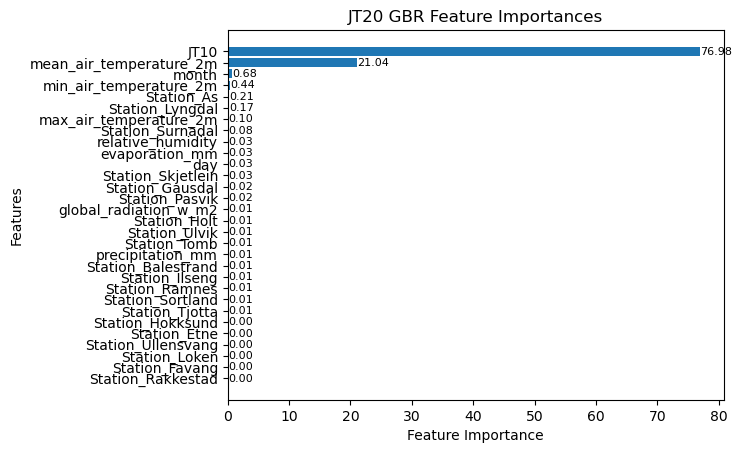

<Figure size 1200x600 with 0 Axes>

In [64]:
from sklearn.inspection import permutation_importance
# Train your HistGradientBoostingRegressor model
JT20_ideal_gbr_model.fit(JT20_X_train_processed, JT20_Y_train)
# Calculate permutation importance
perm_importance = permutation_importance(JT20_ideal_gbr_model, JT20_X_train_processed, JT20_Y_train, n_repeats=10, random_state=42)
# Get the feature importances
feature_importances = perm_importance.importances_mean
# Calculate total importance
total_importance = feature_importances.sum()
# Normalize feature importances
normalized_importances = feature_importances / total_importance
# Convert to percentage
importance_percentages = normalized_importances * 100
plot_features(all_column_names, importance_percentages, 'images/IMT_JT20_feature_analysis.png', 'JT20 GBR Feature Importances', 30)

#### NOTE:The feature importance analysis for our HistGradientBoost model shows that the 99.31% (ideal gbr model) 99.23%(default gbr model) of the soil temperature at 20cm can be predicted from the dataset disregarding the station type.

## 2.9. Backward Attribute Selection

#### To check if the important features from our dataset can be used to train our model, we need to do the same process we have done before with only the new important features considered.

In [65]:
# Generate the dataset of the two important columns and the target variable
# Initialize the random seed
np.random.seed(42)
selected_columns = ['JT10','mean_air_temperature_2m', 'month', 'min_air_temperature_2m', 'max_air_temperature_2m', 'relative_humidity', 'day','JT20']
JT20_dataset_important_features = dataset_normalized[selected_columns]
# Split the dataset into train and validation set
# Let us shuffle the entire dataset so that it is randomly arranged
JT20_dataset_shuffled = JT20_dataset_important_features.sample(frac=1)
# Split the dataset in to features (independent variables) and labels(dependent variable = target_soil_temperature_20cm )
JT20_X = JT20_dataset_shuffled.drop("JT20", axis=1)
JT20_Y = JT20_dataset_shuffled["JT20"]
# Then split into train, validation and test sets
train_split = round(0.7*len(JT20_dataset_shuffled)) # 70% for train set
valid_split = round(train_split + 0.15*len(JT20_dataset_shuffled))
JT20_X_train_3, JT20_Y_train_3 = JT20_X[:train_split], JT20_Y[:train_split]
JT20_X_valid_3, JT20_Y_valid_3 =JT20_X[train_split:valid_split], JT20_Y[train_split:valid_split]
JT20_X_test_3, JT20_Y_test_3 = JT20_X[valid_split:], JT20_Y[valid_split:]

# Save the JT20_X_test data to csv for future use
JT20_X_test_3.to_csv("data/IMT_JT20_optimized_test_data.csv", index=False)
print("JT20 Dataset with Important Features: \n")
JT20_dataset_important_features

JT20 Dataset with Important Features: 



,JT10,mean_air_temperature_2m,month,min_air_temperature_2m,max_air_temperature_2m,relative_humidity,day,JT20
0,-1.645751,-4.420780,-1.50711,-4.342358,-3.893006,-0.176504,-1.675206,-1.599584
1,-1.645751,-3.709757,-1.50711,-4.108257,-3.464326,-0.273184,-1.561878,-1.599584
2,-1.645751,-2.983277,-1.50711,-2.610010,-2.717593,0.149793,-1.448549,-1.599584
3,-1.661912,-2.859621,-1.50711,-2.516369,-2.496338,0.536514,-1.335221,-1.599584
4,-1.661912,-2.797793,-1.50711,-2.344695,-2.842048,1.116597,-1.221893,-1.599584
...,...,...,...,...,...,...,...,...
41224,-0.110374,0.185413,1.50889,0.589372,-0.283795,-0.514885,1.157998,-0.030927
41225,-0.239669,-0.046442,1.50889,0.199204,-0.352937,-0.375907,1.271327,-0.113488
41226,-0.304316,-0.139184,1.50889,-0.144145,-0.256138,-0.097951,1.384655,-0.196049
41227,-0.271993,-0.046442,1.50889,0.355271,-0.339108,-0.279227,1.497983,-0.196049


In [66]:
# Fit the RF regressor model
# The most ideal hyperparameters are
JT20_ideal_gbr_model_3 = HistGradientBoostingRegressor(early_stopping = True, 
                                                    l2_regularization= 1.0, 
                                                    learning_rate=0.1, 
                                                    max_bins= 255, 
                                                    max_depth= 7, 
                                                    max_iter=300, 
                                                    min_samples_leaf=5, 
                                                    n_iter_no_change=10, 
                                                    validation_fraction=0.1
                                                    )
JT20_ideal_gbr_model_3.fit(JT20_X_train_3, JT20_Y_train_3);

In [67]:
# Show the scores
show_scores(JT20_ideal_gbr_model_3, JT20_X_train_3, JT20_X_valid_3, JT20_Y_train_3, JT20_Y_valid_3)

{'Training Set R^2 Score': 0.9916940804524732,
 'Validation Set R^2 Score': 0.987694053619959,
 'Training Set MAE': 0.050853336179626236,
 'Validation Set MAE': 0.05509277083480277,
 'Training Set MSE': 0.008303347532855184,
 'Validation Set MSE': 0.012341743586289564,
 'Training Set Median Absolute Error': 0.03145770327767483,
 'Validation Set Median Absolute Error': 0.032815346450563054,
 'Training Set MA Percentage Error': 0.26036538684994087,
 'Validation Set MA Percentage Error': 0.39339887090962194,
 'Training Set Max Error': 2.7210704169966915,
 'Validation Set Max Error': 2.5013219288998316,
 'Training Set Explained Variance Score': 0.9916942017059388,
 'Validation Set Explained Variance Score': 0.9876941138801063}

In [68]:
# Predict the target JT20 values from the test set
JT20_Y_test_3_preds = JT20_ideal_gbr_model_3.predict(JT20_X_test_3)
JT20_Y_test_3_preds

array([ 0.80865443,  0.63731602,  0.65309335, ...,  0.49988756,
       -0.22798048,  0.6328814 ])

## 2.9. Visualization of original and predicted JT20 values (Blue + Red = Purple)

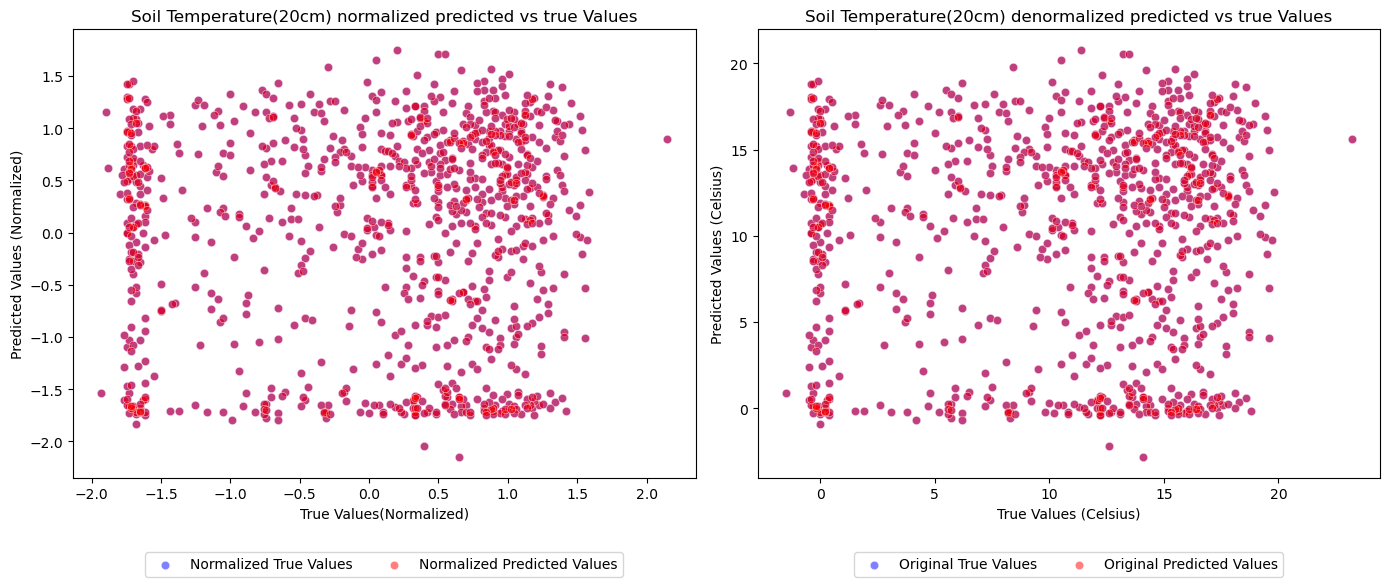

In [69]:
# Compare and Plot the predicted (JT20_Y_preds) and true (J20_JT20_Y_test) traget values
JT20_r2_score = r2_score(JT20_Y_test_3, JT20_Y_test_3_preds)
JT20_mae = mean_absolute_error( JT20_Y_test_3, JT20_Y_test_3_preds)
JT20_mse = mean_squared_error( JT20_Y_test_3, JT20_Y_test_3_preds)
# Convert pandas Series to numpy array
JT20_Y_test_preds_series = pd.Series( JT20_Y_test_3_preds)
JT20_normalized_df = pd.DataFrame({'Normalized True Values': JT20_Y_test_3, 'Normalized Predicted Values': JT20_Y_test_preds_series})

# Create the denormalized JT20 dataframe by using the denormalized outlier filtered original dataset
JT20_denormalized_df = pd.DataFrame({'Original True Values': reverse_normalization(dataset_copied, 'JT20', JT20_Y_test_3), 'Original Predicted Values': reverse_normalization(dataset_copied, 'JT20', JT20_Y_test_preds_series)})
# Create a figure with two subplots in one row and two columns
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Scatter plot for true values
sns.scatterplot(data=JT20_normalized_df, x='Normalized True Values', y='Normalized Predicted Values', color='blue', label='Normalized True Values', alpha=0.5, ax=axes[0])

# Scatter plot for predicted values
sns.scatterplot(data=JT20_normalized_df, x='Normalized True Values', y='Normalized Predicted Values', color='red', label='Normalized Predicted Values', alpha=0.5, ax=axes[0])

# Scatter plot for denormalized true values
sns.scatterplot(data=JT20_denormalized_df, x='Original True Values', y='Original Predicted Values', color='blue', label='Original True Values', alpha=0.5, ax=axes[1])

# Scatter plot for denormalized predicted values
sns.scatterplot(data=JT20_denormalized_df, x='Original True Values', y='Original Predicted Values', color='red', label='Original Predicted Values', alpha=0.5, ax=axes[1])

# Set titles and labels for each subplot
axes[0].set_title('Soil Temperature(20cm) normalized predicted vs true Values')
axes[0].set_xlabel('True Values(Normalized)')
axes[0].set_ylabel('Predicted Values (Normalized)')
axes[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)

axes[1].set_title('Soil Temperature(20cm) denormalized predicted vs true Values')
axes[1].set_xlabel('True Values (Celsius)')
axes[1].set_ylabel('Predicted Values (Celsius)')
# Move legend to the upper axis
axes[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)

# Add annotations on hover for each subplot
mplcursors.cursor(hover=True)

# Adjust layout
plt.tight_layout()
# Save the figure to a file (e.g., PNG, PDF, etc.)
plt.savefig('images/IMT_True_values_vs_predicted_values_JT20.png')  # Save as PNG format
plt.show()

#### Note: The above scatter plots show that the true values and predicted values almost overlap which means the error is very small and the colors are mixing up and become indistinguishable

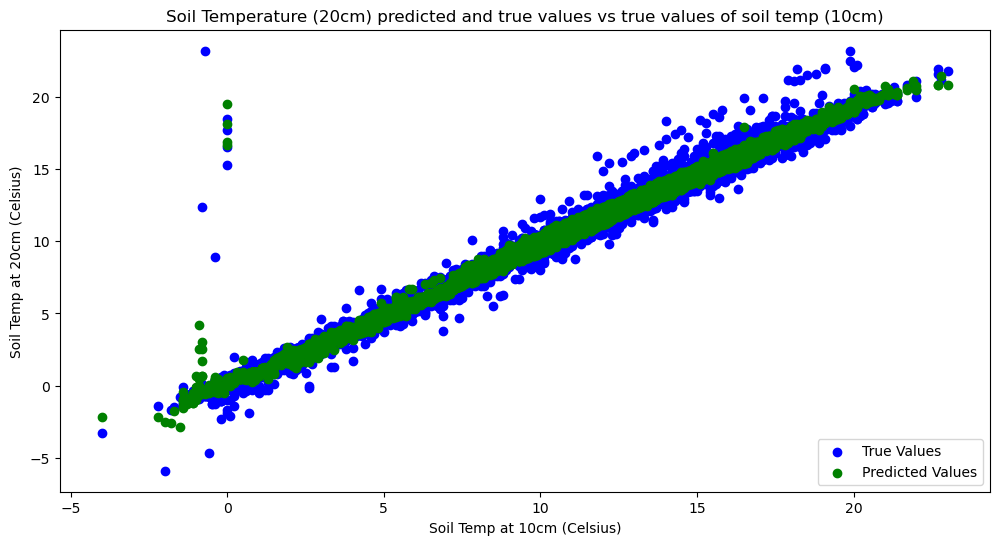

In [70]:
# Reverse the normalized JT50 values in the X test set
JT10_denormalized = reverse_normalization(dataset_copied, 'JT10', JT20_X_test_3['JT10'])
# Reverse the normalized JT100 values in the Y test set
JT20_Y_test_denormalized = reverse_normalization(dataset_copied, 'JT20', JT20_Y_test_3)
# Reverse the normalized predicted JT20 values in the Y test set
JT20_Y_preds_denormalized = reverse_normalization(dataset_copied, 'JT20', JT20_Y_test_preds_series)
# Make the original and predicted series to have the same index
JT20_Y_preds_denormalized.index = JT20_Y_test_denormalized.index
JT10_denormalized.index = JT20_Y_test_denormalized.index

# Create true and predicted values dataframe for saving
JT20_true_and_predicted_values = pd.DataFrame({'JT10 Value':JT10_denormalized,'JT20 True Value': JT20_Y_test_denormalized, 'JT20 Predicted Value': JT20_Y_preds_denormalized})
# Save the True and Predicted Values to csv for further comparison
JT20_true_and_predicted_values.to_csv('data/ IMT_JT20_Y_test_true_and_predicted_values.csv', index=False)
plt.figure(figsize=(12, 6)) 
plt.scatter(JT10_denormalized, JT20_Y_test_denormalized, color='blue', label='True Values') #plotting real points
plt.scatter(JT10_denormalized, JT20_Y_preds_denormalized , color='green', label='Predicted Values') #plotting for predicted points
   
plt.title("Soil Temperature (20cm) predicted and true values vs true values of soil temp (10cm)")
plt.xlabel('Soil Temp at 10cm (Celsius)')
plt.ylabel('Soil Temp at 20cm (Celsius)')
# Add legend
plt.legend(loc="lower right")
# Save the figure to a file (e.g., PNG, PDF, etc.)
plt.savefig('images/IMT_JT20_true_predicted_values_vs_JT10.png')  # Save as PNG format
plt.show()

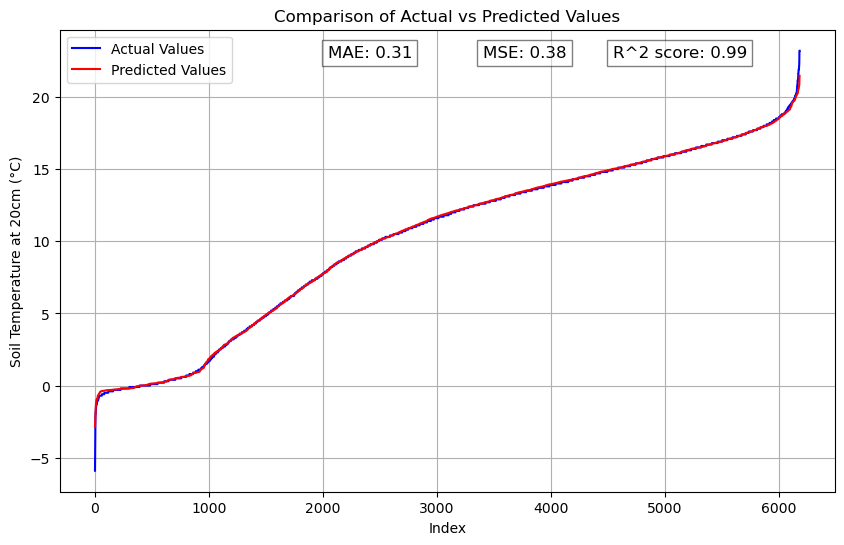

In [71]:
# Sort Y_test and Y_preds in ascending order and reset indices
JT20_Y_test_sorted = JT20_Y_test_denormalized.sort_values().reset_index(drop=True)
JT20_Y_preds_sorted = JT20_Y_preds_denormalized[JT20_Y_test_denormalized.index].sort_values().reset_index(drop=True)

# Calculate mean absolute error
JT20_mae = mean_absolute_error(JT20_Y_test_denormalized, JT20_Y_preds_denormalized)
# Calculate mean squared error
JT20_mse = mean_squared_error(JT20_Y_test_denormalized, JT20_Y_preds_denormalized)
# Calculate the R^2 score
JT20_r2_score = r2_score(JT20_Y_test_denormalized, JT20_Y_preds_denormalized)
# Plot the sorted values
plt.figure(figsize=(10, 6))
plt.plot(JT20_Y_test_sorted.index, JT20_Y_test_sorted, color='blue', label='Actual Values')
plt.plot(JT20_Y_preds_sorted.index, JT20_Y_preds_sorted, color='red', label='Predicted Values')
# Display the mean absolute error as text annotation
plt.text(0.4, 0.95, f'MAE: {JT20_mae:.2f}', ha='center', va='center', transform=plt.gca().transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
plt.text(0.6, 0.95, f'MSE: {JT20_mse:.2f}', ha='center', va='center', transform=plt.gca().transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
plt.text(0.8, 0.95, f'R^2 score: {JT20_r2_score:.2f}', ha='center', va='center', transform=plt.gca().transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
plt.xlabel('Index')
plt.ylabel('Soil Temperature at 20cm (°C)')
plt.title('Comparison of Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.savefig('images/JT20_true_predicted_values.png')  # Save as PNG format
plt.show()

### Note: The scatter plot above shows that as the JT10 temperature becomes more negative the JT20 prediction capacity becomes weaker because the model is not well trained with higher negative soil temperatures as our training dataset doesn't have enough higher negative temeperatures values.

In [72]:
JT20_Y_preds_denormalized

27710    15.084622
5629     14.046974
37429    14.142523
26019     8.679057
3681      8.404389
           ...    
6265     10.555878
11284     0.132526
38158    13.214688
860       8.806619
15795    14.020117
Length: 6185, dtype: float64

In [73]:
 JT20_Y_test_denormalized

27710    15.2
5629     14.1
37429    13.9
26019     8.8
3681      8.1
         ... 
6265     10.6
11284     0.1
38158    12.6
860       8.5
15795    13.4
Name: JT20, Length: 6185, dtype: float64

In [74]:
# # Reverse the normalized JT50 values in the X test set
# JT50_denormalized = reverse_normalization(dataset_copied, 'JT50', JT100_X_test['JT50'])
# X_grid = np.arange(min(JT50_denormalized),max( JT100_X_test),0.01)
# X_grid = X_grid.reshape(len(X_grid),1) 

# # Reverse the normalized JT100 values in the Y test set
# JT100_Y_test_denormalized = reverse_normalization(dataset_copied, 'JT100', JT100_Y_test)
   
# plt.scatter(X, JT100_Y_test_denormalized, color='blue') #plotting real points
# plt.plot(X_grid, regressor.predict(X_grid),color='green') #plotting for predict points
   
# plt.title("Random Forest Regression Results")
# plt.xlabel('Position level')
# plt.ylabel('Salary')
# plt.show()

### Visualizing a Single Decision Tree from the Random Forest Model
##### NB: Be patient this may take time. Uncomment and run it to see how the decision tree works but it may be difficult to see the trees due to size

In [75]:
# %%time
# from sklearn.tree import plot_tree
 
# # Let's take the ideal rf model trained
# # Let us pick on decision tree from the many estimators, e.g., the first tree (index 0)
# tree_to_plot = JT100_ideal_rf_model.estimators_[0]
 
# # Plot the decision tree
# plt.figure(figsize=(20, 10))
# plot_tree(tree_to_plot, feature_names=JT100_dataset_shuffled.columns.tolist(), filled=True, rounded=True, fontsize=10)
# plt.title("Decision Tree from Random Forest")
# plt.show()

### Define a function to calculate the minimum and maximum resolution of a dataset

In [76]:
# Define a function that calculates the minimum resolution and maximum difference of a dataframe column
def calculate_resolution_for_column(df, column_name):
    # Extract the specified column
    column_values = df[column_name]

    # Find the minimum and maximum values
    min_value = column_values.min()
    max_value = column_values.max()

    # Sort the values
    sorted_values = column_values.sort_values().values

    # Calculate the differences between adjacent values
    differences = sorted_values[1:] - sorted_values[:-1]

    # Find the smallest non-zero difference
    min_resolution = min(differences[differences > 0], default=None)

    # Find the largest difference
    max_resolution = max(differences)

    return min_resolution, max_resolution
min_resolution, max_resolution = calculate_resolution_for_column(dataset_copied, 'JT20')
print('Minimum JT20 Resolution:', min_resolution, '\n Maximum Difference: ', max_resolution)

Minimum JT20 Resolution: 0.09999999999999787 
 Maximum Difference:  0.5999999999999996


# 3. Prediction of the soil temperatures at different depths
## 3.1. Define a custom prediction function 
### The custom function can be adapted for all predicitons of soil temperatures at different soil depths

In [77]:
# Let us first predict the soil temperature at 50cm from all other independent variables except the JT100 (soil temp at 100cm)
# Define X_train_2 outside of the function
X_train_2 = None  
X_test_2 = None 
Y_train_2 = None
Y_test_2 = None
def predict_feature(dataset_df, features_dropped, feature, model_type):
    new_dataset_normalized = dataset_df.drop(features_dropped, axis=1)
    X_f = new_dataset_normalized.drop(feature, axis=1)
    Y_f = new_dataset_normalized[feature]
    # Split the X and Y data in to train and test data
    X_train_2, X_test_2, Y_train_2, Y_test_2 = train_test_split(X_f, Y_f, test_size=0.2)
    # Identify categorical features
    categorical_features = ["Station"]
    # Identify numeric features (assuming the rest are numeric)
    numeric_features = [col for col in dataset_df.columns if col not in categorical_features + ['JT20', 'ID']]
    if(feature == 'JT10'):
        numeric_features.remove('JT10')
    # Create preprocessing pipeline
    X_preprocessor = ColumnTransformer(
        transformers=[
        ('num', 'passthrough', numeric_features),  # scale numeric features
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)  # one-hot encode categorical features
    ])
    # X_f_processed = preprocessor.fit_transform(X_f)
    X_train_2_processed = X_preprocessor.fit_transform(X_train_2)
    X_test_2_processed = X_preprocessor.transform(X_test_2)
    model_type.fit(X_train_2_processed, Y_train_2)
    scores = show_scores(model_type, X_train_2_processed, X_test_2_processed, Y_train_2, Y_test_2)
    print(scores)
    return X_train_2_processed, X_test_2_processed, Y_train_2, Y_test_2

## 3.2. Prediction of Soil temperature at 10cm 
#### Consider all other independent variables in the original dataset with the JT20 (soil temp at 20cm) dropped out
#### Use the original dataset with outliers to see the effect of the outliers on the modelling
#### NB: This may take time. Be Patient!

In [78]:
%%time
# Instantiate the custom predict_feature function to predict the JT10 values
# Random Forest Regressor
print("Random Forest Metrics JT10:")
JT10_X_train_2, JT10_X_test_2, JT50_Y_train_2, JT50_Y_test_2 = predict_feature(dataset_normalized, ['JT20','ID'], 'JT10', JT10_rf_model)
print('\n')
# Gradient Boosting Regressor
print("Gradient Boosting Regressor Metrics JT10:")
predict_feature(dataset_normalized, ['JT20','ID'], 'JT10', JT10_gbr_model)
print('\n')
# Ridge Regressor
print("Ridge Regressor Metrics JT10:")
predict_feature(dataset_normalized, ['JT20','ID'], 'JT10', JT10_rg_model)
print('\n')
# Lasso Regressor
print("Lasso Regressor Metrics JT10:")
predict_feature(dataset_normalized, ['JT20','ID'], 'JT10', JT10_la_model)
print('\n')
# ElasticNet Regressor
print("ElasticNet Regressor Metrics JT10:")
predict_feature(dataset_normalized, ['JT20','ID'], 'JT10', JT10_en_model)
print('\n')
# SVR linear Regressor
print("SVR linear Regressor Metrics JT10:")
predict_feature(dataset_normalized, ['JT20','ID'], 'JT10', JT10_svrl_model)
print('\n')
# SVR rbf Regressor
print("SVR rbf Regressor Metrics JT10:")
predict_feature(dataset_normalized, ['JT20','ID'], 'JT10', JT10_svrr_model)
print('\n')

Random Forest Metrics JT10:
{'Training Set R^2 Score': 0.9954354533417997, 'Validation Set R^2 Score': 0.9684712881617976, 'Training Set MAE': 0.04825911815597928, 'Validation Set MAE': 0.13036277042904165, 'Training Set MSE': 0.0045539103905462164, 'Validation Set MSE': 0.031817824232651996, 'Training Set Median Absolute Error': 0.03587932497574897, 'Validation Set Median Absolute Error': 0.09810247864990862, 'Training Set MA Percentage Error': 0.22736162950980482, 'Validation Set MA Percentage Error': 0.6429661485096684, 'Training Set Max Error': 1.0758948935295507, 'Validation Set Max Error': 2.464360122658643, 'Training Set Explained Variance Score': 0.9954365723410018, 'Validation Set Explained Variance Score': 0.968487000552775}


Gradient Boosting Regressor Metrics JT10:
{'Training Set R^2 Score': 0.9725716446321382, 'Validation Set R^2 Score': 0.9670826551380288, 'Training Set MAE': 0.12284374286396547, 'Validation Set MAE': 0.1308820327031985, 'Training Set MSE': 0.02735573423

## 3.3. Predictions of other soil temperatures (100cm, 50cm, 20cm, 10cm, 5cm, 2cm)
#### As the RandomForestRegressor is working good for the prediction let us consider RF to predict the soil temperatures.

In [79]:
# # Instantiate the custom predict_feature function to predict the JT2, JT5, JT10, JT20 values
# # Random Forest Regressor JT20
# print("Random Forest Metrics JT20:")
# JT20_X_train_2, JT20_X_test_2, JT20_Y_train_2, JT20_Y_test_2 = predict_feature(dataset_normalized_outlier_filtered, ['ID'], 'JT50', JT20_rf_model)
# print('\n')
# # Random Forest Regressor JT50
# print("Random Forest Metrics JT50:")
# JT50_X_train_2, JT50_X_test_2, JT50_Y_train_2, JT50_Y_test_2 = predict_feature(dataset_normalized_outlier_filtered, ['JT20','ID'], 'JT50', JT50_rf_model)
# print('\n')
# # Random Forest Regressor JT20
# print("Random Forest Metrics JT20:")
# JT20_X_train_2, JT20_X_test_2, JT20_Y_train_2, JT20_Y_test_2 = predict_feature(dataset_normalized_outlier_filtered, ['JT20','JT50','ID'], 'JT20', JT20_rf_model)
# print('\n')
# # Random Forest Regressor JT10
# print("Random Forest Metrics JT10:")
# JT10_X_train_2, JT10_X_test_2, JT10_Y_train_2, JT10_Y_test_2 = predict_feature(dataset_normalized_outlier_filtered, ['JT20','JT50','JT20','ID'], 'JT10', JT10_rf_model)
# print('\n')
# # Random Forest Regressor JT5
# print("Random Forest Metrics JT5:")
# JT5_X_train_2, JT5_X_test_2, JT5_Y_train_2, JT5_Y_test_2 = predict_feature(dataset_normalized_outlier_filtered, ['JT20','JT50','JT20','JT10','ID'], 'JT5', JT5_rf_model)
# print('\n')
# # Random Forest Regressor JT2
# print("Random Forest Metrics JT2:")
# JT2_X_train_2, JT2_X_test_2, JT2_Y_train_2, JT2_Y_test_2 = predict_feature(dataset_normalized_outlier_filtered, ['JT20','JT50','JT20','JT10','JT5','ID'], 'JT2', JT2_rf_model)
# print('\n')

### Let's visualize the feature importance for each of the soil temepratures JT2, JT5, JT10, JT20, JT50
#### JT2 Feature Importance analysis

In [80]:
# # Feature parameter analysis for JT2
# JT2_X_train_2, JT2_X_test_2, JT2_Y_train_2, JT2_Y_test_2 = predict_feature(dataset_normalized_outlier_filtered, ['JT100','JT50','JT20','JT10','JT5','ID'], 'JT2', JT2_rf_model)
# plot_features(JT2_X_train_2.columns, JT2_rf_model.feature_importances_, 'images/JT2_feature_analysis.png','JT2 GBR Feature Importances', 30 )

#### JT5 Feature Importance analysis

In [81]:
# # Feature parameter analysis for JT5
# JT5_X_train_2, JT5_X_test_2, JT5_Y_train_2, JT5_Y_test_2 = predict_feature(dataset_normalized_outlier_filtered, ['JT100','JT50','JT20','JT10','ID'], 'JT5', JT5_rf_model)
# plot_features(JT5_X_train_2.columns, JT5_rf_model.feature_importances_, 'images/JT5_feature_analysis.png','JT5 GBR Feature Importances', 30)

#### JT10 Feature Importance analysis

{'Training Set R^2 Score': 0.971765592564289, 'Validation Set R^2 Score': 0.9695579321057979, 'Training Set MAE': 0.12421647226552981, 'Validation Set MAE': 0.12939884510582464, 'Training Set MSE': 0.028195654714301466, 'Validation Set MSE': 0.030603569120120456, 'Training Set Median Absolute Error': 0.09791580511325848, 'Validation Set Median Absolute Error': 0.10289817509042092, 'Training Set MA Percentage Error': 0.5509223189171011, 'Validation Set MA Percentage Error': 0.5685089964345562, 'Training Set Max Error': 2.528057979799867, 'Validation Set Max Error': 2.2928029427865253, 'Training Set Explained Variance Score': 0.9717657055679509, 'Validation Set Explained Variance Score': 0.9695671372620603}


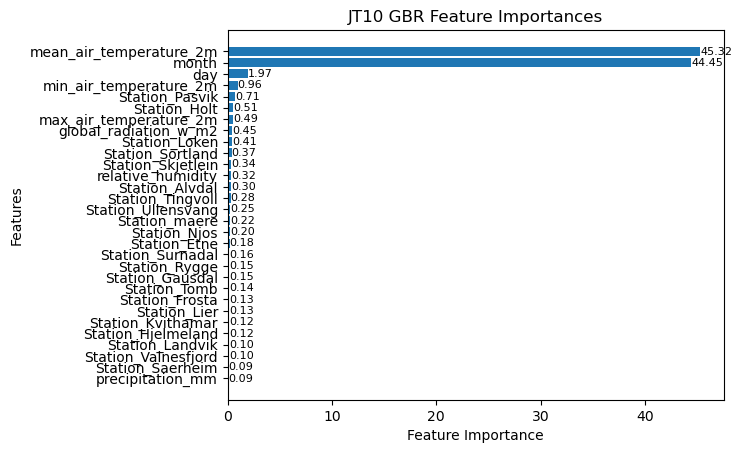

<Figure size 1200x600 with 0 Axes>

In [82]:
# Feature parameter analysis for JT10
from sklearn.inspection import permutation_importance
JT10_X_train, JT10_X_test, JT10_Y_train, JT10_Y_test = predict_feature(dataset_normalized, ['JT20', 'ID'], 'JT10', JT10_gbr_model)
# Calculate permutation importance
perm_importance = permutation_importance(JT10_gbr_model, JT10_X_train, JT10_Y_train, n_repeats=10, random_state=42)
# Get the feature importances
feature_importances = perm_importance.importances_mean
# Calculate total importance
total_importance = feature_importances.sum()
# Normalize feature importances
normalized_importances = feature_importances / total_importance
# Convert to percentage
JT10_importance_percentages = normalized_importances * 100
column_features = list(all_column_names)  # Create a copy of the original list
column_features.remove('JT10')
plot_features(column_features, JT10_importance_percentages, 'images/IMT_JT10_feature_analysis.png', 'JT10 GBR Feature Importances', 30)

#### The feature analysis for JT10 above shows that 92.9% of the features are

#### JT20 Feature Importance analysis

{'Training Set R^2 Score': 0.9970722768369145, 'Validation Set R^2 Score': 0.9952618502602845, 'Training Set MAE': 0.03101369039864662, 'Validation Set MAE': 0.034435896128473815, 'Training Set MSE': 0.0029145558277624615, 'Validation Set MSE': 0.004821352313440185, 'Training Set Median Absolute Error': 0.021220947981391625, 'Validation Set Median Absolute Error': 0.0220403944535586, 'Training Set MA Percentage Error': 0.16974718515440915, 'Validation Set MA Percentage Error': 0.18881565028353522, 'Training Set Max Error': 2.193482211148602, 'Validation Set Max Error': 2.9743550671002534, 'Training Set Explained Variance Score': 0.997072285307955, 'Validation Set Explained Variance Score': 0.9952625652795472}


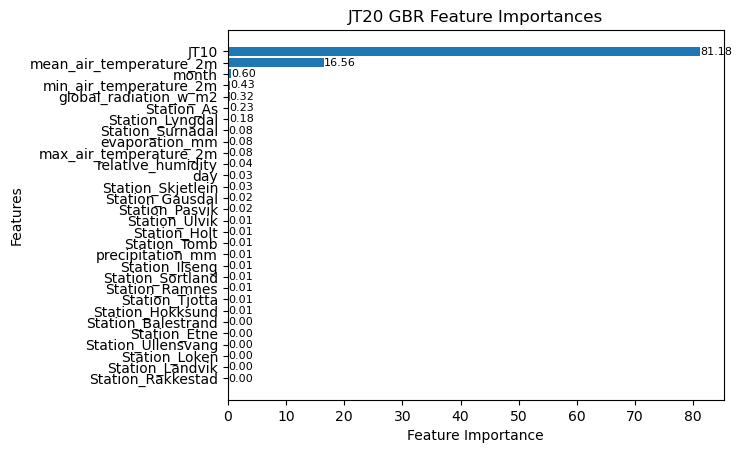

<Figure size 1200x600 with 0 Axes>

In [83]:
# Feature parameter analysis for JT20
# Feature parameter analysis for JT20
from sklearn.inspection import permutation_importance
JT20_ideal_gbr_feature_model = HistGradientBoostingRegressor(early_stopping = True, 
                                                    l2_regularization= 1.0, 
                                                    learning_rate=0.1, 
                                                    max_bins= 255, 
                                                    max_depth= 7, 
                                                    max_iter=300, 
                                                    min_samples_leaf=5, 
                                                    n_iter_no_change=10, 
                                                    validation_fraction=0.1
                                                    )
JT20_X_train, JT20_X_test, JT20_Y_train, JT20_Y_test = predict_feature(dataset_normalized, ['ID'], 'JT20', JT20_ideal_gbr_feature_model)
# Calculate permutation importance
perm_importance = permutation_importance(JT20_ideal_gbr_feature_model, JT20_X_train, JT20_Y_train, n_repeats=20, random_state=42)
# Get the feature importances
feature_importances = perm_importance.importances_mean
# Calculate total importance
total_importance = feature_importances.sum()
# Normalize feature importances
normalized_importances = feature_importances / total_importance
# Convert to percentage
JT20_importance_percentages = normalized_importances * 100
plot_features(all_column_names, JT20_importance_percentages, 'images/IMT_JT20_feature_analysis.png', 'JT20 GBR Feature Importances', 30)


#### JT50 Feature Importance analysis

In [84]:
# # Feature parameter analysis for JT50
# JT50_X_train_2, JT50_X_test_2, JT50_Y_train_2, JT50_Y_test_2 = predict_feature(dataset_normalized_outlier_filtered, ['JT100','ID'], 'JT50', JT50_rf_model)
# plot_features(JT50_X_train_2.columns, JT50_rf_model.feature_importances_, 'images/JT50_feature_analysis.png''JT50 GBR Feature Importances', 30)

In [85]:
JT20_X_train

array([[ 0.58729566,  0.76104636,  0.64270767, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.07721389,  0.15238347, -0.11785413, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.44818245,  0.87029354,  0.17254219, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.66472325, -0.90887488, -0.42207886, ...,  0.        ,
         0.        ,  0.        ],
       [-1.91674216, -1.48632429, -2.205942  , ...,  0.        ,
         0.        ,  0.        ],
       [-0.81929348, -0.75280748, -0.96138632, ...,  0.        ,
         0.        ,  0.        ]])

#### Feature Importance Conclusion: From the Feature Importance Analysis, the prediction of the soil temperature at a certain depth depeneds majorly on the depth above it and the soil temperature at 2cm, depends on the mean air temperature (92%), evaporation (3%), month(2%), day, heat flux and snow depth (three of them combined less than 3%)
#### If we predict the soil temperature at 2cm from mean air temperature, evaporation, month, day, heat flux and snow depth, we can predict the other soil temperatures at different depths.

### Learning Curves
#### To check if the model is not overfitting, we can evaluate the learning curve for an increasing training data set size. The following chart shows how the training set and validation set MAE and MSE change with respect to change of training dataset size. 

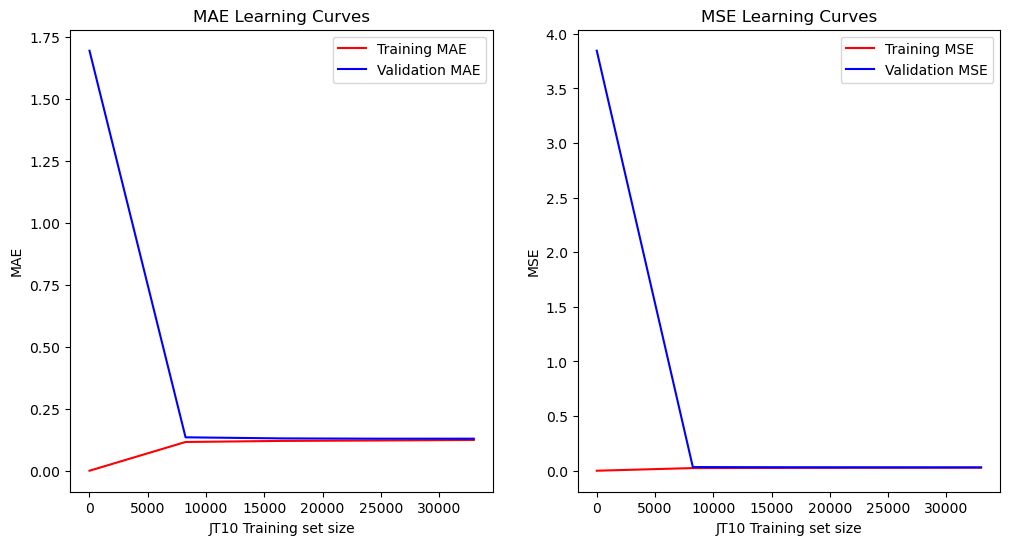

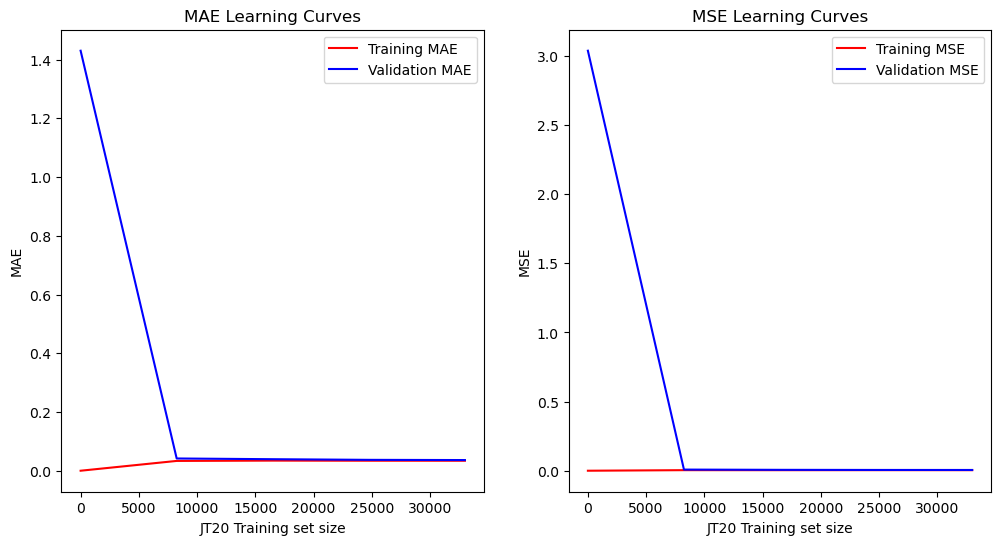

CPU times: total: 50.4 s
Wall time: 7.76 s


In [86]:
%%time
def plot_learning_curves(model, X_train, Y_train, X_valid, Y_valid, feature):
    train_errors_mae, val_errors_mae = [], []
    train_errors_mse, val_errors_mse = [], []
    
    # Use different sizes of training subsets
    subset_sizes = np.linspace(1, len(X_train), 5, dtype=int)    
    for m in subset_sizes:
        model.fit(X_train[:m], Y_train[:m])
        Y_train_predict = model.predict(X_train[:m])
        Y_valid_predict = model.predict(X_valid)
        
        train_errors_mae.append(mean_absolute_error(Y_train[:m], Y_train_predict))
        val_errors_mae.append(mean_absolute_error(Y_valid, Y_valid_predict))
        
        train_errors_mse.append(mean_squared_error(Y_train[:m], Y_train_predict))
        val_errors_mse.append(mean_squared_error(Y_valid, Y_valid_predict))
        
    plt.figure(figsize=(12, 6))
    
    # Plot MAE learning curves
    plt.subplot(1, 2, 1)
    plt.plot(subset_sizes, train_errors_mae, "r-", label="Training MAE")
    plt.plot(subset_sizes, val_errors_mae, "b-", label="Validation MAE")
    plt.legend(loc="upper right")
    plt.xlabel(f"{feature} Training set size")
    plt.ylabel("MAE")
    plt.title("MAE Learning Curves")
    
    # Plot MSE learning curves
    plt.subplot(1, 2, 2)
    plt.plot(subset_sizes, train_errors_mse, "r-", label="Training MSE")
    plt.plot(subset_sizes, val_errors_mse, "b-", label="Validation MSE")
    plt.legend(loc="upper right")
    plt.xlabel(f"{feature} Training set size")
    plt.ylabel("MSE")
    plt.title("MSE Learning Curves")
    
    plt.show()

# Plot learning curves
# plot_learning_curves(JT2_rf_model, JT2_X_train_2, JT2_Y_train_2, JT2_X_test_2, JT2_Y_test_2, "JT2")
# plot_learning_curves(JT5_rf_model, JT5_X_train_2, JT5_Y_train_2, JT5_X_test_2, JT5_Y_test_2, "JT5")
plot_learning_curves(JT10_gbr_model, JT10_X_train, JT10_Y_train, JT10_X_test, JT10_Y_test, "JT10")
plot_learning_curves(JT20_gbr_model, JT20_X_train, JT20_Y_train, JT20_X_test, JT20_Y_test, "JT20")
# plot_learning_curves(JT50_rf_model, JT50_X_train_2, JT50_Y_train_2, JT50_X_test_2, JT50_Y_test_2, "JT50")
# plot_learning_curves(JT100_rf_model, JT100_X_train_2, JT100_Y_train_2, JT100_X_test_2, JT100_Y_test_2, "JT100")

### Learning Curve Results analysis
#### 1. MAE and MSE decreasing for validation Set: The decreasing trend of MAE and MSE for the validation set indicates that the model's performance improves as more data is provided for training. This suggests that the model is learning from the additional data and making more accurate predictions on unseen data.
#### 2. MAE and MSE Plateauing: Once a certain size of the training set is reached, both MAE and MSE plateau, indicating that providing more training data beyond this point does not significantly improve the model's performance on the validation set. This suggests that the model has learned as much as it can from the available data, and adding more data does not lead to substantial improvements
#### 3. Slow Slope of MSE for Training Set: The slow slope of MSE for the training set suggests that the model's performance on the training data is relatively stable even as more data is added. This indicates that the model is not suffering from high variance (overfitting) with respect to the training data.

### Advantages of Random Forest Regression
1. It is easy to use and less sensitive to the training data compared to the decision tree.
2. It is more accurate than the decision tree algorithm.
3. It is effective in handling large datasets that have many attributes.
4. It can handle missing data, outliers, and noisy features.
### Disadvantages of Random Forest Regression
1. The model can also be difficult to interpret.
2. This algorithm may require some domain expertise to choose the appropriate parameters like the number of decision trees, the maximum depth of each tree, and the number of features to consider at each split.
4. It is computationally expensive, especially for large datasets.
5. It may suffer from overfitting if the model is too complex or the number of decision trees is too high.
### The major issue of overfitting probability can be checked by
1. Splitting the dataset in to training, validation and test sets and the model performed well in all sets
2. Cross-validation performance of the model for different k-fold cross-validation helps us to see if the model is not overfitting and was checked that it is performing good.
3. Learning curves that show the model's performance (e.g., mean squared error or mean absolute error) on the training and validation sets as a function of the training set size. If the model's performance on the training set continues to improve while the performance on the validation set plateaus or worsens, it may be overfitting.
4. Feature Importance: Check the feature importances provided by the random forest model. If certain features have very high importance values while others have low or zero importance, it may indicate that the model is overfitting to those important feature.

# 4. Saving and loading a trained model

#### a. Using Pickle module

In [87]:
# Save the model you created to file
pickle.dump(JT20_rf_model, open("models/IMT_model_Temperature_20cm.pkl", "wb"))

In [88]:
# Load the saved model
loaded_pickle_model = pickle.load(open("models/IMT_model_Temperature_20cm.pkl", "rb"))

In [89]:
# Check the score
loaded_pickle_model.score(JT20_X_test, JT20_Y_test)

0.9980799134825897

In [90]:
# Check if the model loaded works
pickle_Y_preds = loaded_pickle_model.predict(JT20_X_test)
pickle_Y_preds

array([-1.37832084, -1.75050527, -1.14005015, ..., -1.6664583 ,
       -0.13379819,  1.33198761])

#### b. Using Joblib module
##### NB: Go for Joblib if the data used for modelling is large

In [91]:
# Save model to file
dump(JT20_rf_model, filename="models/IMT_model_Temperature_20cm_joblib.joblib");

In [92]:
# Import saved joblib model
loaded_joblib_model = load(filename="models/IMT_model_Temperature_20cm_joblib.joblib")

In [93]:
# Check the score and prediction
loaded_joblib_model.score(JT20_X_test, JT20_Y_test)

0.9980799134825897

In [94]:
loaded_joblib_model.predict(JT20_X_test)

array([-1.37832084, -1.75050527, -1.14005015, ..., -1.6664583 ,
       -0.13379819,  1.33198761])

# 5. Forecat of Soil Temperature at different depths
### Let's check if it possible to use the RF model trained above to forecast the soil temperatures at different depths from the forecasted evaporation, data sources

### Let's bring all Code in one

==================== The Random Forest Evaluation Metrics Results For JT20 =======================

Out of Bag Score:  0.9937944216760468
{'Training Set R^2 Score': 0.9991210087083452, 'Validation Set R^2 Score': 0.9930788470926358, 'Training Set MAE': 0.014380813097713096, 'Validation Set MAE': 0.03908058699870633, 'Training Set MSE': 0.0008787199172507269, 'Validation Set MSE': 0.006941291758613193, 'Training Set Median Absolute Error': 0.009068500000000451, 'Validation Set Median Absolute Error': 0.024595500000000187, 'Training Set MA Percentage Error': 0.07789004467428436, 'Validation Set MA Percentage Error': 0.28562526128788646, 'Training Set Max Error': 1.574281, 'Validation Set Max Error': 2.3237639999999997, 'Training Set Explained Variance Score': 0.9991210115757828, 'Validation Set Explained Variance Score': 0.9930792589523605}

==================== The HistGradient Boosting Evaluation Metrics Results For JT20 =======================

{'Training Set R^2 Score': 0.99618783860

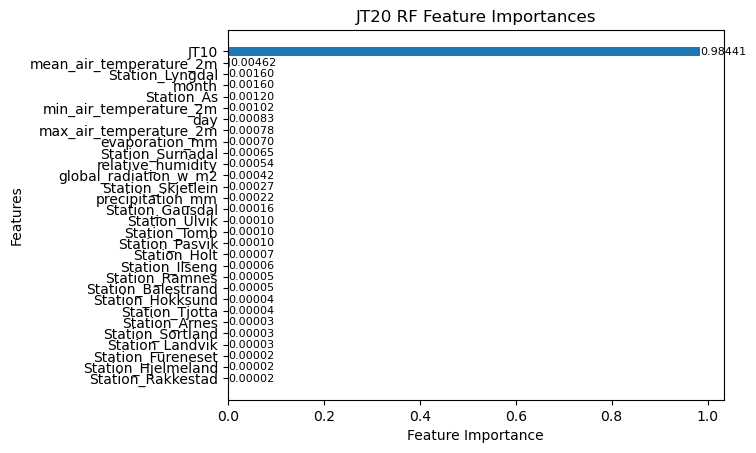

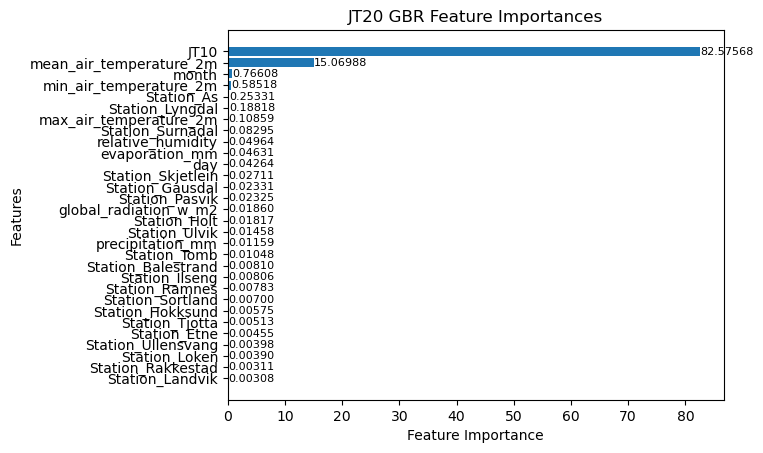

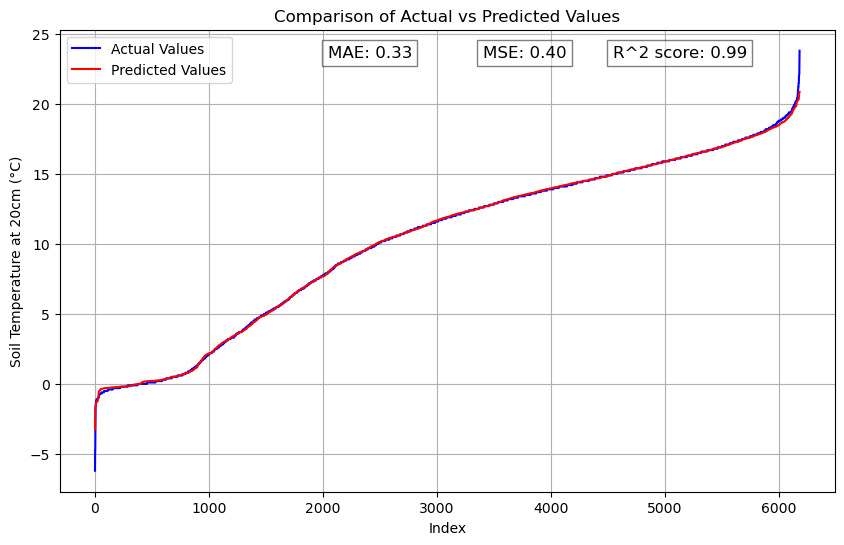

================================= Random Forest Metrics JT20 with all features denormalization considered ==============================

{'Training Set R^2 Score': 0.9991279491006787, 'Validation Set R^2 Score': 0.9935158256269286, 'Training Set MAE': 0.08573419640420821, 'Validation Set MAE': 0.23646834829008012, 'Training Set MSE': 0.031886922384258554, 'Validation Set MSE': 0.2406730831918506, 'Training Set Median Absolute Error': 0.05399999999998606, 'Validation Set Median Absolute Error': 0.1460000000000008, 'Training Set MA Percentage Error': 3515847157783.2207, 'Validation Set MA Percentage Error': 10124633748750.309, 'Training Set Max Error': 7.886000000000013, 'Validation Set Max Error': 14.698000000000002, 'Training Set Explained Variance Score': 0.9991279688082888, 'Validation Set Explained Variance Score': 0.9935159349156073}

================================= Gradient Boosting Regressor Metrics JT20 with all features denormalization considered ============================

array([15.3991182 , 14.03388574,  9.33294832, ..., 19.45931148,
       12.3947689 , 15.16831867])

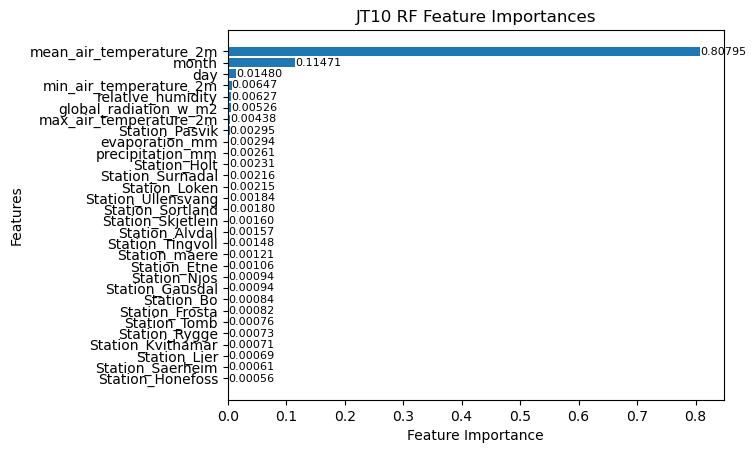

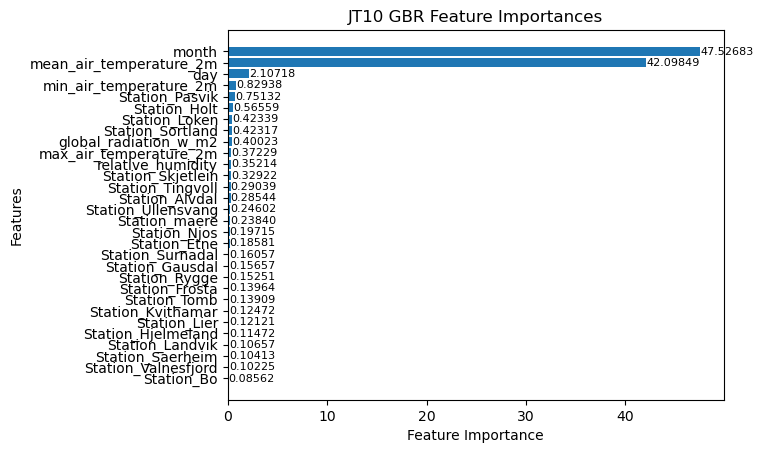

In [95]:
# Import Important modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import mplcursors
import pickle
from joblib import dump, load
from sklearn.model_selection import cross_val_score
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, median_absolute_error, max_error, explained_variance_score

# Initialize random seed
np.random.seed(42)
# Read CSV file
dataset = pd.read_csv("data/IMT_stations_nonempty.csv", low_memory=False)

# 1. Data Preprocessing stage =========================================

# Add a year, month and day columns by feature engineering to make manipulation of these easy
dataset['date'] = pd.to_datetime(dataset['date'])
dataset_copied = dataset.copy()
dataset_copied['year'] = dataset_copied['date'].dt.year
dataset_copied['month'] = dataset_copied['date'].dt.month
dataset_copied['day'] = dataset_copied['date'].dt.day

# # Filter rows where 'evaporation_mm' is less than or equal to 1 
# dataset_copied = dataset_copied[(dataset_copied['evaporation_mm'] <= 1) | (pd.isna(dataset_copied['evaporation_mm']))]

# # Calculate the mean for evaporation_mm considering only non-NaN values for each day and month
# mean_values = dataset_copied.groupby(['day', 'month'])['evaporation_mm'].apply(lambda x: x.dropna().mean()).reset_index(name='evaporation_mm_mean')

# # Merge mean_values with the original DataFrame to fill missing values
# dataset_copied = pd.merge(dataset_copied, mean_values, on=['day', 'month'], how='left')

# # Fill missing values for evaporation_mm with the mean values calculated for the specific range of years
# def fill_missing_evaporation(row):
#     if pd.isna(row['evaporation_mm']):
#         # Calculate the mean value for the specific range of years
#         filtered_means = mean_values[(mean_values['day'] == row['day']) & (mean_values['month'] == row['month'])]
#         mean_value = filtered_means['evaporation_mm_mean'].mean() if not filtered_means.empty else None
#         return mean_value
#     else:
#         return row['evaporation_mm']

# # Fill missing values for evaporation_mm with the mean values calculated for the specific range of years
# dataset_copied['evaporation_mm'] = dataset_copied.apply(fill_missing_evaporation, axis=1)
# # Drop auxiliary columns
# dataset_copied.drop('evaporation_mm_mean', axis=1, inplace=True)
# # Drop duplicates in case there are overlapping values from the merge
# dataset_copied.drop_duplicates(inplace=True)

# # Filter the dataframe to select rows where evaporation_mm is NaN
# nan_evaporation = dataset_copied[dataset_copied['evaporation_mm'].isna()]
# # Group by month and count NaN occurrenc
# nan_evaporation_counts = nan_evaporation.groupby('month').size()

# # Fill the missing evaporation_mm values by zero
# dataset_copied['evaporation_mm'] = dataset_copied['evaporation_mm'].fillna(0.0)

# # Define a generic function that is used for filling missing values different columns
# def fill_missing_values(row_data, dataset_passed, column_name):
#     """
#     Fill missing values for a specified column based on conditions.
    
#     Parameters:
#         row_data (pandas.Series): A single row_data of the DataFrame.
#         dataset (pandas.DataFrame): The DataFrame containing the dataset.
#         column_name (str): The name of the column to fill missing values for.
    
#     Returns:
#         float: The filled value for the specified column.
#     """
#     if pd.isna(row_data[column_name]):
#         # Extract year and month from the current row_data
#         year = row_data['year']
#         month = row_data['month']
        
#         # Check if there are any non-NaN values for the same month and year
#         same_month_year = dataset_passed[(dataset_passed['year'] == year) & (dataset_passed['month'] == month)]
#         valid_values = same_month_year.dropna(subset=[column_name])
        
#         if not valid_values.empty:
#             # Calculate the mean of non-NaN values for the same month and year
#             mean_value = valid_values[column_name].mean()
#         else:
#             # Calculate the mean of non-NaN values for the same month in other years
#             other_years = dataset_passed[(dataset_passed['month'] == month) & (dataset_passed['year'] != year)]
#             other_years_valid_value = other_years.dropna(subset=[column_name])
#             mean_value = other_years_valid_value[column_name].mean()
        
#         return mean_value
#     else:
#         # If the value is not NaN, return the original value
#         return row_data[column_name]

# def fill_missing_by_monthly_mean(column_name, dataset_passed):
#     dataset_passed[column_name] = dataset_passed.apply(lambda row_data: fill_missing_values(row_data, dataset_passed, column_name), axis=1)


# Extract the features list from the dataset columns
features = dataset_copied.columns.tolist()
# Temporary reomve the ID from the features list
features.remove('ID')
# reomve the date feature from the features list
features.remove('date')
# reomve the year feature from the features list
features.remove('year')
# reomve the year feature from the features list
features.remove('Station')

# Create a local copy of the dataset and drop the date and year features
local_dataset = dataset_copied.drop(['ID','date', 'year', 'Station'], axis=1)
# Keep the original dataset's means of each feature for later use in denormalization
mean_original = local_dataset[features].mean()
# Keep the original dataset's standard deviationa of each feature for later use in denormalization
std_original = local_dataset[features].std()
# Calculate Z-score for all features
zscore_df = (local_dataset[features] - mean_original) / std_original
# Create a new DataFrame to store the normalized values
dataset_normalized = zscore_df.copy()
# copy the ID column from the original dataset to the dataset_normalized
dataset_normalized['ID'] = dataset_copied['ID']
dataset_normalized['Station'] = dataset_copied['Station']
# Save the normalized dataset to file
dataset_normalized.to_csv('data/IMT_dataset_normalized.csv', index=False)
dataset_copied.to_csv('data/IMT_dataset_denormalized.csv', index=False)

# Get the list of features from our dataset columns
features = dataset_normalized.columns.tolist()
# remove the month feature from the features list
features.remove('month')
# remove the day feature from the features list
features.remove('day')
# remove the ID from the features list
features.remove('ID')
features.remove('Station')

# Identify outliers based on Z-score for all features using different thresholds
# outliers_zscore_dict = {}
# for feature in features:
#     lower_threshold, upper_threshold = zscore_thresholds.get(feature)  
#     if upper_threshold is None or lower_threshold is None:
#         continue
#     outliers_zscore = dataset_normalized[(dataset_normalized[feature]> upper_threshold) | (dataset_normalized[feature] < lower_threshold)]
#     if not outliers_zscore.empty:
#         outliers_zscore_dict[feature] = outliers_zscore[feature].tolist()

# # Calculate IQR for all features
# Q1 = dataset_normalized[features].quantile(0.25)
# Q3 = dataset_normalized[features].quantile(0.75)
# IQR = Q3 - Q1

# # Identify outliers based on IQR for all features
# outliers_iqr_dict = {}
# for feature in features:
#     outliers_iqr = dataset_normalized[(dataset_normalized[feature] < Q1[feature] - 1.5 * IQR[feature]) | 
#                                                (dataset_normalized[feature] > Q3[feature] + 1.5 * IQR[feature])]
#     if not outliers_iqr.empty:
#         outliers_iqr_dict[feature] = outliers_iqr[feature].tolist()

# Deifne the function to remove the outliers from the dataset
# def remove_outliers(df, thresholds):
#     """
#     Removes outliers from a DataFrame based on z-score thresholds.
    
#     Parameters:
#         df (pd.DataFrame): The input DataFrame (already z-score normalized).
#         thresholds (dict): A dictionary containing feature names as keys and (lower, upper) z-score thresholds as values.
    
#     Returns:
#         pd.DataFrame: DataFrame with outliers removed.
#     """
#     for feature, (lower, upper) in thresholds.items():
#         df = df[(df[feature] >= lower) & (df[feature] <= upper)]
    
#     return df

# The thresholds of the DataFrame normalized 'dataset_normalized' (already z-score normalized)
# zscore_thresholds = {
#     'mean_air_temperature_2m': (-4, 3),
#     'min_air_temperature_2m': (-4, 3),
#     'max_air_temperature_2m': (-4, 3),
#     'relative_humidity': (-4, 2),
#     'air_pressure_2m_mbar': (-5, 5),
#     'precipitation_mm': (-1, 8),
#     'evaporation_mm': (-1, 4),
#     'earth_heat_flux_MJ_m2': (-5, 5),
#     'JT1': (-2, 2.5),
#     'JT20': (-2, 2.5),
#     'global_radiation_w_m2': (-2, 3),
#     'phosynthetic_active_radiation_mE_m2': (-1.5, 3),
#     'albedo_RR_GR': (-15, 5),
#     'snow_depth_cm': (-1, 12)
# }
# Remove the outliers and generate a new normalized filtered dataset without outliers
# dataset_normalized_outlier_filtered = remove_outliers(dataset_normalized, zscore_thresholds)
# denormalized dataset
# Extract the features list from the dataset columns
features = dataset_normalized.columns.tolist()
# Temporary reomve the ID from the features list
features.remove('ID')
# Temporary remove Station
features.remove('Station')
# Using the original mean and std to covert back to the original scale
dataset_denormalized = (dataset_normalized[features] * std_original) + mean_original
dataset_denormalized['ID'] = dataset_normalized['ID']
dataset_denormalized['Station'] = dataset_normalized['Station']

# Round the dataframe values to 4 decimal points
dataset_normalized = dataset_normalized.round(4)
dataset_denormalized = dataset_denormalized.round(4)

# Save the normalized dataset in file
dataset_normalized.to_csv('data/IMT_dataset_normalized.csv', index=False)
# Save the outliers filtered denormalized dataset in file
dataset_denormalized.to_csv('data/IMT_dataset_denormalized.csv', index=False)


# Let us shuffle the entire dataset so that it is randomly arranged
dataset_shuffled = dataset_normalized.sample(frac=1)
# Split the dataset in to features (independent variables) and labels(dependent variable = target_soil_temperature_20cm ). Drop the ID as it is not a feature
X = dataset_shuffled.drop(['ID','JT20'], axis=1)
Y = dataset_shuffled["JT20"]
# Then split into train, validation and test sets
train_split = round(0.7*len(dataset_shuffled)) # 70% for train set
valid_split = round(train_split + 0.15*len(dataset_shuffled))
JT20_X_train, JT20_Y_train = X[:train_split], Y[:train_split]
JT20_X_valid, JT20_Y_valid =X[train_split:valid_split], Y[train_split:valid_split]
JT20_X_test, JT20_Y_test = X[valid_split:], Y[valid_split:]
# Save the JT20_X_test data to csv for future use
JT20_X_test.to_csv("data/IMT_JT20_X_test_data.csv", index=False)

# Create evaluation metrics function that shows the metrics result of different metrics for a model
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, median_absolute_error, mean_absolute_percentage_error, max_error, explained_variance_score
def rmsle(Y_test, Y_preds):
    """
    Calculates the root mean squared log error between predictions and true labels
        
    Parameters:
        Y_test: A test dataset of the target label.
        Y_preds: The predicted values of the target label.
            
    Returns:
        float: the root mean squared log error of the model.
    """
    return np.sqrt(mean_squared_log_error(Y_test, Y_preds))

# Create function to evaluate model on few different levels
def show_scores(model, X_train, X_valid, Y_train, Y_valid):
    """
    Calculates and shows the different sklearn evaluation metrics
        
    Parameters:
        model: the model fitted.
        X_train: the input training set.
        X_valid: the input validation or test set.
        Y_train: the target training set.
        Y_valid: the target validation or test set.
            
    Returns:
        scores: the dictionary of the calculated sklearn metrics for train and valid sets.
    """
    
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_valid)
    scores = {"Training Set R^2 Score": r2_score(Y_train, train_preds),
              "Validation Set R^2 Score":r2_score(Y_valid, val_preds),
              "Training Set MAE": mean_absolute_error(Y_train, train_preds),
              "Validation Set MAE": mean_absolute_error(Y_valid, val_preds),             
              "Training Set MSE": mean_squared_error(Y_train, train_preds),
              "Validation Set MSE": mean_squared_error(Y_valid, val_preds),
              "Training Set Median Absolute Error": median_absolute_error(Y_train, train_preds),
              "Validation Set Median Absolute Error": median_absolute_error(Y_valid, val_preds),
              "Training Set MA Percentage Error": mean_absolute_percentage_error(Y_train, train_preds),
              "Validation Set MA Percentage Error": mean_absolute_percentage_error(Y_valid, val_preds),
              "Training Set Max Error": max_error(Y_train, train_preds),
              "Validation Set Max Error": max_error(Y_valid, val_preds),
              "Training Set Explained Variance Score": explained_variance_score(Y_train, train_preds),
              "Validation Set Explained Variance Score": explained_variance_score(Y_valid, val_preds)}
    return scores

# Define the preprocessor function
def preprocess_data(dataset_df, X_train, X_test, X_valid, feature):
    categorical_features = ["Station"]
    # Identify numeric features (assuming the rest are numeric)
    numeric_features = [col for col in dataset_df.columns if col not in categorical_features + ['JT20', 'ID']]
    if(feature == 'JT10'):
        numeric_features.remove('JT10')
    # Create preprocessing pipeline
    X_preprocessor = ColumnTransformer(
        transformers=[
        ('num', 'passthrough', numeric_features),  # scale numeric features
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)  # one-hot encode categorical features
    ])
    # X_f_processed = preprocessor.fit_transform(X_f)
    X_train_processed = X_preprocessor.fit_transform(X_train)
    X_test_processed = X_preprocessor.transform(X_test)
    X_valid_processed = X_preprocessor.transform(X_valid)
    # Get the OneHotEncoder transformer object for categorical features
    categorical_encoder = X_preprocessor.named_transformers_['cat']  
    # Get the column names for categorical features after one-hot encoding
    categorical_column_names = categorical_encoder.get_feature_names_out(input_features=categorical_features)
    # Concatenate column names for numeric and categorical features
    all_column_names = numeric_features + list(categorical_column_names)
    return X_train_processed, X_test_processed, X_valid_processed, all_column_names

# Let us first predict the soil temperature at 10cm from all other independent variables except the JT20 (soil temp at 20cm)
# Define X_train_2 outside of the function to mean two datasets (train and test)
X_train_2 = None  
X_test_2 = None 
Y_train_2 = None
Y_test_2 = None
def predict_feature(dataset_df, features_dropped, feature, model_type, preprocessor_required=True):
    new_dataset_normalized = dataset_df.drop(features_dropped, axis=1)
    X_f = new_dataset_normalized.drop(feature, axis=1)
    Y_f = new_dataset_normalized[feature]
    # Split the X and Y data in to train and test data
    X_train_2, X_test_2, Y_train_2, Y_test_2 = train_test_split(X_f, Y_f, test_size=0.2)
    if(preprocessor_required):
        # Identify categorical features
        categorical_features = ["Station"]
        # Identify numeric features (assuming the rest are numeric)
        numeric_features = [col for col in dataset_df.columns if col not in categorical_features + ['JT20', 'ID']]
        if(feature == 'JT10'):
            numeric_features.remove('JT10')
        # Create preprocessing pipeline
        X_preprocessor = ColumnTransformer(
            transformers=[
            ('num', 'passthrough', numeric_features),  # scale numeric features
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)  # one-hot encode categorical features
        ])
        # X_f_processed = preprocessor.fit_transform(X_f)
        X_train_2_processed = X_preprocessor.fit_transform(X_train_2)
        X_test_2_processed = X_preprocessor.transform(X_test_2)
    else:
        X_train_2_processed = X_train_2
        X_test_2_processed = X_test_2
        
    model_type.fit(X_train_2_processed, Y_train_2)
    scores = show_scores(model_type, X_train_2_processed, X_test_2_processed, Y_train_2, Y_test_2)
    print(scores)
    return X_train_2_processed, X_test_2_processed, Y_train_2, Y_test_2
    
# Run preprocess function
JT20_X_train_processed, JT20_X_test_processed, JT20_X_valid_processed, all_column_names =  preprocess_data(dataset_normalized, JT20_X_train, JT20_X_test, JT20_X_valid, 'JT20')

# Fitting the different models
# 1. RandomForestRegressor
# Create RF model for all possible target variables (soil temperature at 10cm, 20cm)
JT20_rf_model = RandomForestRegressor(n_jobs=-1, random_state=42, oob_score=True)
JT10_rf_model = RandomForestRegressor(n_jobs=-1, random_state=42, oob_score=True)
# Fit the RF model for JT20
JT20_rf_model.fit(JT20_X_train_processed, JT20_Y_train)
# Show the scoring metrics for this model
print("==================== The Random Forest Evaluation Metrics Results For JT20 =======================\n")
# Access the OOB Score
oob_score = JT20_rf_model.oob_score_
# Show the scoring metrics for this model
print('Out of Bag Score: ', oob_score)
print(show_scores(JT20_rf_model, JT20_X_train_processed, JT20_X_valid_processed, JT20_Y_train, JT20_Y_valid))
print("==================================================================================================\n")

# 2. HistGradientBoostingRegressor
# Create GBR model for all possible target variables (soil temperature at 10cm, 20cm)
JT20_gbr_model = HistGradientBoostingRegressor(random_state=42)
JT10_gbr_model = HistGradientBoostingRegressor(random_state=42)
# Fit the GBR model for JT20 
JT20_gbr_model.fit(JT20_X_train_processed, JT20_Y_train)
# Show the scoring metrics for this model
print("==================== The HistGradient Boosting Evaluation Metrics Results For JT20 =======================\n")
print(show_scores(JT20_gbr_model, JT20_X_train_processed, JT20_X_valid_processed, JT20_Y_train, JT20_Y_valid))
print("==================================================================================================\n")

# 3. Ridge Regressor
# Create Ridge model for all possible target variables (soil temperature at 10cm, 20cm)
JT20_rg_model = Ridge()
JT10_rg_model = Ridge()
# Fit the Rdige model for JT20
JT20_rg_model.fit(JT20_X_train_processed, JT20_Y_train)
# Show the scoring metrics for this model
print("====================The Ridge Regressor Evaluation Metrics Results For JT20 =======================\n")
print(show_scores(JT20_rg_model, JT20_X_train_processed, JT20_X_valid_processed, JT20_Y_train, JT20_Y_valid))
print("====================================================================================================\n")

# 4. Lasso Regressor
# Create Lasso model for all possible target variables (soil temperature at 10cm, 20cm)
JT20_la_model = Lasso()
JT10_la_model = Lasso()
# Fit the Lasso model for JT20 
JT20_la_model.fit(JT20_X_train_processed, JT20_Y_train)
# Show the scoring metrics for this model
print("====================The Lasso Regressor Evaluation Metrics Results For JT20 =======================\n")
print(show_scores(JT20_rg_model, JT20_X_train_processed, JT20_X_valid_processed, JT20_Y_train, JT20_Y_valid))
print("====================================================================================================\n")

# 5. ElasticNet Regressor
# Create ElasticNet model for all possible target variables (soil temperature at 10cm, 20cm)
JT20_en_model = ElasticNet()
JT10_en_model = ElasticNet()
# Fit the ElasticNet model for JT20
JT20_en_model.fit(JT20_X_train_processed, JT20_Y_train)
# Show the scoring metrics for this model
print("====================The ElasticNet Regressor Evaluation Metrics Results For JT20 =======================\n")
print(show_scores(JT20_en_model, JT20_X_train_processed, JT20_X_valid_processed, JT20_Y_train, JT20_Y_valid))
print("=========================================================================================================\n")

# 7. SVR with linear kernel Regressor
# Create SVR with linear kernel model for all possible target variables (soil temperature at10cm, 20cm)
JT20_svrl_model = SVR(kernel='linear')
JT10_svrl_model = SVR(kernel='linear')
# Fit the JT20 model for soil temp at 20cm
JT20_svrl_model.fit(JT20_X_train_processed, JT20_Y_train)
# Show the scoring metrics for this model
print("====================The SVR with linear model Evaluation Metrics Results For JT20 =======================\n")
print(show_scores(JT20_svrl_model, JT20_X_train_processed, JT20_X_valid_processed, JT20_Y_train, JT20_Y_valid))
print("==========================================================================================================\n")

# 7. SVR with rbf kernel Regressor
# Create SVR with rbf kernel model for all possible target variables (soil temperature at 10cm, 20cm)
JT20_svrr_model = SVR(kernel='rbf')
JT10_svrr_model = SVR(kernel='rbf')
# Fit the SVR with rbf kernel for JT20 
JT20_svrr_model.fit(JT20_X_train_processed, JT20_Y_train)
# Show the scoring metrics for this model
print("====================The SVR with rfb model Evaluation Metrics Results For JT20 =======================\n")
print(show_scores(JT20_svrr_model, JT20_X_train_processed, JT20_X_valid_processed, JT20_Y_train, JT20_Y_valid))
print("=======================================================================================================\n")

# Hyperparameter tuning using GridSearchCV
# NB: Uncomment and run it when it is only required. It is resource intensive and time taking
# # Define the parameter grid to search
# param_grid = {
#     'learning_rate': [0.01, 0.1, 0.5],
#     'max_iter': [100, 200, 300],
#     'max_depth': [3, 5, 7],
#     'min_samples_leaf': [1, 3, 5],
#     'l2_regularization': [0.1, 0.5, 1.0],
#     'max_bins': [2, 32, 255],
#     'early_stopping': [True],
#     'validation_fraction': [0.1, 0.2],
#     'n_iter_no_change': [5, 10]
# }

# # Perform Grid Search with cross-validation
# gsc_model = GridSearchCV(HistGradientBoostingRegressor(n_jobs=-1, random_state=42), param_grid=param_grid, 
#                            cv=5, n_jobs=-1, verbose=2)

# # Fit the Grid Search to the data
# gsc_model.fit(JT20_X_train, JT20_Y_train)

# # Get the best parameters and best score
# best_params = gsc_model.best_params_
# best_score = gsc_model.best_score_

# print("Best Parameters:", best_params)
# print("Best Score:", best_score)

# Fit for the most ideal hyperparameters tuned by the previous GridSearchCV
JT20_ideal_gbr_model = HistGradientBoostingRegressor(early_stopping = True, 
                                                    l2_regularization= 1.0, 
                                                    learning_rate=0.1, 
                                                    max_bins= 255, 
                                                    max_depth= 7, 
                                                    max_iter=300, 
                                                    min_samples_leaf=5, 
                                                    n_iter_no_change=10, 
                                                    validation_fraction=0.1
                                                    )
# Fit the ideal model
JT20_ideal_gbr_model.fit(JT20_X_train_processed, JT20_Y_train)
# Show the scores of the trained ideal RF model
print(show_scores(JT20_ideal_gbr_model, JT20_X_train_processed, JT20_X_valid_processed, JT20_Y_train, JT20_Y_valid))

# Append the processed train and test sets into one set
if(isinstance(JT20_X_train_processed, np.ndarray) and isinstance(JT20_X_test_processed, np.ndarray) and isinstance(JT20_X_valid_processed, np.ndarray)):
    JT20_X_processed = np.concatenate((JT20_X_train_processed, JT20_X_valid_processed, JT20_X_test_processed), axis=0)
elif(isinstance(JT20_X_train_processed, pd.DataFrame) and isinstance(JT20_X_test_processed, pd.DataFrame) and isinstance(JT20_X_valid_processed, pd.DataFrame)):
    JT20_X_processed = pd.concat([JT20_X_train_processed, JT20_X_valid_processed, JT20_X_test_processed], axis=0)
else:
    JT20_X_processed = JT20_X_train_processed # Otherwise take the processed training set only

# Evaluating the model with cross-validation    
cross_val_score_r2 = cross_val_score(JT20_ideal_gbr_model, JT20_X_processed, Y, cv=10)
print("================= The cross-val-scores for the ideal GBR model for JT20 are =================\n")
print(cross_val_score_r2)
print("==========================================================\n")

# Predict on the JT20 Test Set
# Read the test data from file
test_data = pd.read_csv("data/IMT_JT20_X_test_data.csv")
JT20_X_train_processed, JT20_X_test_processed_from_file, JT20_X_valid_processed, all_column_names =  preprocess_data(dataset_normalized, JT20_X_train, test_data, JT20_X_valid, 'JT20')
JT20_Y_preds = JT20_ideal_gbr_model.predict(JT20_X_test_processed_from_file)

# Define the reverse normalization function ( denormalizing function)
def reverse_normalization(original_dataset, feature, test_set_series, model_name=None):
    """
    Reverses the normalized pandas series(target variable) to its corresponding denormalized pandas series (target variable).
    It may reverse pandas series with predictions or simple denormalization of a pandas series depending on the model_name passed.
    
    parameters:
        original_dataset: the original denormalized dataset 
        feature: the name of the column to be reversed
        model_name (optional): the name of the model to be used for prediction
        test_set_series: the test data to be used for predicting the target
    returns:
        denormalized_predicted_series: the denormalized pandas series of the target variable
    """
    # Exract the target variable from the original dataset
    original_series = original_dataset[feature]
    # Calculate the mean dand std of the original target variable
    mean = original_series.mean()
    std = original_series.std()
    if model_name != None:    
        # Predict the target from the test data using the ideal model generated
        normalized_predicted = model_name.predict(test_set_series)
        # Convert normalized_predicted_data to a pandas series
        normalized_predicted_series = pd.Series(normalized_predicted)
        # Update the test_set_series if the model exists otherwise normalize the unpredicted original series
        test_set_series = normalized_predicted_series    
    if (isinstance(test_set_series, np.ndarray)):
       test_set_series = pd.Series(test_set_series)
    # Calculate the denormalized predicted series from the normalized predicted series using the mean an std
    denormalized_predicted_series = (test_set_series * std) + mean
    return denormalized_predicted_series

# Generate the JT20 denormalized predicted values dataset by using the reverse normalization function
JT20_predicted_data = reverse_normalization(dataset_copied, 'JT20', JT20_X_test_processed, JT20_ideal_gbr_model)
print("============================ JT20 Denormalized Predicted Values ====================\n")
print(JT20_predicted_data)
print("====================================================================================\n")

# Sklearn Evaluation Functions
# The soil temperature at 20cm (JT20) normalized predicted data 
JT20_normalized_predicted = JT20_ideal_gbr_model.predict(JT20_X_test_processed)
# The soil temperature at 200 cm (JT20) denormalized predicted data
JT20_denormalized_predicted= reverse_normalization(dataset_copied, 'JT20', JT20_X_test_processed, JT20_ideal_gbr_model)
# The soil temperature at 200 cm (JT20) denormalized original data
JT20_denormalized_original = reverse_normalization(dataset_copied, 'JT20', JT20_Y_test)

# Evaluation of the normalized target values 
r2 = r2_score(JT20_Y_test, JT20_normalized_predicted)
mean_abs_err = mean_absolute_error(JT20_Y_test, JT20_normalized_predicted) # Mean absolute error
mean_sqr_err =mean_squared_error(JT20_Y_test, JT20_normalized_predicted) # Mean Square error
mean_abs_per_err = mean_absolute_percentage_error(JT20_Y_test, JT20_normalized_predicted) # Mean absolute percentage error
median_abs_err = median_absolute_error(JT20_Y_test, JT20_normalized_predicted)
max_err = max_error(JT20_Y_test, JT20_normalized_predicted)
var_exp_err = explained_variance_score(JT20_Y_test, JT20_normalized_predicted)

# Evaluation of the denormalized target values 
r2_unorm = r2_score(JT20_denormalized_original, JT20_denormalized_predicted)
mean_abs_err_unorm = mean_absolute_error(JT20_denormalized_original, JT20_denormalized_predicted)
mean_sqr_err_unorm = mean_squared_error(JT20_denormalized_original, JT20_denormalized_predicted)
mean_abs_per_err_unorm = mean_absolute_percentage_error(JT20_denormalized_original, JT20_denormalized_predicted)
median_abs_err_unorm = median_absolute_error(JT20_denormalized_original, JT20_denormalized_predicted)
max_err_unorm = max_error(JT20_denormalized_original, JT20_denormalized_predicted)
var_exp_err_unorm = explained_variance_score(JT20_denormalized_original, JT20_denormalized_predicted)

print("============================ JT20 Normalized and Denormalized GradientBoosting Evaluation Metrics Scores=================\n")
print("JT20 R^2 Score: Normalized: ", r2, "Denormalized: ", r2_unorm)
# print("Out-of-Bag Score: ", OOB_rf_score)
print("JT20 mean_absolute_error: Normalized: ",mean_abs_err, "Denormalized: ", mean_abs_err_unorm)
print("JT20 mean_squared_error: Normalized: ",mean_sqr_err, "Denormalized: ",mean_sqr_err_unorm)
print("JT20 mean_absolute_percentage_error: Normalized: ",mean_abs_per_err, "Denormalized: ",mean_abs_per_err_unorm)
print("JT20 median_abs_err: Normalized: ",median_abs_err, "Denormalized: ",median_abs_err_unorm)
print("JT20 max_err: Normalized: ",max_err, "Denormalized: ",max_err_unorm)
print("JT20 var_exp_err: Normalized: ",var_exp_err, "Denormalized: ",var_exp_err_unorm)
print("=========================================================================================================\n")


# Feature Importance Analysis
print("============= JT20 RF Model Feature Importances=======================================\n")
print(JT20_rf_model.feature_importances_)
print("=======================================================================================\n")

# Let's make a function for plotting feature importance
def plot_features(columns, importances, file, title, n=20):
    df = (pd.DataFrame({"features": columns,
                        "feature_importances": importances})
          .sort_values("feature_importances", ascending=False)
          .reset_index(drop=True))
    # Plot the dataframe
    fig, ax = plt.subplots()
    bars = ax.barh(df['features'][:n], df['feature_importances'][:n])
    ax.set_title(f"{title}")
    ax.set_ylabel('Features')
    ax.set_xlabel('Feature Importance')
    ax.invert_yaxis()

    # Add annotations on top of the bars
    for bar, importance in zip(bars, df['feature_importances'][:n]):
        ax.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f'{importance:.5f}', 
                va='center', ha='left', fontsize=8, color='black')
    # Save the figure to a file (e.g., PNG, PDF, etc.)
    plt.savefig(file)  # Save as PNG format

# 1. Features importance using Random Forest Regressor
# Plot the feature importances of JT20. The same can be done to the other target variables     
plot_features(all_column_names, JT20_rf_model.feature_importances_, 'images/IMT_JT20_RF_feature_analysis.png', 'JT20 RF Feature Importances', 30)

# 2. Features importance using Gradient Boosting Regressor
# Train your HistGradientBoostingRegressor model
JT20_ideal_gbr_model.fit(JT20_X_train_processed, JT20_Y_train)
# Calculate permutation importance
perm_importance = permutation_importance(JT20_ideal_gbr_model, JT20_X_train_processed, JT20_Y_train, n_repeats=10, random_state=42)
# Get the feature importances
feature_importances = perm_importance.importances_mean
# Calculate total importance
total_importance = feature_importances.sum()
# Normalize feature importances
normalized_importances = feature_importances / total_importance
# Convert to percentage
importance_percentages = normalized_importances * 100
plot_features(all_column_names, importance_percentages, 'images/IMT_JT20_GBR_feature_analysis.png', 'JT20 GBR Feature Importances', 30)

# Backward Attribute Selection
# Generate the dataset of the two important columns and the target variable
#['mean_air_temperature_2m','min_air_temperature_2m','max_air_temperature_2m','relative_humidity','precipitation_mm','global_radiation_w_m2','JT10','JT20','evaporation_mm','month','day']	
selected_columns = ['JT10','mean_air_temperature_2m', 'month', 'min_air_temperature_2m', 'max_air_temperature_2m', 'relative_humidity','precipitation_mm', 'day','JT20']
JT20_dataset_important_features = dataset_normalized[selected_columns]
# Split the dataset into train and validation set
# Let us shuffle the entire dataset so that it is randomly arranged
JT20_dataset_shuffled = JT20_dataset_important_features.sample(frac=1)
# Split the dataset in to features (independent variables) and labels(dependent variable = target_soil_temperature_20cm )
JT20_X_few_features = JT20_dataset_shuffled.drop("JT20", axis=1)
JT20_Y_few_features = JT20_dataset_shuffled["JT20"]
# Then split into train, validation and test sets
train_split = round(0.7*len(JT20_dataset_shuffled)) # 70% for train set
valid_split = round(train_split + 0.15*len(JT20_dataset_shuffled))
JT20_X_train_few_features, JT20_Y_train_few_features = JT20_X_few_features[:train_split], JT20_Y_few_features[:train_split]
JT20_X_valid_few_features, JT20_Y_valid_few_features =JT20_X_few_features[train_split:valid_split], JT20_Y_few_features[train_split:valid_split]
JT20_X_test_few_features, JT20_Y_test_few_features = JT20_X_few_features[valid_split:], JT20_Y_few_features[valid_split:]

# Run preprocess function
# JT20_X_train_few_features_processed, JT20_X_test_few_features_processed, JT20_X_valid_few_features_processed, all_column_names =  preprocess_data(JT20_dataset_important_features, JT20_X_train_few_features, JT20_X_test_few_features, JT20_X_valid_few_features, 'JT20')

# Save the JT20_X_test data to csv for future use
JT20_X_test_few_features.to_csv("data/IMT_JT20_X_test_data_important_features.csv", index=False)
# Fit the RF regressor model
JT20_ideal_gbr_model.fit(JT20_X_train_few_features, JT20_Y_train_few_features);
# Show scores for JT20
print("==============JT20 GBR evalutation metrics scores for train and validation sets with selected features ==============\n")
print(show_scores(JT20_ideal_gbr_model, JT20_X_train_few_features, JT20_X_valid_few_features, JT20_Y_train_few_features, JT20_Y_valid_few_features))
print("===========================================================================================\n")
# Predict the target JT20 values from the test set
JT20_Y_test_preds = JT20_ideal_gbr_model.predict(JT20_X_test_few_features)
print("============== JT20 GBR Predicted values for test set with selected features ==============\n")
print(JT20_Y_test_preds)
print("============== JT20 GBR Actual values for test set with selected features =================\n")
print(JT20_Y_test_few_features)
print("===========================================================================================\n")

# Visualization of original and predicted JT20 values

# Reverse the normalized JT10 values in the X test set
JT10_denormalized = reverse_normalization(dataset_copied, 'JT10', JT20_X_test_few_features['JT10'])
# Reverse the normalized JT20 values in the Y test set
JT20_Y_test_denormalized = reverse_normalization(dataset_copied, 'JT20', JT20_Y_test_few_features)
# Reverse the normalized predicted JT20 values in the Y test set
JT20_Y_preds_denormalized = reverse_normalization(dataset_copied, 'JT20', JT20_Y_test_preds)
# Make the original and predicted series to have the same index
JT20_Y_preds_denormalized.index = JT20_Y_test_denormalized.index
JT10_denormalized.index = JT20_Y_test_denormalized.index
# Create true and predicted values dataframe for saving
JT20_true_and_predicted_values = pd.DataFrame({'JT10 Value':JT10_denormalized,'JT20 True Value': JT20_Y_test_denormalized, 'JT20 Predicted Value': JT20_Y_preds_denormalized})
# Save the True and Predicted Values to csv for further comparison
JT20_true_and_predicted_values.to_csv('data/IMT_JT20_Y_test_true_and_predicted_values.csv', index=False)

# Sort Y_test and Y_preds in ascending order and reset indices
JT20_Y_test_sorted = JT20_Y_test_denormalized.sort_values().reset_index(drop=True)
JT20_Y_preds_sorted = JT20_Y_preds_denormalized[JT20_Y_test_denormalized.index].sort_values().reset_index(drop=True)

# Calculate mean absolute error
JT20_mae = mean_absolute_error(JT20_Y_test_denormalized, JT20_Y_preds_denormalized)
# Calculate mean squared error
JT20_mse = mean_squared_error(JT20_Y_test_denormalized, JT20_Y_preds_denormalized)
# Calculate the R^2 score
JT20_r2_score = r2_score(JT20_Y_test_denormalized, JT20_Y_preds_denormalized)
# Plot the sorted values
plt.figure(figsize=(10, 6))
plt.plot(JT20_Y_test_sorted.index, JT20_Y_test_sorted, color='blue', label='Actual Values')
plt.plot(JT20_Y_preds_sorted.index, JT20_Y_preds_sorted, color='red', label='Predicted Values')
# Display the mean absolute error as text annotation
plt.text(0.4, 0.95, f'MAE: {JT20_mae:.2f}', ha='center', va='center', transform=plt.gca().transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
plt.text(0.6, 0.95, f'MSE: {JT20_mse:.2f}', ha='center', va='center', transform=plt.gca().transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
plt.text(0.8, 0.95, f'R^2 score: {JT20_r2_score:.2f}', ha='center', va='center', transform=plt.gca().transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
plt.xlabel('Index')
plt.ylabel('Soil Temperature at 20cm (°C)')
plt.title('Comparison of Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

# First let's check with all features considered for each target variable
# Instantiate the custom predict_feature function to predict the JT10, JT20 values
# Random Forest Regressor JT20 with all features considered
JT20_rf_new_model= RandomForestRegressor(oob_score=True, random_state=42)
print("================================= Random Forest Metrics JT20 with all features denormalization considered ==============================\n")
JT20_X_train_2_rf, JT20_X_test_2_rf, JT20_Y_train_2_rf, JT20_Y_test_2_rf = predict_feature(dataset_denormalized, ['ID'], 'JT20', JT20_rf_new_model)
print('===========================================================================================\n')

# Gradient Boosting Regressor JT20 with all features considered
JT20_gbr_ideal_new_model= HistGradientBoostingRegressor(early_stopping = True, 
                                                    l2_regularization= 1.0, 
                                                    learning_rate=0.1, 
                                                    max_bins= 255, 
                                                    max_depth= 7, 
                                                    max_iter=300, 
                                                    min_samples_leaf=5, 
                                                    n_iter_no_change=10, 
                                                    validation_fraction=0.1)
print("================================= Gradient Boosting Regressor Metrics JT20 with all features denormalization considered ==============================\n")
JT20_X_train_2_all, JT20_X_test_2_all, JT20_Y_train_2_all, JT20_Y_test_2_all = predict_feature(dataset_denormalized, ['ID'], 'JT20', JT20_gbr_ideal_new_model)
print('===========================================================================================\n')

# Random Forest Regressor JT10 with all features considered
JT10_rf_new_model = RandomForestRegressor(n_jobs=-1, random_state=42, oob_score=True)
print("================================= Random Forest Metrics JT10 with all features denormalization considered ==============================\n")
JT10_X_train_2_all, JT10_X_test_2_all, JT10_Y_train_2_all, JT10_Y_test_2_all = predict_feature(dataset_denormalized, ['JT20','ID'], 'JT10', JT10_rf_new_model)
print('===========================================================================================\n')

# Gradient Boosting Regressor JT10 with all features considered
JT10_gbr_new_model= HistGradientBoostingRegressor(random_state=42)
print("================================= Gradient Booosting Metrics JT10 with all features denormalization considered ==============================\n")
JT10_X_train_2_gbr, JT10_X_test_2_gbr, JT10_Y_train_2_gbr, JT10_Y_test_2_gbr = predict_feature(dataset_denormalized, ['JT20','ID'], 'JT10', JT10_gbr_new_model)
print('===========================================================================================\n')

# Feature Importance analysis for JT10 and JT20 with only important features
# Feature parameter analysis for JT10
JT10_column_names = all_column_names.copy()
JT10_column_names.remove('JT10')
plot_features(JT10_column_names, JT10_rf_new_model.feature_importances_, 'images/IMT_JT10_Rf_feature_analysis.png', 'JT10 RF Feature Importances', 30)

# Feature parameter analysis for JT10
# Calculate permutation importance
perm_importance_new = permutation_importance(JT10_gbr_new_model, JT10_X_train_2_gbr, JT10_Y_train_2_gbr, n_repeats=10, random_state=42)
# Get the feature importances
feature_importances_new = perm_importance_new.importances_mean
# Calculate total importance
total_importance_new = feature_importances_new.sum()
# Normalize feature importances
normalized_importances_new = feature_importances_new / total_importance_new
# Convert to percentage
importance_percentages_new = normalized_importances_new * 100
plot_features(JT10_column_names, importance_percentages_new, 'images/IMT_JT10_GBR_feature_analysis.png', 'JT10 GBR Feature Importances', 30)

# Second let's check with only important features considered for each target variable disregarding the Station feature
# Gradient Boosting Regressor JT20 with only important features considered
JT20_gbr_without_station_model= HistGradientBoostingRegressor(random_state=42)
print("================================= Gradient Boosting Regressor Metrics For JT20 with only important features denormalization considered ==============================\n")
JT20_X_train_with_out_station, JT20_X_test_with_out_station, JT20_Y_train_with_out_station, JT20_Y_test_with_out_station = predict_feature(dataset_denormalized, 
                                                                                   ['ID', 'Station'], 
                                                                                   'JT20', 
                                                                                   JT20_gbr_without_station_model, False)
print('===========================================================================================\n')
# Gradient Boosting Regressor JT10 with only important features considered
JT10_gbr_wihtout_station_model = HistGradientBoostingRegressor(random_state=42)
print("================================= Gradient Boosting Regressorr Metrics For JT10 with only important features denormalization considered ==============================\n")
JT10_X_train_with_out_station, JT10_X_test_with_out_station, JT10_Y_train_with_out_station, JT10_Y_test_with_out_station = predict_feature(dataset_denormalized, 
                                                                               ['ID', 'JT20', 'Station'],  
                                                                               'JT10', 
                                                                               JT10_gbr_wihtout_station_model, False)
print('===========================================================================================\n')

# Using Joblib module save the trained models to file for future use 
dump(JT20_gbr_without_station_model, filename="models/IMT_GBR_trained_model_without_station_temperature_20cm_joblib.joblib")
dump(JT10_gbr_wihtout_station_model, filename="models/IMT_GBR_trained_model_without_station_temperature_10cm_joblib.joblib")

# We can load the save models using load function
loaded_joblib_model = load(filename="models/IMT_GBR_trained_model_without_station_temperature_20cm_joblib.joblib")
loaded_joblib_model.score(JT20_X_test_with_out_station, JT20_Y_test_with_out_station)
loaded_joblib_model.predict(JT20_X_test_with_out_station)


In [96]:
dataset

,ID,date,Station,mean_air_temperature_2m,min_air_temperature_2m,max_air_temperature_2m,relative_humidity,precipitation_mm,global_radiation_w_m2,JT10,JT20,evaporation_mm
0,1,2018-03-01,Apelsvoll,-18.1,-22.1,-12.7,67.4,0.0,9.5,0.2,0.5,0.0
1,2,2018-03-02,Apelsvoll,-13.5,-20.6,-9.6,65.8,0.0,4.9,0.2,0.5,0.0
2,3,2018-03-03,Apelsvoll,-8.8,-11.0,-4.2,72.8,0.0,4.3,0.2,0.5,0.0
3,4,2018-03-04,Apelsvoll,-8.0,-10.4,-2.6,79.2,0.4,6.1,0.1,0.5,0.0
4,5,2018-03-05,Apelsvoll,-7.6,-9.3,-5.1,88.8,2.0,2.7,0.1,0.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
41224,41225,2022-09-26,Valnesfjord,11.7,9.5,13.4,61.8,0.5,4.5,9.7,10.0,1.4
41225,41226,2022-09-27,Valnesfjord,10.2,7.0,12.9,64.1,-0.2,7.2,8.9,9.5,1.3
41226,41227,2022-09-28,Valnesfjord,9.6,4.8,13.6,68.7,-0.1,7.5,8.5,9.0,1.0
41227,41228,2022-09-29,Valnesfjord,10.2,8.0,13.0,65.7,0.0,4.6,8.7,9.0,0.8


In [97]:
dataset_copied

,ID,date,Station,mean_air_temperature_2m,min_air_temperature_2m,max_air_temperature_2m,relative_humidity,precipitation_mm,global_radiation_w_m2,JT10,JT20,evaporation_mm,year,month,day
0,1,2018-03-01,Apelsvoll,-18.1,-22.1,-12.7,67.4,0.0,9.5,0.2,0.5,0.0,2018,3,1
1,2,2018-03-02,Apelsvoll,-13.5,-20.6,-9.6,65.8,0.0,4.9,0.2,0.5,0.0,2018,3,2
2,3,2018-03-03,Apelsvoll,-8.8,-11.0,-4.2,72.8,0.0,4.3,0.2,0.5,0.0,2018,3,3
3,4,2018-03-04,Apelsvoll,-8.0,-10.4,-2.6,79.2,0.4,6.1,0.1,0.5,0.0,2018,3,4
4,5,2018-03-05,Apelsvoll,-7.6,-9.3,-5.1,88.8,2.0,2.7,0.1,0.5,0.0,2018,3,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41224,41225,2022-09-26,Valnesfjord,11.7,9.5,13.4,61.8,0.5,4.5,9.7,10.0,1.4,2022,9,26
41225,41226,2022-09-27,Valnesfjord,10.2,7.0,12.9,64.1,-0.2,7.2,8.9,9.5,1.3,2022,9,27
41226,41227,2022-09-28,Valnesfjord,9.6,4.8,13.6,68.7,-0.1,7.5,8.5,9.0,1.0,2022,9,28
41227,41228,2022-09-29,Valnesfjord,10.2,8.0,13.0,65.7,0.0,4.6,8.7,9.0,0.8,2022,9,29


# 7. Soil Temperature Forecast From MET Norway Weather Forecast Data

================================= Random Forest Metrics JT10 with weather data selected features for forecast testing ==============================

{'Training Set R^2 Score': 0.9912238860522159, 'Validation Set R^2 Score': 0.9372605196159389, 'Training Set MAE': 0.43451002031349495, 'Validation Set MAE': 1.161483992238661, 'Training Set MSE': 0.33594811696934773, 'Validation Set MSE': 2.4026749079553724, 'Training Set Median Absolute Error': 0.33599999999999497, 'Validation Set Median Absolute Error': 0.9210000000000016, 'Training Set MA Percentage Error': 36879323716926.52, 'Validation Set MA Percentage Error': 110529345353912.77, 'Training Set Max Error': 5.582000000000001, 'Validation Set Max Error': 14.967000000000006, 'Training Set Explained Variance Score': 0.9912239343208165, 'Validation Set Explained Variance Score': 0.937260569252739}



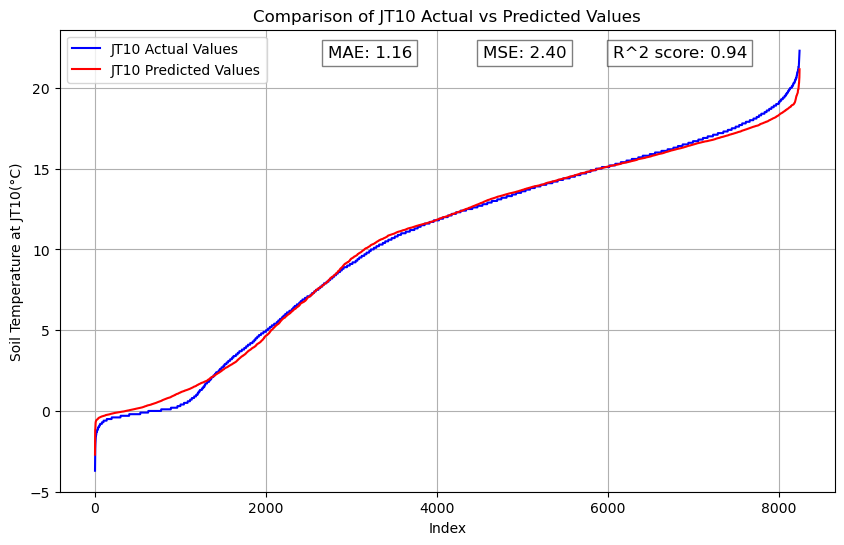

================================= Random Forest Metrics JT20 with a feature for forecast testing ==============================

{'Training Set R^2 Score': 0.9983495128035986, 'Validation Set R^2 Score': 0.9896747031279133, 'Training Set MAE': 0.1275727799169268, 'Validation Set MAE': 0.34671646859083194, 'Training Set MSE': 0.06046982442470359, 'Validation Set MSE': 0.38021999490662145, 'Training Set Median Absolute Error': 0.0769999999999822, 'Validation Set Median Absolute Error': 0.2085000000000008, 'Training Set MA Percentage Error': 4414163925465.698, 'Validation Set MA Percentage Error': 9956963959082.314, 'Training Set Max Error': 9.409999999999988, 'Validation Set Max Error': 12.092000000000002, 'Training Set Explained Variance Score': 0.9983501552811512, 'Validation Set Explained Variance Score': 0.98967786501396}



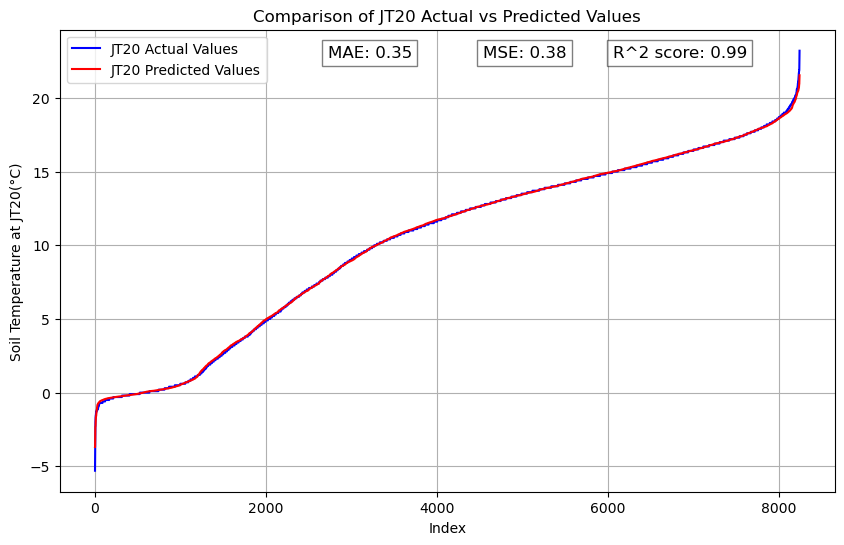

================================= Random Forest Metrics JT10 with weather data selected features for forecast testing ==============================

{'Training Set R^2 Score': 0.9455485654511229, 'Validation Set R^2 Score': 0.9364025803433663, 'Training Set MAE': 1.1055661986585743, 'Validation Set MAE': 1.185242360776263, 'Training Set MSE': 2.0790998903914297, 'Validation Set MSE': 2.460249862129744, 'Training Set Median Absolute Error': 0.8930541007348936, 'Validation Set Median Absolute Error': 0.9525749844234292, 'Training Set MA Percentage Error': 96573897600215.33, 'Validation Set MA Percentage Error': 142753460113031.6, 'Training Set Max Error': 15.072135246443679, 'Validation Set Max Error': 15.712984128926221, 'Training Set Explained Variance Score': 0.9455485682409615, 'Validation Set Explained Variance Score': 0.9364051351399684}



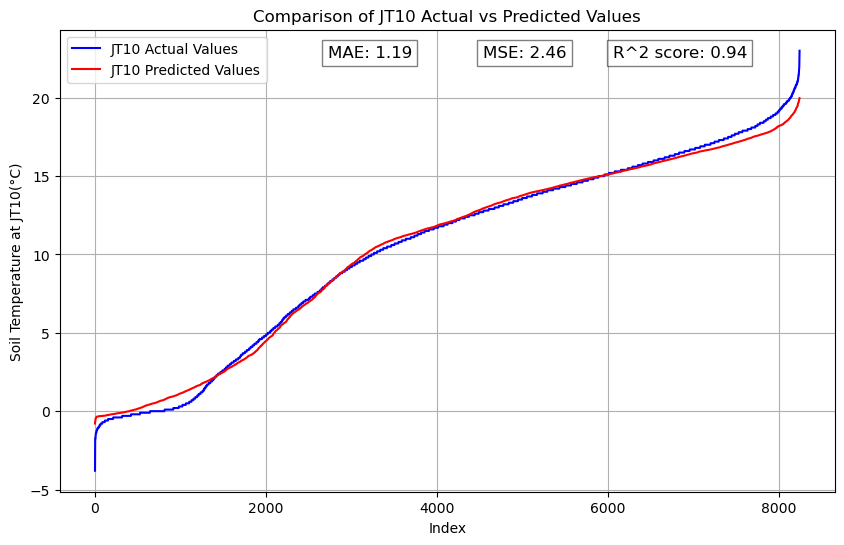

In [98]:
import requests as requests
import json as json
import pandas as pd
import numpy as np
from datetime import datetime
import math
# Initialize random seed
random.seed(42)
np.random.seed(42)

# Initialize the expires and last_modified variables 
expire_time = None
last_modified = None
latitude = 59.6603 # in degrees
longitude = 10.7817 # in degrees
altitude = 93 # in meters
# Now let us fetch the meteorological forecast data from MET Norway
request_url = f'https://api.met.no/weatherapi/locationforecast/2.0/complete?lat={latitude}&lon={longitude}&altitude={altitude}'
# Email address to include as User-Agent ID
user_agent = '259646@usn.no'
# Define headers with User-Agent
headers = {'User-Agent': user_agent, 'If-Modified-Since':last_modified}
# Send HTTP GET request with headers
response = requests.get(request_url, headers=headers)

# Extract the month and day
current_datetime = datetime.now()
current_month = current_datetime.strftime("%B")  # Full month name
current_day = current_datetime.strftime("%d") 

# Check the response status code
if response.status_code == 200:
     # Save the expires and last_modified variables to avoid frequency request to the server
    expires_header = response.headers.get('expires')
    last_modified_header = response.headers.get('last-modified')

    # Convert expires and last_modified to RFC 1123 format
    expire_time = datetime.strptime(expires_header, '%a, %d %b %Y %H:%M:%S GMT').strftime('%a, %d %b %Y %H:%M:%S GMT')
    last_modified = datetime.strptime(last_modified_header, '%a, %d %b %Y %H:%M:%S GMT').strftime('%a, %d %b %Y %H:%M:%S GMT')
    weather_data = response.json()
else:
    # Request failed, print error message
    weather_data = {}
    print(f"Error: {response.status_code}")

# Extract relevant information
rows = []
for entry in weather_data['properties']['timeseries']:
    instant_details = entry['data']['instant']['details']
    next_6_hours_details = entry['data'].get('next_6_hours', {}).get('details', None)
    row = {
        'time': entry['time'],
        'instant_air_temperature': instant_details['air_temperature'],
        'instant_air_pressure_at_sea_level': instant_details['air_pressure_at_sea_level'],
        'instant_relative_humidity': instant_details['relative_humidity'],
        'next_6_hours_air_temperature_max': next_6_hours_details['air_temperature_max'] if next_6_hours_details else None,
        'next_6_hours_air_temperature_min': next_6_hours_details['air_temperature_min'] if next_6_hours_details else None,
        'next_6_hours_precipitation_amount': next_6_hours_details['precipitation_amount'] if next_6_hours_details else None
    }
    rows.append(row)

# Create DataFrame
weather_df = pd.DataFrame(rows)
# Save to file
weather_df.to_csv(f'data/IMT_{current_month}_{current_day}_MET_weather_forecast_14_days.csv')

weather_df['time'] = pd.to_datetime(weather_df['time'])
# Add snow depth with zero values for testing during the summer season as there is no snow but should be automated for all seasons not part of the weather forecast
# weather_df['snow_depth_cm'] = 0.0

# Group DataFrame by date
grouped_df = weather_df.groupby(weather_df['time'].dt.date)

# Calculate daily mean, min, max
daily_stats = grouped_df.agg(
    mean_air_temperature_2m=('instant_air_temperature', 'mean'),
    min_air_temperature_2m=('next_6_hours_air_temperature_min', 'min'),
    max_air_temperature_2m=('next_6_hours_air_temperature_max', 'max'),
    relative_humidity=('instant_relative_humidity', 'mean'),
    air_pressure_2m_mbar=('instant_air_pressure_at_sea_level', 'mean'),
    precipitation_mm=('next_6_hours_precipitation_amount', 'mean')    
    # snow_depth_cm=('snow_depth_cm', 'mean')
)

# Create function to evaluate model on few different levels
def predict_and_score(model, X_train, X_valid, Y_train, Y_valid):
    """
    Calculates and shows the different sklearn evaluation metrics
        
    Parameters:
        model: the model fitted.
        X_train: the input training set.
        X_valid: the input validation or test set.
        Y_train: the target training set.
        Y_valid: the target validation or test set.
            
    Returns:
        scores: the dictionary of the calculated sklearn metrics for train and valid sets.
    """
    
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_valid)
    scores = {"Training Set R^2 Score": r2_score(Y_train, train_preds),
              "Validation Set R^2 Score":r2_score(Y_valid, val_preds),
              "Training Set MAE": mean_absolute_error(Y_train, train_preds),
              "Validation Set MAE": mean_absolute_error(Y_valid, val_preds),             
              "Training Set MSE": mean_squared_error(Y_train, train_preds),
              "Validation Set MSE": mean_squared_error(Y_valid, val_preds),
              "Training Set Median Absolute Error": median_absolute_error(Y_train, train_preds),
              "Validation Set Median Absolute Error": median_absolute_error(Y_valid, val_preds),
              "Training Set MA Percentage Error": mean_absolute_percentage_error(Y_train, train_preds),
              "Validation Set MA Percentage Error": mean_absolute_percentage_error(Y_valid, val_preds),
              "Training Set Max Error": max_error(Y_train, train_preds),
              "Validation Set Max Error": max_error(Y_valid, val_preds),
              "Training Set Explained Variance Score": explained_variance_score(Y_train, train_preds),
              "Validation Set Explained Variance Score": explained_variance_score(Y_valid, val_preds)}
    return scores

def fit_model(dataset_df, features_dropped, target, model_type):
    X_f = dataset_df.drop(features_dropped, axis=1)
    Y_f = dataset_df[target]
    # Split the X and Y data in to train and test data
    X_train_2, X_valid_2, Y_train_2, Y_valid_2 = train_test_split(X_f, Y_f, test_size=0.2)
    model_type.fit(X_train_2, Y_train_2)
    scores = predict_and_score(model_type, X_train_2, X_valid_2, Y_train_2, Y_valid_2)
    print(scores)
    return X_train_2, X_valid_2, Y_train_2, Y_valid_2
    
def calculate_pressure(P0, T, altitude):
    # Constants
    g = 9.80665  # Acceleration due to gravity (m/s^2)
    M = 0.0289644  # Molar mass of Earth's air (kg/mol)
    R = 8.31432  # Universal gas constant (J/(mol*K))    
    # Calculate pressure
    pressure = P0 * math.exp((-g * M * altitude) / (R * (T + 273.15)))
    return pressure

# Define a function that takes test set and validation sets as input and generates prediction curve and returns test set prediction data 
def predict_and_plot(model, JT_X_test, JT_X_validation, JT_Y_validation, name):
   # Predict the test set which is forecast data
   JT_Y_test_preds = model.predict(JT_X_test)
   # Changes the predicted array values to pandas series
   JT_Y_test_preds_series = pd.Series(JT_Y_test_preds, name=name) 
   # Convert the Series to a DataFrame
   JT_Y_test_preds_df = JT_Y_test_preds_series.to_frame()
   JT_Y_test_preds_df.index =  JT_X_test.index
   # Predict the validation set
   JT_Y_validation_preds = model.predict(JT_X_validation)
   # Change validation predictions to pandas series
   JT_Y_validation_preds_series = pd.Series(JT_Y_validation_preds)
   # Make the original and predicted series to have the same index
   JT_Y_validation_preds_series.index =JT_Y_validation.index
   # Sort Y_valid and Y_valid_preds in ascending order and reset indices
   JT_Y_validation_sorted = JT_Y_validation.sort_values().reset_index(drop=True)
   JT_Y_validation_preds_sorted = JT_Y_validation_preds_series[JT_Y_validation.index].sort_values().reset_index(drop=True)
  
   # Calculate mean absolute error
   JT_mae = mean_absolute_error(JT_Y_validation,JT_Y_validation_preds)
   # Calculate mean squared error
   JT_mse = mean_squared_error(JT_Y_validation,JT_Y_validation_preds)
   # Calculate the R^2 score
   JT_r2_score = r2_score(JT_Y_validation,JT_Y_validation_preds)
   # Plot the sorted values
   plt.figure(figsize=(10, 6))
   plt.plot(JT_Y_validation_sorted.index,JT_Y_validation_sorted, color='blue', label=f'{name} Actual Values')
   plt.plot(JT_Y_validation_preds_sorted.index,JT_Y_validation_preds_sorted, color='red', label=f'{name} Predicted Values')
   # Display the mean absolute error as text annotation
   plt.text(0.4, 0.95, f'MAE: {JT_mae:.2f}', ha='center', va='center', transform=plt.gca().transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
   plt.text(0.6, 0.95, f'MSE: {JT_mse:.2f}', ha='center', va='center', transform=plt.gca().transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
   plt.text(0.8, 0.95, f'R^2 score: {JT_r2_score:.2f}', ha='center', va='center', transform=plt.gca().transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
   plt.xlabel('Index')
   plt.ylabel(f'Soil Temperature at {name}(°C)')
   plt.title(f'Comparison of {name} Actual vs Predicted Values')
   plt.legend()
   plt.grid(True)
   plt.show()
   return JT_Y_test_preds_df

# ============================ Fit the soil temperature at 2cm from the forecast weather data ===================================== 
# calculate the air_pressure at certain altitude from the sea level air pressure forecast fetched from MET Norway
daily_stats['air_pressure_2m_mbar'] = daily_stats.apply(lambda row: calculate_pressure(row['air_pressure_2m_mbar'], row['mean_air_temperature_2m'], altitude), axis=1)
# Convert index to datetime
daily_stats.index = pd.to_datetime(daily_stats.index)
# Extract month and day from the index
daily_stats['month'] = daily_stats.index.month
daily_stats['day'] = daily_stats.index.day
# Create test set for soil temperature at 2cm as JT_X_test
JT10_X_test = daily_stats.copy()
JT10_X_test.drop('air_pressure_2m_mbar', axis=1, inplace=True)

# Create a local copy of the dataset and drop the date and year features
local_dataset = dataset_copied.drop(['ID','date', 'year', 'Station'], axis=1)
# Keep the original dataset's means of each feature for later use in denormalization
mean_original = local_dataset[features].mean()
# Keep the original dataset's standard deviationa of each feature for later use in denormalization
std_original = local_dataset[features].std()
# Calculate Z-score for all features
zscore_df = (local_dataset[features] - mean_original) / std_original
# Create a new DataFrame to store the normalized values
dataset_normalized = zscore_df.copy()
# copy the ID column from the original dataset to the dataset_normalized
dataset_normalized['ID'] = dataset_copied['ID']
dataset_normalized['Station'] = dataset_copied['Station']
# Define the denormalized or orginal equivalent dataset
dataset_denormalized = dataset_copied.drop(['date', 'year'], axis=1)

# Initialize RF and gbr regressors
JT10_gbr_regressor = HistGradientBoostingRegressor(random_state=42)
JT10_rf_regressor = RandomForestRegressor(oob_score=True, n_jobs=-1, random_state=42)
JT20_gbr_regressor = RandomForestRegressor(oob_score=True, n_jobs=-1, random_state=42)
JT20_gbr_ideal_new_model= HistGradientBoostingRegressor(early_stopping = True, 
                                                    l2_regularization= 1.0, 
                                                    learning_rate=0.1, 
                                                    max_bins= 255, 
                                                    max_depth= 7, 
                                                    max_iter=300, 
                                                    min_samples_leaf=5, 
                                                    n_iter_no_change=10, 
                                                    validation_fraction=0.1)

print("================================= Random Forest Metrics JT10 with weather data selected features for forecast testing ==============================\n")
JT10_X_training, JT10_X_validation, JT10_Y_training, JT10_Y_validation = fit_model(dataset_denormalized, 
                                                                                           ['ID','Station','JT10','JT20','evaporation_mm','global_radiation_w_m2'], 
                                                                                           'JT10', 
                                                                                           JT10_rf_regressor)
print('===========================================================================================\n')

# Call the validation sets prediction function to get the predicted values from the MET forecast as test set and plot the actual and predicted values and
JT10_Y_test_preds_df = predict_and_plot(JT10_rf_regressor, JT10_X_test, JT10_X_validation, JT10_Y_validation, 'JT10')
# Merge the Original DataFrame with the new predicted dataframe
JT10_forecast_df = pd.concat([JT10_X_test, JT10_Y_test_preds_df], axis=1)
# ======================= Fit the soil temperature at 5cm from the predictions at 2cm ================================
# Copy the JT10 predicted values as test data input for JT20
# JT20_features = ['JT10', 'month']
JT20_X_test = JT10_forecast_df.copy()
# JT20_X_test.index = JT10_forecast_df.index
# Initialize the RF regressor
JT20_rf_regressor = RandomForestRegressor(n_jobs=-1, random_state=42, oob_score=True)
# Fit and predict the validation set
print("================================= Random Forest Metrics JT20 with a feature for forecast testing ==============================\n")
JT20_X_training, JT20_X_validation, JT20_Y_training, JT20_Y_validation = fit_model(dataset_denormalized, 
                                                                                           ['ID','Station','JT20','evaporation_mm','global_radiation_w_m2'], 
                                                                                           'JT20', 
                                                                                           JT20_rf_regressor)
print('===========================================================================================\n')


# Order test and validation datasets
# Get the column order of validation set
column_order = JT20_X_validation.columns
# Reindex the columns of test set to match the column order of validation set
JT20_X_test = JT20_X_test.reindex(columns=column_order)
# Reassign the index name if it's different between the two DataFrames
if JT20_X_test.index.name != JT20_X_validation.index.name:
    JT20_X_validation.index.name = JT20_X_test.index.name
    
# Call the validation sets prediction function to plot the actual and predicted values and get the test predicted values
JT20_Y_test_preds_df = predict_and_plot(JT20_rf_regressor, JT20_X_test, JT20_X_validation, JT20_Y_validation, 'JT20')
# Merge the previous DataFrame with the new predicted dataframe
JT20_forecast_df = pd.concat([JT10_forecast_df, JT20_Y_test_preds_df], axis=1)

# Merge the Original DataFrame with the predicted Series DataFrames
JT_forecast_df = JT20_forecast_df.copy()

# Save the merged DataFrame to an Excel file
JT_forecast_df.to_excel(f'data/IMT_{current_month}_{current_day}_Soil_temperature_forecast_10_days.xlsx', index=True)

# Use a test set from the NMBU dataset which is completely different data to check the prediction accuracy of this model
JT10_X_test_nmbu_original = pd.read_csv('data/As2000_2004.csv', low_memory=False)
JT10_X_test_nmbu_original = JT10_X_test_nmbu_original.dropna()
JT10_X_test_nmbu = JT10_X_test_nmbu_original.copy()
JT10_X_test_nmbu['date'] = pd.to_datetime(JT10_X_test_nmbu['date'])
JT10_X_test_nmbu['month'] = JT10_X_test_nmbu['date'].dt.month
JT10_X_test_nmbu['day'] = JT10_X_test_nmbu['date'].dt.day
JT10_X_test_nmbu.drop(['date','ID'], axis=1, inplace=True)

    
JT10_gbr_nmbu_model= HistGradientBoostingRegressor(random_state=42)
print("================================= Random Forest Metrics JT10 with weather data selected features for forecast testing ==============================\n")
JT10_X_training_nmbu, JT10_X_validation_nmbu, JT10_Y_training_nmbu, JT10_Y_validation_nmbu = fit_model(dataset_denormalized, 
                                                                                           ['ID','Station','JT10','JT20'], 
                                                                                           'JT10', 
                                                                                           JT10_gbr_nmbu_model)
print('===========================================================================================\n')
# Order test and validation datasets
# Get the column order of validation set
column_order = JT10_X_validation_nmbu.columns
# Reindex the columns of test set to match the column order of validation set
JT10_X_test_nmbu = JT10_X_test_nmbu.reindex(columns=column_order)
# Reassign the index name if it's different between the two DataFrames
if JT10_X_test_nmbu.index.name != JT10_X_validation_nmbu.index.name:
    JT10_X_test_nmbu.index.name = JT10_X_validation_nmbu.index.name
# Call the validation sets prediction function to get the predicted values from the MET forecast as test set and plot the actual and predicted values and
JT10_Y_test_nmbu_preds = predict_and_plot(JT10_gbr_nmbu_model, JT10_X_test_nmbu, JT10_X_validation_nmbu, JT10_Y_validation_nmbu, 'JT10')
JT10_Y_test_nmbu_preds.rename(columns={'JT10': 'JT10_predicted'}, inplace=True)
JT10_Y_test_nmbu_preds_df = pd.concat([JT10_X_test_nmbu_original, JT10_Y_test_nmbu_preds], axis=1)
JT10_Y_test_nmbu_preds_df['JT10_Error'] = abs(JT10_Y_test_nmbu_preds_df['JT10'] - JT10_Y_test_nmbu_preds_df['JT10_predicted'])
JT10_Y_test_nmbu_preds_df.to_excel('data/IMT_JT10_prediction_on_nmbu_test_set.xlsx')

In [104]:
JT10_X_training_nmbu

,mean_air_temperature_2m,min_air_temperature_2m,max_air_temperature_2m,relative_humidity,precipitation_mm,global_radiation_w_m2,evaporation_mm,month,day
39789,21.9,15.8,28.7,52.9,0.0,23.0,4.7,6,19
36795,19.0,12.4,26.4,78.7,0.0,17.1,2.5,8,27
1153,24.3,12.0,34.0,52.1,0.0,23.1,4.8,7,27
13451,12.5,11.0,15.5,89.9,0.8,7.9,1.6,7,20
5895,16.5,10.3,23.1,75.8,0.0,27.7,5.7,7,16
...,...,...,...,...,...,...,...,...,...
37848,-0.7,-3.2,2.1,39.2,0.0,7.7,0.0,3,3
38281,-0.5,-3.5,3.4,63.4,0.0,13.8,0.0,3,31
23744,11.5,8.2,14.7,89.9,4.8,9.7,1.5,7,25
6327,14.6,11.8,20.4,79.9,0.1,14.2,2.8,7,20


In [100]:
dataset_denormalized

,ID,Station,mean_air_temperature_2m,min_air_temperature_2m,max_air_temperature_2m,relative_humidity,precipitation_mm,global_radiation_w_m2,JT10,JT20,evaporation_mm,month,day
0,1,Apelsvoll,-18.1,-22.1,-12.7,67.4,0.0,9.5,0.2,0.5,0.0,3,1
1,2,Apelsvoll,-13.5,-20.6,-9.6,65.8,0.0,4.9,0.2,0.5,0.0,3,2
2,3,Apelsvoll,-8.8,-11.0,-4.2,72.8,0.0,4.3,0.2,0.5,0.0,3,3
3,4,Apelsvoll,-8.0,-10.4,-2.6,79.2,0.4,6.1,0.1,0.5,0.0,3,4
4,5,Apelsvoll,-7.6,-9.3,-5.1,88.8,2.0,2.7,0.1,0.5,0.0,3,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
41224,41225,Valnesfjord,11.7,9.5,13.4,61.8,0.5,4.5,9.7,10.0,1.4,9,26
41225,41226,Valnesfjord,10.2,7.0,12.9,64.1,-0.2,7.2,8.9,9.5,1.3,9,27
41226,41227,Valnesfjord,9.6,4.8,13.6,68.7,-0.1,7.5,8.5,9.0,1.0,9,28
41227,41228,Valnesfjord,10.2,8.0,13.0,65.7,0.0,4.6,8.7,9.0,0.8,9,29


## Observations
#### The soil temperature forecast was compared with the real-time soil temperature on NMBU BIOKLIM website and the forecast is a good approximation.
#### The following reasons may be the cause for the deviation:
##### 1. The MET Norway weather forecast has little error
##### 2. Weather forecast by its nature is prone to unpredictable factors and the initial weather forecast may not be accurate.
##### 3. The NMBU BIOKLIM real-time data is not verified and there might be some error on the display
##### 4. The ML prediction algorithm has a mean absolute error of 0.72 for the JT2 prediction which requires an improvement to make it close to the resolution of temperature measurements (0.1 celsius) by NMBU soil temeprature sensors.

# 8. Optimization of the Soil Temperature Prediction 
### a. One option to optimize the prediction algorithm is using stacking regressors

In [103]:
import requests as requests
import json as json
import pandas as pd
from datetime import datetime
import math
import numpy as np
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.metrics import PredictionErrorDisplay
from sklearn.model_selection import cross_val_predict, cross_validate
import time

# Initialize the expires and last_modified variables 
expire_time = None
last_modified = None
latitude = 59.6603 # in degrees
longitude = 10.7817 # in degrees
altitude = 93 # in meters

# Extract the month and day
current_datetime = datetime.now()
# Extract date and time information at once
formatted_date = current_datetime.strftime("%Y-%m-%d")
formatted_time = current_datetime.strftime("%H-%M-%S")

# Now let us fetch the meteorological forecast data from MET Norway
request_url = f'https://api.met.no/weatherapi/locationforecast/2.0/complete?lat={latitude}&lon={longitude}&altitude={altitude}'
# Email address to include as User-Agent ID
user_agent = '259646@usn.no'
# Define headers with User-Agent
headers = {'User-Agent': user_agent, 'If-Modified-Since':last_modified}
# Send HTTP GET request with headers
response = requests.get(request_url, headers=headers)

# Check the response status code
if response.status_code == 200:
     # Save the expires and last_modified variables to avoid frequency request to the server
    expires_header = response.headers.get('expires')
    last_modified_header = response.headers.get('last-modified')

    # Convert expires and last_modified to RFC 1123 format
    expire_time = datetime.strptime(expires_header, '%a, %d %b %Y %H:%M:%S GMT').strftime('%a, %d %b %Y %H:%M:%S GMT')
    last_modified = datetime.strptime(last_modified_header, '%a, %d %b %Y %H:%M:%S GMT').strftime('%a, %d %b %Y %H:%M:%S GMT')
    weather_data = response.json()
else:
    # Request failed, print error message
    weather_data = {}
    print(f"Error: {response.status_code}")

# Extract relevant information
rows = []
for entry in weather_data['properties']['timeseries']:
    instant_details = entry['data']['instant']['details']
    next_6_hours_details = entry['data'].get('next_6_hours', {}).get('details', None)
    row = {
        'time': entry['time'],
        'instant_air_temperature': instant_details['air_temperature'],
        'instant_air_pressure_at_sea_level': instant_details['air_pressure_at_sea_level'],
        'instant_relative_humidity': instant_details['relative_humidity'],
        'next_6_hours_air_temperature_max': next_6_hours_details['air_temperature_max'] if next_6_hours_details else None,
        'next_6_hours_air_temperature_min': next_6_hours_details['air_temperature_min'] if next_6_hours_details else None,
        'next_6_hours_precipitation_amount': next_6_hours_details['precipitation_amount'] if next_6_hours_details else None
    }
    rows.append(row)

# Create DataFrame
weather_df = pd.DataFrame(rows)
# Save to file
weather_df.to_csv(f'data/{formatted_date}-{formatted_time}_MET_weather_forecast_10_days.csv')

weather_df['time'] = pd.to_datetime(weather_df['time'])
# Add snow depth with zero values for testing during the summer season as there is no snow but should be automated for all seasons not part of the weather forecast
weather_df['snow_depth_cm'] = 0.0
# # Convert "time" column to datetime object
# weather_df['time'] = pd.to_datetime(weather_df['time'])
# # Extract date from datetime object
# weather_df['date'] = weather_df['time'].dt.date
# # Check if each date has 24 hours
# complete_dates = weather_df['date'].value_counts()[weather_df['date'].value_counts() == 24].index.tolist()
# # Filter rows with complete dates
# weather_df = weather_df[weather_df['date'].isin(complete_dates)]
# # Drop the 'date' column
# weather_df = weather_df.drop(columns=['date'])

# Group DataFrame by date
grouped_df = weather_df.groupby(weather_df['time'].dt.date)

# Calculate daily mean, min, max
daily_stats = grouped_df.agg(
    mean_air_temperature_2m=('instant_air_temperature', 'mean'),
    min_air_temperature_2m=('next_6_hours_air_temperature_min', 'min'),
    max_air_temperature_2m=('next_6_hours_air_temperature_max', 'max'),
    relative_humidity=('instant_relative_humidity', 'mean'),
    air_pressure_2m_mbar=('instant_air_pressure_at_sea_level', 'mean'),
    precipitation_mm=('next_6_hours_precipitation_amount', 'mean'),    
    snow_depth_cm=('snow_depth_cm', 'mean')
)

# Create function to evaluate model on few different levels
def predict_and_score(model, X_train, X_valid, Y_train, Y_valid):
    """
    Calculates and shows the different sklearn evaluation metrics
        
    Parameters:
        model: the model fitted.
        X_train: the input training set.
        X_valid: the input validation or test set.
        Y_train: the target training set.
        Y_valid: the target validation or test set.
            
    Returns:
        scores: the dictionary of the calculated sklearn metrics for train and valid sets.
    """
    
    train_preds = cross_val_predict(model, X_train, Y_train, cv=5)
    val_preds = model.predict(X_valid)
    scores = {"Training Set R^2 Score": r2_score(Y_train, train_preds),
              "Validation Set R^2 Score":r2_score(Y_valid, val_preds),
              "Training Set MAE": mean_absolute_error(Y_train, train_preds),
              "Validation Set MAE": mean_absolute_error(Y_valid, val_preds),             
              "Training Set MSE": mean_squared_error(Y_train, train_preds),
              "Validation Set MSE": mean_squared_error(Y_valid, val_preds),
              "Training Set Median Absolute Error": median_absolute_error(Y_train, train_preds),
              "Validation Set Median Absolute Error": median_absolute_error(Y_valid, val_preds),
              "Training Set MA Percentage Error": mean_absolute_percentage_error(Y_train, train_preds),
              "Validation Set MA Percentage Error": mean_absolute_percentage_error(Y_valid, val_preds),
              "Training Set Max Error": max_error(Y_train, train_preds),
              "Validation Set Max Error": max_error(Y_valid, val_preds),
              "Training Set Explained Variance Score": explained_variance_score(Y_train, train_preds),
              "Validation Set Explained Variance Score": explained_variance_score(Y_valid, val_preds)}
    return scores

def fit_model(dataset_df, features_dropped, target, model_type):
    X_f = dataset_df.drop(features_dropped, axis=1)
    Y_f = dataset_df[target]
    # Split the X and Y data in to train and test data
    X_train_2, X_valid_2, Y_train_2, Y_valid_2 = train_test_split(X_f, Y_f, test_size=0.15)
    model_type.fit(X_train_2, Y_train_2)
    scores = predict_and_score(model_type, X_train_2, X_valid_2, Y_train_2, Y_valid_2)
    print(scores)
    return X_train_2, X_valid_2, Y_train_2, Y_valid_2
    
def calculate_pressure(P0, T, altitude):
    # Constants
    g = 9.80665  # Acceleration due to gravity (m/s^2)
    M = 0.0289644  # Molar mass of Earth's air (kg/mol)
    R = 8.31432  # Universal gas constant (J/(mol*K))    
    # Calculate pressure
    pressure = P0 * math.exp((-g * M * altitude) / (R * (T + 273.15)))
    return pressure
# calculate the air_pressure at certain altitude from the sea level air pressure forecast fetched from MET Norway
daily_stats['air_pressure_2m_mbar'] = daily_stats.apply(lambda row: calculate_pressure(row['air_pressure_2m_mbar'], row['mean_air_temperature_2m'], altitude), axis=1)
# Convert index to datetime
daily_stats.index = pd.to_datetime(daily_stats.index)
# Extract month and day from the index
daily_stats['month'] = daily_stats.index.month
daily_stats['day'] = daily_stats.index.day
# Create test set for soil temperature at 2cm as JT_X_test
JT2_X_test = daily_stats

# Define a function that takes test set and validation sets as input and generates prediction curve and returns test set prediction data 
def predict_plot(model, JT_X_test, JT_X_validation, JT_Y_validation, name):
   # Predict the test set which is forecast data
   JT_Y_test_preds = model.predict(JT_X_test)
   # Changes the predicted array values to pandas series
   JT_Y_test_preds_series = pd.Series(JT_Y_test_preds, name=name) 
   # Convert the Series to a DataFrame
   JT_Y_test_preds_df = JT_Y_test_preds_series.to_frame()
   JT_Y_test_preds_df.index =  JT_X_test.index
   # Predict the validation set
   JT_Y_validation_preds = model.predict(JT_X_validation)
   # Change validation predictions to pandas series
   JT_Y_validation_preds_series = pd.Series(JT_Y_validation_preds)
   # Make the original and predicted series to have the same index
   JT_Y_validation_preds_series.index =JT_Y_validation.index
   # Sort Y_valid and Y_valid_preds in ascending order and reset indices
   JT_Y_validation_sorted = JT_Y_validation.sort_values().reset_index(drop=True)
   JT_Y_validation_preds_sorted = JT_Y_validation_preds_series[JT_Y_validation.index].sort_values().reset_index(drop=True)
  
   # Calculate mean absolute error
   JT_mae = mean_absolute_error(JT_Y_validation,JT_Y_validation_preds)
   # Calculate mean squared error
   JT_mse = mean_squared_error(JT_Y_validation,JT_Y_validation_preds)
   # Calculate the R^2 score
   JT_r2_score = r2_score(JT_Y_validation,JT_Y_validation_preds)
   # Plot the sorted values
   plt.figure(figsize=(10, 6))
   plt.plot(JT_Y_validation_sorted.index,JT_Y_validation_sorted, color='blue', label=f'{name} Actual Values')
   plt.plot(JT_Y_validation_preds_sorted.index,JT_Y_validation_preds_sorted, color='red', label=f'{name} Predicted Values')
   # Display the mean absolute error as text annotation
   plt.text(0.4, 0.95, f'MAE: {JT_mae:.2f}', ha='center', va='center', transform=plt.gca().transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
   plt.text(0.6, 0.95, f'MSE: {JT_mse:.2f}', ha='center', va='center', transform=plt.gca().transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
   plt.text(0.8, 0.95, f'R^2 score: {JT_r2_score:.2f}', ha='center', va='center', transform=plt.gca().transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
   plt.xlabel('Index')
   plt.ylabel(f'Soil Temperature at {name}(°C)')
   plt.title(f'Comparison of {name} Actual vs Predicted Values')
   plt.legend()
   plt.grid(True)
   plt.show()
   return JT_Y_test_preds_df

def plot_stacking_models(estimators_array, X_train, Y_train, target):
    # Measure and plot the results
    fig, axs = plt.subplots(2, 2, figsize=(9, 7))
    axs = np.ravel(axs)
    
    for ax, (name, est) in zip(axs, estimators_array):
        scorers = {"R^2": "r2", "MAE": "neg_mean_absolute_error", "MSE":"neg_mean_squared_error", "MEDIAN_E":"neg_median_absolute_error"}
    
        start_time = time.time()
        scores = cross_validate(est, X_train, Y_train, scoring=list(scorers.values()), n_jobs=-1, verbose=0)
        elapsed_time = time.time() - start_time
    
        y_pred = cross_val_predict(est, X_train, Y_train, n_jobs=-1, verbose=0)
        scores = {
            key: (
                f"{np.abs(np.mean(scores[f'test_{value}'])):.4f} +- "
                f"{np.std(scores[f'test_{value}']):.4f}"
            )
            for key, value in scorers.items()
        }
    
        display = PredictionErrorDisplay.from_predictions(
            y_true=Y_train,
            y_pred=y_pred,
            kind="actual_vs_predicted",
            ax=ax,
            scatter_kwargs={"alpha": 0.2, "color": "tab:blue"},
            line_kwargs={"color": "tab:red"},
        )
        ax.set_title(f"{name}\nEvaluation in {elapsed_time:.4f} seconds")
        # Set custom x-label and y-label
        ax.set_xlabel(f"Soil Temperature Forecast at {target} (0^C)")
        ax.set_ylabel(f"Actual Soil Temperature at {target} (0^C)")
        for name, score in scores.items():
            ax.plot([], [], " ", label=f"{name}: {score}")
        ax.legend(loc="upper left")
    
    plt.suptitle("Comparison between single predictor versus stacked predictors")
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.savefig(f'images/{target}_stacking_regressors_forecast_vs_actual_values.png')  # Save as PNG format
    plt.show()

global_estimators = []
# ============================ Fit the soil temperature at 2cm from the forecast weather data ===================================== 
def initialize_stacking_regressor():
    # Stack of predictors on a single data set
    rf_regressor = RandomForestRegressor(n_estimators=300, 
                                           min_samples_leaf=1,
                                           min_samples_split=2,
                                           max_features='sqrt',
                                           max_depth=20,
                                           bootstrap=False,
                                           random_state=42)
    lasso_regressor = LassoCV()
    gbdt_regresssor = HistGradientBoostingRegressor(random_state=42)
    # Define the estimators to be used in the stacking regressor
    local_estimators = [
        ("Random Forest", rf_regressor),
        ("Lasso", lasso_regressor),
        ("Gradient Boosting", gbdt_regresssor),
    ]
    
    # Initialize the stacking regressor
    stackingRegressorModel = StackingRegressor(estimators=local_estimators, final_estimator=RidgeCV())
    # Append to estimators
    global_estimators.extend(local_estimators)
    global_estimators.append(("Stacking Regressor", stackingRegressorModel))
    return stackingRegressorModel

# Initialize the Stacking regressor
JT2_stacking_regressor = initialize_stacking_regressor()

# Fit and predict the validation set
print("================================= Random Forest Metrics JT2 with weather data selected features for forecast testing ==============================\n")
JT2_X_training, JT2_X_validation, JT2_Y_training, JT2_Y_validation = fit_model(dataset_denormalized, 
                                                                                           ['earth_heat_flux_MJ_m2','global_radiation_w_m2','phosynthetic_active_radiation_mE_m2','albedo_RR_GR','evaporation_mm','JT100','JT50','JT20','JT10','JT5','JT2','ID'], 
                                                                                           'JT2', 
                                                                                           JT2_stacking_regressor)
print('===========================================================================================\n')
# Call the validation sets prediction function to plot the actual and predicted values and get the test predicted values
JT2_Y_test_preds_df = predict_plot(JT2_stacking_regressor, JT2_X_test, JT2_X_validation, JT2_Y_validation, 'JT2')
# The stacked model evaluation plots
plot_stacking_models(global_estimators, JT2_X_training, JT2_Y_training, 'JT2')

# Merge the Original DataFrame with the new predicted dataframe
JT2_forecast_df = pd.concat([JT2_X_test, JT2_Y_test_preds_df], axis=1)
# ======================= Fit the soil temperature at 5cm from the predictions at 2cm ================================
# Copy the JT2 predicted values as test data input for JT5
JT5_features = ['JT2', 'month']
JT5_X_test = JT2_forecast_df[JT5_features]
JT5_X_test.index = JT2_forecast_df.index

# Initialize the Stacking regressor
global_estimators = []
JT5_stacking_regressor= initialize_stacking_regressor()
# Fit and predict the validation set
print("================================= Random Forest Metrics JT5 with JT2 as a feature for forecast testing ==============================\n")
JT5_X_training, JT5_X_validation, JT5_Y_training, JT5_Y_validation = fit_model(dataset_denormalized, 
                                                                                           ['mean_air_temperature_2m','min_air_temperature_2m','max_air_temperature_2m','relative_humidity','air_pressure_2m_mbar','precipitation_mm','earth_heat_flux_MJ_m2','global_radiation_w_m2','phosynthetic_active_radiation_mE_m2','albedo_RR_GR','evaporation_mm','snow_depth_cm','day','JT100','JT50','JT20','JT10','JT5','ID'], 
                                                                                           'JT5', 
                                                                                           JT5_stacking_regressor)
print('===========================================================================================\n')
# Call the validation sets prediction function to plot the actual and predicted values and get the test predicted values
JT5_Y_test_preds_df = predict_plot(JT5_stacking_regressor, JT5_X_test, JT5_X_validation, JT5_Y_validation, 'JT5')
# The stacked model evaluation plots
plot_stacking_models(global_estimators, JT5_X_training, JT5_Y_training, 'JT5')

# Merge the previous DataFrame with the new predicted dataframe
JT5_forecast_df = pd.concat([JT2_forecast_df, JT5_Y_test_preds_df], axis=1)

# ======================= Fit the soil temperature at 10cm from the predictions at 5cm ================================
# Copy the JT5 predicted values as test data input for JT10
JT10_features = ['JT5', 'month']
JT10_X_test = JT5_forecast_df[JT10_features]
JT10_X_test.index = JT5_forecast_df.index

# Initialize the Stacking regressor
global_estimators = []
JT10_stacking_regressor = initialize_stacking_regressor()
# Fit and predict the validation set
print("================================= Random Forest Metrics JT10 with JT2 as a feature for forecast testing ==============================\n")
JT10_X_training, JT10_X_validation, JT10_Y_training, JT10_Y_validation = fit_model(dataset_denormalized, 
                                                                                           ['mean_air_temperature_2m','min_air_temperature_2m','max_air_temperature_2m','relative_humidity','air_pressure_2m_mbar','precipitation_mm','earth_heat_flux_MJ_m2','global_radiation_w_m2','phosynthetic_active_radiation_mE_m2','albedo_RR_GR','evaporation_mm','snow_depth_cm','day','JT100','JT50','JT20','JT10','JT2','ID'], 
                                                                                           'JT10', 
                                                                                           JT10_stacking_regressor)
print('===========================================================================================\n')
# Call the validation sets prediction function to plot the actual and predicted values and get the test predicted values
JT10_Y_test_preds_df = predict_plot(JT10_stacking_regressor, JT10_X_test, JT10_X_validation, JT10_Y_validation, 'JT10')
# The stacked model evaluation plots
plot_stacking_models(global_estimators, JT10_X_training, JT10_Y_training, 'JT10')

# Merge the previous DataFrame with the new predicted dataframe
JT10_forecast_df = pd.concat([JT5_forecast_df, JT10_Y_test_preds_df], axis=1)

# ======================= Fit the soil temperature at 20cm from the predictions at 10cm and month ================================
# Copy the JT10 predicted values as test data input for JT20
JT20_features = ['JT10', 'month']
JT20_X_test = JT10_forecast_df[JT20_features]
JT20_X_test.index = JT10_forecast_df.index

# Initialize the Stacking regressor
global_estimators = []
JT20_stacking_regressor = initialize_stacking_regressor()
# Fit and predict the validation set
print("================================= Random Forest Metrics JT20 with JT2 as a feature for forecast testing ==============================\n")
JT20_X_training, JT20_X_validation, JT20_Y_training, JT20_Y_validation = fit_model(dataset_denormalized, 
                                                                                           ['mean_air_temperature_2m','min_air_temperature_2m','max_air_temperature_2m','relative_humidity','air_pressure_2m_mbar','precipitation_mm','earth_heat_flux_MJ_m2','global_radiation_w_m2','phosynthetic_active_radiation_mE_m2','albedo_RR_GR','evaporation_mm','snow_depth_cm','day','JT100','JT50','JT20','JT5','JT2','ID'], 
                                                                                           'JT20', 
                                                                                           JT20_stacking_regressor)
print('===========================================================================================\n')
# Call the validation sets prediction function to plot the actual and predicted values and get the test predicted values
JT20_Y_test_preds_df = predict_plot(JT20_stacking_regressor, JT20_X_test, JT20_X_validation, JT20_Y_validation, 'JT20')
# The stacked model evaluation plots
plot_stacking_models(global_estimators, JT20_X_training, JT20_Y_training, 'JT20')

# Merge the previous DataFrame with the new predicted dataframe
JT20_forecast_df = pd.concat([JT10_forecast_df, JT20_Y_test_preds_df], axis=1)

# ======================= Fit the soil temperature at 50cm from the predictions at 20cm and month ================================
# Copy the JT20 predicted values as test data input for JT50
JT50_features = ['JT20', 'month']
JT50_X_test = JT20_forecast_df[JT50_features]
JT50_X_test.index = JT20_forecast_df.index

# Initialize the Stacking regressor
global_estimators = []
JT50_stacking_regressor = initialize_stacking_regressor()
# Fit and predict the validation set
print("================================= Random Forest Metrics JT50 with JT2 as a feature for forecast testing ==============================\n")
JT50_X_training, JT50_X_validation, JT50_Y_training, JT50_Y_validation = fit_model(dataset_denormalized, 
                                                                                           ['mean_air_temperature_2m','min_air_temperature_2m','max_air_temperature_2m','relative_humidity','air_pressure_2m_mbar','precipitation_mm','earth_heat_flux_MJ_m2','global_radiation_w_m2','phosynthetic_active_radiation_mE_m2','albedo_RR_GR','evaporation_mm','snow_depth_cm','day','JT100','JT50','JT10','JT5','JT2','ID'], 
                                                                                           'JT50', 
                                                                                           JT50_stacking_regressor)
print('===========================================================================================\n')
# Call the validation sets prediction function to plot the actual and predicted values and get the test predicted values
JT50_Y_test_preds_df = predict_plot(JT50_stacking_regressor, JT50_X_test, JT50_X_validation, JT50_Y_validation, 'JT50')
# The stacked model evaluation plots
plot_stacking_models(global_estimators, JT50_X_training, JT50_Y_training, 'JT50')

# Merge the previous DataFrame with the new predicted dataframe
JT50_forecast_df = pd.concat([JT20_forecast_df, JT50_Y_test_preds_df], axis=1)

# ======================= Fit the soil temperature at 100cm from the predictions at 50cm and month ================================
# Copy the JT50 predicted values as test data input for JT100
JT100_features = ['JT50', 'month']
JT100_X_test = JT50_forecast_df[JT100_features]
JT100_X_test.index = JT50_forecast_df.index

# Initialize the Stacking regressor
global_estimators = []
JT100_stacking_regressor = initialize_stacking_regressor()
# Fit and predict the validation set
print("================================= Random Forest Metrics JT100 with JT2 as a feature for forecast testing ==============================\n")
JT100_X_training, JT100_X_validation, JT100_Y_training, JT100_Y_validation = fit_model(dataset_denormalized, 
                                                                                           ['mean_air_temperature_2m','min_air_temperature_2m','max_air_temperature_2m','relative_humidity','air_pressure_2m_mbar','precipitation_mm','earth_heat_flux_MJ_m2','global_radiation_w_m2','phosynthetic_active_radiation_mE_m2','albedo_RR_GR','evaporation_mm','snow_depth_cm','day','JT100','JT20','JT10','JT5','JT2','ID'], 
                                                                                           'JT100', 
                                                                                           JT100_stacking_regressor)
print('===========================================================================================\n')
# Call the validation sets prediction function to plot the actual and predicted values and get the test predicted values
JT100_Y_test_preds_df = predict_plot(JT100_stacking_regressor, JT100_X_test, JT100_X_validation, JT100_Y_validation, 'JT100')
# The stacked model evaluation plots
plot_stacking_models(global_estimators, JT100_X_training, JT100_Y_training, 'JT100')

# Merge the previous DataFrame with the new predicted dataframe
JT100_forecast_df = pd.concat([JT50_forecast_df, JT100_Y_test_preds_df], axis=1)

# Merge the Original DataFrame with the predicted Series DataFrames
JT_forecast_df = JT100_forecast_df.copy()

# Save the merged DataFrame to an Excel file
JT_forecast_df.to_excel(f'data/{formatted_date}-{formatted_time}_Soil_temperature_forecast_10_days.xlsx', index=True)
JT_forecast_df

================================= Random Forest Metrics JT2 with weather data selected features for forecast testing ==============================



KeyError: "['earth_heat_flux_MJ_m2', 'phosynthetic_active_radiation_mE_m2', 'albedo_RR_GR', 'JT100', 'JT50', 'JT5', 'JT2'] not found in axis"

In [ ]:
current_datetime

In [ ]:
JT2_rf_regressor.feature_importances_

### Apply GridSearchCV Hyperparameter tuning when required

In [ ]:
# %%time
# # Define the parameter grid to search
# param_grid = {
#     'n_estimators': [100, 200, 300, 400],
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': [2, 5, 10, 20],
#     'min_samples_leaf': [1, 2, 4, 6],
#     'max_features': [0.3, 1, 'sqrt', 'log2'],
#     'bootstrap': [True, False]
# }

# # Perform Grid Search with cross-validation
# gsc_model = GridSearchCV(RandomForestRegressor(n_jobs=-1, random_state=42), param_grid=param_grid, 
#                            cv=5, n_jobs=-1, verbose=2)

# # Fit the Grid Search to the data
# gsc_model.fit(JT2_X_training, JT2_Y_training)

# # Get the best parameters and best score
# best_params = gsc_model.best_params_
# best_score = gsc_model.best_score_

# print("Best Parameters:", best_params)
# print("Best Score:", best_score)

# 7. Combine Predictors using stacking 
### Stacking Regressor for Soil temperature at 2cm

In [ ]:
import numpy as np
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.metrics import PredictionErrorDisplay
from sklearn.model_selection import cross_val_predict, cross_validate
import time

# Split the dataset into features and target
features = ['earth_heat_flux_MJ_m2','global_radiation_w_m2','phosynthetic_active_radiation_mE_m2','albedo_RR_GR','evaporation_mm','JT100','JT50','JT20','JT10','JT5','JT2','ID']
JT2_X = dataset_denormalized_outlier_filtered.drop(features, axis=1)
JT2_Y = dataset_denormalized_outlier_filtered['JT2']

# Stack of predictors on a single data set
rf_regressor = RandomForestRegressor(random_state=42)
lasso_regressor = LassoCV()
gbdt_regresssor = HistGradientBoostingRegressor(random_state=42)

estimators = [
    ("Random Forest", rf_regressor),
    ("Lasso", lasso_regressor),
    ("Gradient Boosting", gbdt_regresssor),
]
stacking_regressor = StackingRegressor(estimators=estimators, final_estimator=RidgeCV())

# Measure and plot the results
fig, axs = plt.subplots(2, 2, figsize=(9, 7))
axs = np.ravel(axs)

for ax, (name, est) in zip(axs, estimators + [("Stacking Regressor", stacking_regressor)]):
    scorers = {"R^2": "r2", "MAE": "neg_mean_absolute_error", "MSE":"neg_mean_squared_error", "MEDIAN_E":"neg_median_absolute_error"}

    start_time = time.time()
    scores = cross_validate(est, JT2_X, JT2_Y, scoring=list(scorers.values()), n_jobs=-1, verbose=0)
    elapsed_time = time.time() - start_time

    y_pred = cross_val_predict(est, JT2_X, JT2_Y, n_jobs=-1, verbose=0)
    scores = {
        key: (
            f"{np.abs(np.mean(scores[f'test_{value}'])):.4f} +- "
            f"{np.std(scores[f'test_{value}']):.4f}"
        )
        for key, value in scorers.items()
    }

    display = PredictionErrorDisplay.from_predictions(
        y_true=JT2_Y,
        y_pred=y_pred,
        kind="actual_vs_predicted",
        ax=ax,
        scatter_kwargs={"alpha": 0.2, "color": "tab:blue"},
        line_kwargs={"color": "tab:red"},
    )
    ax.set_title(f"{name}\nEvaluation in {elapsed_time:.4f} seconds")
    # Set custom x-label and y-label
    ax.set_xlabel("Predicted Soil Temperature at 2cm (0^C)")
    ax.set_ylabel("Actual Soil Temperature at 2cm (0^C)")
    for name, score in scores.items():
        ax.plot([], [], " ", label=f"{name}: {score}")
    ax.legend(loc="upper left")

plt.suptitle("Single predictors versus stacked predictors")
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.savefig('images/JT2_stacking_regressors_predicted_actual_values.png')  # Save as PNG format
plt.show()

### Stacking Regressor for Soil temperature at 5cm

In [ ]:
# import numpy as np
# from sklearn.datasets import fetch_openml
# from sklearn.utils import shuffle
# from sklearn.linear_model import LassoCV
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.ensemble import HistGradientBoostingRegressor
# from sklearn.ensemble import StackingRegressor
# from sklearn.linear_model import RidgeCV
# from sklearn.metrics import PredictionErrorDisplay
# from sklearn.model_selection import cross_val_predict, cross_validate
# import time

# # Split the dataset into features and target
# JT5_features = ['JT5', 'JT10', 'JT20', 'JT50','JT100']
# JT5_X = dataset_denormalized_outlier_filtered.drop(JT5_features, axis=1)
# JT5_Y = dataset_denormalized_outlier_filtered['JT5']

# # Stack of predictors on a single data set
# rf_regressor = RandomForestRegressor(random_state=42)
# lasso_regressor = LassoCV()
# gbdt_regresssor = HistGradientBoostingRegressor(random_state=42)

# estimators = [
#     ("Random Forest", rf_regressor),
#     ("Lasso", lasso_regressor),
#     ("Gradient Boosting", gbdt_regresssor),
# ]
# stacking_regressor = StackingRegressor(estimators=estimators, final_estimator=RidgeCV())

# # Measure and plot the results
# fig, axs = plt.subplots(2, 2, figsize=(9, 7))
# axs = np.ravel(axs)

# for ax, (name, est) in zip(axs, estimators + [("Stacking Regressor", stacking_regressor)]):
#     scorers = {"R^2": "r2", "MAE": "neg_mean_absolute_error", "MSE":"neg_mean_squared_error", "MEDIAN_E":"neg_median_absolute_error"}

#     start_time = time.time()
#     scores = cross_validate(est, JT5_X, JT5_Y, scoring=list(scorers.values()), n_jobs=-1, verbose=0)
#     elapsed_time = time.time() - start_time

#     y_pred = cross_val_predict(est, JT5_X, JT5_Y, n_jobs=-1, verbose=0)
#     scores = {
#         key: (
#             f"{np.abs(np.mean(scores[f'test_{value}'])):.4f} +- "
#             f"{np.std(scores[f'test_{value}']):.4f}"
#         )
#         for key, value in scorers.items()
#     }

#     display = PredictionErrorDisplay.from_predictions(
#         y_true=JT5_Y,
#         y_pred=y_pred,
#         kind="actual_vs_predicted",
#         ax=ax,
#         scatter_kwargs={"alpha": 0.2, "color": "tab:blue"},
#         line_kwargs={"color": "tab:red"},
#     )
#     ax.set_title(f"{name}\nEvaluation in {elapsed_time:.4f} seconds")
#     # Set custom x-label and y-label
#     ax.set_xlabel("Predicted Soil Temperature at 5cm (0^C)")
#     ax.set_ylabel("Actual Soil Temperature at 5cm (0^C)")
#     for name, score in scores.items():
#         ax.plot([], [], " ", label=f"{name}: {score}")
#     ax.legend(loc="upper left")

# plt.suptitle("Single predictors versus stacked predictors")
# plt.tight_layout()
# plt.subplots_adjust(top=0.9)
# plt.savefig('images/JT5_stacking_regressors_predicted_actual_values.png')  # Save as PNG format
# plt.show()

### Stacking Regressor for Soil temperature at 5cm

In [ ]:
# import numpy as np
# from sklearn.datasets import fetch_openml
# from sklearn.utils import shuffle
# from sklearn.linear_model import LassoCV
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.ensemble import HistGradientBoostingRegressor
# from sklearn.ensemble import StackingRegressor
# from sklearn.linear_model import RidgeCV
# from sklearn.metrics import PredictionErrorDisplay
# from sklearn.model_selection import cross_val_predict, cross_validate
# import time

# # Split the dataset into features and target
# JT10_features = ['JT2', 'JT10', 'JT20', 'JT50','JT100']
# JT10_X = dataset_denormalized_outlier_filtered.drop(JT10_features, axis=1)
# JT10_Y = dataset_denormalized_outlier_filtered['JT10']

# # Stack of predictors on a single data set
# rf_regressor = RandomForestRegressor(random_state=42)
# lasso_regressor = LassoCV()
# gbdt_regresssor = HistGradientBoostingRegressor(random_state=42)

# estimators = [
#     ("Random Forest", rf_regressor),
#     ("Lasso", lasso_regressor),
#     ("Gradient Boosting", gbdt_regresssor),
# ]
# stacking_regressor = StackingRegressor(estimators=estimators, final_estimator=RidgeCV())

# # Measure and plot the results
# fig, axs = plt.subplots(2, 2, figsize=(9, 7))
# axs = np.ravel(axs)

# for ax, (name, est) in zip(axs, estimators + [("Stacking Regressor", stacking_regressor)]):
#     scorers = {"R^2": "r2", "MAE": "neg_mean_absolute_error", "MSE":"neg_mean_squared_error", "MEDIAN_E":"neg_median_absolute_error"}

#     start_time = time.time()
#     scores = cross_validate(est, JT10_X, JT10_Y, scoring=list(scorers.values()), n_jobs=-1, verbose=0)
#     elapsed_time = time.time() - start_time

#     y_pred = cross_val_predict(est, JT10_X, JT10_Y, n_jobs=-1, verbose=0)
#     scores = {
#         key: (
#             f"{np.abs(np.mean(scores[f'test_{value}'])):.4f} +- "
#             f"{np.std(scores[f'test_{value}']):.4f}"
#         )
#         for key, value in scorers.items()
#     }

#     display = PredictionErrorDisplay.from_predictions(
#         y_true=JT10_Y,
#         y_pred=y_pred,
#         kind="actual_vs_predicted",
#         ax=ax,
#         scatter_kwargs={"alpha": 0.2, "color": "tab:blue"},
#         line_kwargs={"color": "tab:red"},
#     )
#     ax.set_title(f"{name}\nEvaluation in {elapsed_time:.4f} seconds")
#     # Set custom x-label and y-label
#     ax.set_xlabel("Predicted Soil Temperature at 10cm (0^C)")
#     ax.set_ylabel("Actual Soil Temperature at 10cm (0^C)")
#     for name, score in scores.items():
#         ax.plot([], [], " ", label=f"{name}: {score}")
#     ax.legend(loc="upper left")

# plt.suptitle("Single predictors versus stacked predictors")
# plt.tight_layout()
# plt.subplots_adjust(top=0.9)
# plt.savefig('images/JT10_stacking_regressors_predicted_actual_values.png')  # Save as PNG format
# plt.show()

### Stacking Regressor for Soil temperature at 20cm

In [ ]:
# import numpy as np
# from sklearn.datasets import fetch_openml
# from sklearn.utils import shuffle
# from sklearn.linear_model import LassoCV
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.ensemble import HistGradientBoostingRegressor
# from sklearn.ensemble import StackingRegressor
# from sklearn.linear_model import RidgeCV
# from sklearn.metrics import PredictionErrorDisplay
# from sklearn.model_selection import cross_val_predict, cross_validate
# import time

# # Split the dataset into features and target
# JT20_features = ['JT2', 'JT5', 'JT20', 'JT50','JT100']
# JT20_X = dataset_denormalized_outlier_filtered.drop(JT20_features, axis=1)
# JT20_Y = dataset_denormalized_outlier_filtered['JT20']

# # Stack of predictors on a single data set
# rf_regressor = RandomForestRegressor(random_state=42)
# lasso_regressor = LassoCV()
# gbdt_regresssor = HistGradientBoostingRegressor(random_state=42)

# estimators = [
#     ("Random Forest", rf_regressor),
#     ("Lasso", lasso_regressor),
#     ("Gradient Boosting", gbdt_regresssor),
# ]
# stacking_regressor = StackingRegressor(estimators=estimators, final_estimator=RidgeCV())

# # Measure and plot the results
# fig, axs = plt.subplots(2, 2, figsize=(9, 7))
# axs = np.ravel(axs)

# for ax, (name, est) in zip(axs, estimators + [("Stacking Regressor", stacking_regressor)]):
#     scorers = {"R^2": "r2", "MAE": "neg_mean_absolute_error", "MSE":"neg_mean_squared_error", "MEDIAN_E":"neg_median_absolute_error"}

#     start_time = time.time()
#     scores = cross_validate(est, JT20_X, JT20_Y, scoring=list(scorers.values()), n_jobs=-1, verbose=0)
#     elapsed_time = time.time() - start_time

#     y_pred = cross_val_predict(est, JT20_X, JT20_Y, n_jobs=-1, verbose=0)
#     scores = {
#         key: (
#             f"{np.abs(np.mean(scores[f'test_{value}'])):.4f} +- "
#             f"{np.std(scores[f'test_{value}']):.4f}"
#         )
#         for key, value in scorers.items()
#     }

#     display = PredictionErrorDisplay.from_predictions(
#         y_true=JT20_Y,
#         y_pred=y_pred,
#         kind="actual_vs_predicted",
#         ax=ax,
#         scatter_kwargs={"alpha": 0.2, "color": "tab:blue"},
#         line_kwargs={"color": "tab:red"},
#     )
#     ax.set_title(f"{name}\nEvaluation in {elapsed_time:.4f} seconds")
#     # Set custom x-label and y-label
#     ax.set_xlabel("Predicted Soil Temperature at 20cm (0^C)")
#     ax.set_ylabel("Actual Soil Temperature at 20cm (0^C)")
#     for name, score in scores.items():
#         ax.plot([], [], " ", label=f"{name}: {score}")
#     ax.legend(loc="upper left")

# plt.suptitle("Single predictors versus stacked predictors")
# plt.tight_layout()
# plt.subplots_adjust(top=0.9)
# plt.savefig('images/JT20_stacking_regressors_predicted_actual_values.png')  # Save as PNG format
# plt.show()

### Stacking Regressor for Soil temperature at 50cm

In [ ]:
# import numpy as np
# from sklearn.datasets import fetch_openml
# from sklearn.utils import shuffle
# from sklearn.linear_model import LassoCV
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.ensemble import HistGradientBoostingRegressor
# from sklearn.ensemble import StackingRegressor
# from sklearn.linear_model import RidgeCV
# from sklearn.metrics import PredictionErrorDisplay
# from sklearn.model_selection import cross_val_predict, cross_validate
# import time

# # Split the dataset into features and target
# JT50_features = ['JT2', 'JT5', 'JT10', 'JT50','JT100']
# JT50_X = dataset_denormalized_outlier_filtered.drop(JT50_features, axis=1)
# JT50_Y = dataset_denormalized_outlier_filtered['JT50']

# # Stack of predictors on a single data set
# rf_regressor = RandomForestRegressor(random_state=42)
# lasso_regressor = LassoCV()
# gbdt_regresssor = HistGradientBoostingRegressor(random_state=42)

# estimators = [
#     ("Random Forest", rf_regressor),
#     ("Lasso", lasso_regressor),
#     ("Gradient Boosting", gbdt_regresssor),
# ]
# stacking_regressor = StackingRegressor(estimators=estimators, final_estimator=RidgeCV())

# # Measure and plot the results
# fig, axs = plt.subplots(2, 2, figsize=(9, 7))
# axs = np.ravel(axs)

# for ax, (name, est) in zip(axs, estimators + [("RdigeCV Stacking Regre", stacking_regressor)]):
#     scorers = {"R^2": "r2", "MAE": "neg_mean_absolute_error", "MSE":"neg_mean_squared_error", "MEDIAN_E":"neg_median_absolute_error"}

#     start_time = time.time()
#     scores = cross_validate(est, JT50_X, JT50_Y, scoring=list(scorers.values()), n_jobs=-1, verbose=0)
#     elapsed_time = time.time() - start_time

#     y_pred = cross_val_predict(est, JT50_X, JT50_Y, n_jobs=-1, verbose=0)
#     scores = {
#         key: (
#             f"{np.abs(np.mean(scores[f'test_{value}'])):.4f} +- "
#             f"{np.std(scores[f'test_{value}']):.4f}"
#         )
#         for key, value in scorers.items()
#     }

#     display = PredictionErrorDisplay.from_predictions(
#         y_true=JT50_Y,
#         y_pred=y_pred,
#         kind="actual_vs_predicted",
#         ax=ax,
#         scatter_kwargs={"alpha": 0.2, "color": "tab:blue"},
#         line_kwargs={"color": "tab:red"},
#     )
#     ax.set_title(f"{name} Regressor")
#     # Set custom x-label and y-label
#     ax.set_xlabel("Predicted Soil Temperature at 50cm (0^C)")
#     ax.set_ylabel("Actual Soil Temperature at 50cm (0^C)")
#     for name, score in scores.items():
#         ax.plot([], [], " ", label=f"{name}: {score}")
#     ax.legend(loc="upper left")

# plt.suptitle("Single predictors versus stacked predictors")
# plt.tight_layout()
# plt.subplots_adjust(top=0.9)
# plt.savefig('images/JT50_stacking_regressors_predicted_actual_values.png')  # Save as PNG format
# plt.show()

### Stacking Regressor for Soil temperature at 100cm

In [ ]:
# import numpy as np
# from sklearn.datasets import fetch_openml
# from sklearn.utils import shuffle
# from sklearn.linear_model import LassoCV
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.ensemble import HistGradientBoostingRegressor
# from sklearn.ensemble import StackingRegressor
# from sklearn.linear_model import RidgeCV
# from sklearn.metrics import PredictionErrorDisplay
# from sklearn.model_selection import cross_val_predict, cross_validate
# import time

# # Split the dataset into features and target
# JT100_features = ['JT2', 'JT5', 'JT10', 'JT20','JT100']
# JT100_X = dataset_denormalized_outlier_filtered.drop(JT100_features, axis=1)
# JT100_Y = dataset_denormalized_outlier_filtered['JT100']

# # Stack of predictors on a single data set
# rf_regressor = RandomForestRegressor(random_state=42)
# lasso_regressor = LassoCV()
# gbdt_regresssor = HistGradientBoostingRegressor(random_state=42)

# estimators = [
#     ("Random Forest", rf_regressor),
#     ("Lasso", lasso_regressor),
#     ("Gradient Boosting", gbdt_regresssor),
# ]
# stacking_regressor = StackingRegressor(estimators=estimators, final_estimator=RidgeCV())

# # Measure and plot the results
# fig, axs = plt.subplots(2, 2, figsize=(9, 7))
# axs = np.ravel(axs)

# for ax, (name, est) in zip(axs, estimators + [("RidgeCV Stacking", stacking_regressor)]):
#     scorers = {"R^2": "r2", "MAE": "neg_mean_absolute_error", "MSE":"neg_mean_squared_error","MEDIAN_E":"neg_median_absolute_error"}

#     start_time = time.time()
#     scores = cross_validate(est, JT100_X, JT100_Y, scoring=list(scorers.values()), n_jobs=-1, verbose=0)
#     elapsed_time = time.time() - start_time

#     y_pred = cross_val_predict(est, JT100_X, JT100_Y, n_jobs=-1, verbose=0)
#     scores = {
#         key: (
#             f"{np.abs(np.mean(scores[f'test_{value}'])):.4f} +- "
#             f"{np.std(scores[f'test_{value}']):.4f}"
#         )
#         for key, value in scorers.items()
#     }

#     display = PredictionErrorDisplay.from_predictions(
#         y_true=JT100_Y,
#         y_pred=y_pred,
#         kind="actual_vs_predicted",
#         ax=ax,
#         scatter_kwargs={"alpha": 0.2, "color": "tab:blue"},
#         line_kwargs={"color": "tab:red"},
#     )
#     ax.set_title(f"{name} Regressor")
#     # Set custom x-label and y-label
#     ax.set_xlabel("Predicted Soil Temperature at 100cm (0^C)")
#     ax.set_ylabel("Actual Soil Temperature at 100cm (0^C)")
#     for name, score in scores.items():
#         ax.plot([], [], " ", label=f"{name}: {score}")
#     ax.legend(loc="upper left")

# plt.suptitle("Soil Temperature ML Regression Models Evaluation")
# plt.tight_layout()
# plt.subplots_adjust(top=0.9)
# plt.savefig('images/JT100_stacking_regressors_predicted_actual_values.png')  # Save as PNG format
# plt.show()

# 8. Effect of transforming the targets in regression model
### Not required if the target is normalized 

In [ ]:
# from sklearn.preprocessing import QuantileTransformer
# from sklearn.model_selection import train_test_split
# from sklearn.compose import TransformedTargetRegressor
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import PredictionErrorDisplay
# from sklearn.metrics import median_absolute_error, r2_score

# # Split the dataset into features and target
# JT2_X = dataset_denormalized_outlier_filtered.drop('JT2', axis=1)
# JT2_Y = dataset_denormalized_outlier_filtered['JT2']

# JT2_X_train, JT2_X_test, JT2_Y_train, JT2_Y_test = train_test_split(JT2_X, JT2_Y, random_state=42, test_size=0.2)

# def compute_score(y_true, y_pred):
#     return {
#         "R2": f"{r2_score(y_true, y_pred):.3f}",
#         "MedAE": f"{median_absolute_error(y_true, y_pred):.3f}",
#     }

# f, (ax0, ax1) = plt.subplots(2, 2, sharey="row", figsize=(6.5, 8))

# rf_regressor = RandomForestRegressor(random_state=42).fit(JT2_X_train, JT2_Y_train)
# y_preds_rf = rf_regressor.predict(JT2_X_test)

# rf_with_trans_target = TransformedTargetRegressor(
#     regressor=RandomForestRegressor(random_state=42),
#     transformer=QuantileTransformer(n_quantiles=900, output_distribution="normal"),
# ).fit(JT2_X_train, JT2_Y_train)
# y_pred_rf_with_trans_target = rf_with_trans_target.predict(JT2_X_test)

# # plot the actual vs predicted values
# PredictionErrorDisplay.from_predictions(
#     JT2_Y_test,
#     y_preds_rf,
#     kind="actual_vs_predicted",
#     ax=ax0[0],
#     scatter_kwargs={"alpha": 0.5},
# )
# PredictionErrorDisplay.from_predictions(
#     JT2_Y_test,
#     y_pred_rf_with_trans_target,
#     kind="actual_vs_predicted",
#     ax=ax0[1],
#     scatter_kwargs={"alpha": 0.5},
# )

# # Add the score in the legend of each axis
# for ax, y_pred in zip([ax0[0], ax0[1]], [y_preds_rf, y_pred_rf_with_trans_target]):
#     for name, score in compute_score(JT2_Y_test, y_pred).items():
#         ax.plot([], [], " ", label=f"{name}={score}")
#     ax.legend(loc="upper left")

# ax0[0].set_title("Ridge regression \n without target transformation")
# ax0[1].set_title("Ridge regression \n with target transformation")

# # plot the residuals vs the predicted values
# PredictionErrorDisplay.from_predictions(
#     JT2_Y_test,
#     y_preds_rf,
#     kind="residual_vs_predicted",
#     ax=ax1[0],
#     scatter_kwargs={"alpha": 0.5},
# )
# PredictionErrorDisplay.from_predictions(
#     JT2_Y_test,
#     y_pred_rf_with_trans_target,
#     kind="residual_vs_predicted",
#     ax=ax1[1],
#     scatter_kwargs={"alpha": 0.5},
# )
# ax1[0].set_title("Ridge regression \n without target transformation")
# ax1[1].set_title("Ridge regression \n with target transformation")

# f.suptitle("Soil Temperature at 2cm: ", y=1.05)
# plt.tight_layout()
# plt.show()